In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list) or isinstance(item, np.ndarray) or isinstance(item, pd.Series):
            flat_list.extend(flatten(list(item)))
        else:
            flat_list.append(item)
    return flat_list

def extend(lst, n):
    duplicated_list = [element for element in lst for _ in range(n)]
    return duplicated_list

def average_dicts(dicts):
    averages = defaultdict(float)
    for d in dicts:
        for k, v in d.items():
            averages[k] += v / len(dicts)
    return {k: round(v, 3) for k, v in averages.items()}

def mean_ci_df(series):
    mean = series.mean()
    ci = stats.sem(series) * stats.t.ppf((1 + 0.95) / 2., len(series)-1)
    return f"{mean:.3f} ({mean - ci:.3f}-{mean + ci:.3f})"

def or_top_bottom(df, percentiles, variable='pred', indication='indication'):
    results = {}
    df = df.sample(frac=1, random_state=0).sort_values(variable, kind='stable', ascending=False)

    for lower, upper in percentiles:
        # Selecting the top percentile and lowest 50%

        lower_thres = int(len(df) * (1-lower))
        upper_thres = int(len(df) * (1-upper))
        half_thres = int(len(df) * 0.5)

        top_group = df.index.isin(df.iloc[upper_thres:lower_thres].index)
        bottom_group = df.index.isin(df.iloc[half_thres:].index)

        # Creating a binary variable for comparison
        df['comparison_group'] = np.where(top_group | bottom_group, 1, 0)
        df['top_group'] = np.where(top_group, 1, 0)

        try:
            # Fitting the logistic model
            inc_cols=[col for col in ['top_group','oe','BI','CM','CV','EM','GI','GU','MS','NS','RE'] if col in df.columns]
            X = df.loc[df['comparison_group'] == 1, inc_cols]
            model = sm.Logit(df.loc[df['comparison_group'] == 1, indication], sm.add_constant(X))
            result = model.fit(maxiter=500)
    
            # Calculating and storing odds ratios and 95% CI
            odds_ratio = np.exp(result.params['top_group'])
            conf = result.conf_int(alpha=0.05)
            ci_lower, ci_upper = np.exp(conf.loc['top_group', :])

            formatted_result = f"{round(odds_ratio, 3)} ({round(ci_lower, 3)}-{round(ci_upper, 3)})"
            results[f"{int(lower*100)}-{int(upper*100)} vs 0-50"] = formatted_result
        except:
            continue
    return results

def or_phase(df, variable='pred', indication='indication'):
    results = {}
    df = df.sample(frac=1, random_state=0).sort_values(variable, kind='stable', ascending=False)
    df['sd'] = (df[variable] - df[variable].mean())/df[variable].std()
    
    for phase in ['All','Phase 1','Phase 2','Phase 3','Phase 4']:
        if phase == 'All':
            temp = df.copy()
        if phase == 'Phase 1':
            temp = df.loc[df['phase'].isin([0,1])]
        if phase == 'Phase 2':
            temp = df.loc[df['phase'].isin([0,2])]
        if phase == 'Phase 3':
            temp = df.loc[df['phase'].isin([0,3])]
        if phase == 'Phase 4':
            temp = df.loc[df['phase'].isin([0,4])]
        try:
            # Fitting the logistic model
            inc_cols=[col for col in ['sd','oe','BI','CM','CV','EM','GI','GU','MS','NS','RE'] if col in temp.columns]
            X = temp[inc_cols]
            model = sm.Logit(temp[indication], sm.add_constant(X))
            result = model.fit(maxiter=500)
    
            # Calculating and storing odds ratios and 95% CI
            odds_ratio = np.exp(result.params['sd'])
            conf = result.conf_int(alpha=0.05)
            ci_lower, ci_upper = np.exp(conf.loc['sd', :])

            formatted_result = f"{round(odds_ratio, 3)} ({round(ci_lower, 3)}-{round(ci_upper, 3)})"
            results[f"{phase} [{len(temp.loc[temp[indication] == 1])}]"] = formatted_result
        except:
            continue
    return results

def parse_or_ci(text):
    parts = text.split(' ')
    or_value = float(parts[0])
    ci_lower, ci_upper = parts[1].strip('()').split('-')
    return or_value, float(ci_lower), float(ci_upper)

def bca_confidence_interval(bootstrapped_estimates, original_stat, alpha=0.05):
    """
    Compute the Bias-Corrected and Accelerated (BCa) confidence interval.

    :param bootstrapped_estimates: Array-like, bootstrapped estimates.
    :param original_stat: The original statistic calculated on the full dataset.
    :param alpha: Significance level for confidence intervals, default is 0.05 (95% CI).
    :return: A tuple containing the lower and upper bounds of the BCa confidence interval.
    """

    bootstrapped_estimates = np.array(bootstrapped_estimates)
    n = len(bootstrapped_estimates)

    # Step 1: Calculate the bias correction factor z0
    z0 = norm.ppf((np.sum(bootstrapped_estimates < original_stat)) / n)

    # Step 2: Estimate acceleration parameter 'a'
    jackknife_estimates = np.array([np.mean(np.delete(bootstrapped_estimates, i)) for i in range(n)])
    num = np.sum((jackknife_estimates - np.mean(jackknife_estimates))**3)
    den = 6 * (np.sum((jackknife_estimates - np.mean(jackknife_estimates))**2)**1.5)
    a = num / den if den != 0 else 0

    # Step 3: Compute adjusted confidence levels
    alpha1 = norm.cdf(z0 + (z0 + norm.ppf(alpha / 2)) / (1 - a * (z0 + norm.ppf(alpha / 2))))
    alpha2 = norm.cdf(z0 + (z0 + norm.ppf(1 - alpha / 2)) / (1 - a * (z0 + norm.ppf(1 - alpha / 2))))

    # Step 4: Determine confidence interval bounds
    lower_bound = np.percentile(bootstrapped_estimates, 100 * alpha1)
    upper_bound = np.percentile(bootstrapped_estimates, 100 * alpha2)

    return lower_bound, upper_bound

def permutation_test(y_true, model1_scores, model2_scores, n_permutations=1000):
    """
    Perform a permutation test to compare two models based on the difference in average precision scores.

    :param y_true: Array-like, true binary labels.
    :param model1_scores: Array-like, predicted scores from model 1.
    :param model2_scores: Array-like, predicted scores from model 2.
    :param n_permutations: Integer, number of permutations for the test (default: 1000).
    :return: The p-value estimating the probability of observing a difference as extreme as the observed one under the null hypothesis.

    Note: 
    This method shuffles the model scores while preserving the true labels to estimate the distribution of score differences 
    under the null hypothesis that both models perform equally well.
    """
    observed_diff = average_precision_score(y_true, model1_scores) - average_precision_score(y_true, model2_scores)
    n_model1 = len(model1_scores)
    n_model2 = len(model2_scores)
    all_scores = np.concatenate([model1_scores, model2_scores])
    shuffled_diffs = np.empty(n_permutations)

    for i in range(n_permutations):
        np.random.shuffle(all_scores)
        shuffled_model1_scores = all_scores[:n_model1]
        shuffled_model2_scores = all_scores[n_model1:]
        shuffled_diffs[i] = average_precision_score(y_true, shuffled_model1_scores) - average_precision_score(y_true, shuffled_model2_scores)

    p_value = np.mean(np.abs(shuffled_diffs) >= np.abs(observed_diff))
    return p_value


## Import datasets

In [ ]:
phecodes = pd.read_excel('./Phecode/phecode_counts_v2.xlsx')
phecodes = phecodes.loc[phecodes['include'] == 'Y']['phecode']

sdu = pd.read_csv('./Datasets/sider_input.csv')
sdu = sdu.loc[sdu['phecode'].isin(phecodes)]
sdu['g-p'] = sdu['gene'] + sdu['phecode']
sdu = sdu.sort_values('phase',ascending=False).drop_duplicates('g-p')

otu = pd.read_csv('./Datasets/ot_input.csv')
otu = otu.loc[otu['phecode'].isin(phecodes)]
otu['g-p'] = otu['gene'] + otu['phecode']
otu = otu.sort_values('phase',ascending=False).drop_duplicates('g-p')

agp = pd.read_csv('./Datasets/all_gp.csv')
agp = agp.loc[agp['phecode'].isin(phecodes)]
agp['g-p'] = agp['gene'] + agp['phecode']
agp = agp.drop_duplicates('g-p')

input = otu.sample(frac=1,random_state=0).reset_index(drop=True)
output = sdu.copy()

## Architecture

### ElasticNet

In [9]:
input_df = input.copy()

ic_5 = ['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b','oe','BI','CM','CV','DE','EM','GI','GU','MS','NS','RE']
ic_6 = ['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b','c_g','c_e','c_b','b_g','b_e','b_b','oe','BI','CM','CV','DE','EM','GI','GU','MS','NS','RE']

excluded_cols = ['oe','inhibitor','activator','BI','CM','CV','DE','EM','GI','GU','MS','NS','RE','SO']
non_binary_cols = ['oe']

for input_cols, file_name in [[ic_5, 'LR (L2G + Clinical + P)'],[ic_6, 'LR']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']
    
    X_pred = agp[['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b']]
    ids_pred = []
    pred_predictions = []

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ofold = 1
    ofold_list = []
    results = []
    coef_list = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ofold_list.append(ofold)
        
        X_train, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        # Scaling continuous variables
        X_train_scaled = X_train.copy()
        X_holdout_scaled = X_holdout.copy()

        sc = StandardScaler()
        X_train_scaled[non_binary_cols] = sc.fit_transform(X_train[non_binary_cols])
        X_holdout_scaled[non_binary_cols] = sc.transform(X_holdout[non_binary_cols])

        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_holdout = pd.DataFrame(X_holdout_scaled, columns=X_holdout.columns, index=X_holdout.index)

        # ElasticNet logistic regression
        clf = SGDClassifier(loss="log_loss", penalty="elasticnet", alpha=1e-6, l1_ratio=0.8, max_iter=500, n_jobs=-1, random_state=0) # 0.00005
        clf.fit(X_train, y_train)

        probabilities = clf.predict_proba(X_train)
        train_loss = log_loss(y_train, probabilities)
        
        coefficients = clf.coef_[0]
        coef_dict = dict(zip(X_train.columns, coefficients))
        coef_dict = {k: coef_dict[k] for k in coef_dict if k not in excluded_cols}
        coef_dict = {k: (0 if v < 0 else v) for k, v in coef_dict.items()}
        coef_list.append(coef_dict)
        print(coef_dict)
        
        # Holdout

        X_holdout_selected = X_holdout[list(coef_dict.keys())]
        hold_pred = X_holdout_selected.dot(pd.Series(coef_dict)).to_list()

        # SIDER

        X_output_selected = X_output[list(coef_dict.keys())]
        out_pred = X_output_selected.dot(pd.Series(coef_dict)).to_list()

        # Predictions

        holdout_predictions.append(hold_pred)
        output_predictions.append(out_pred)
        ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
        ids_output.append(output_df['g-p'].to_list())

        if file_name in ['LR (L2G + Clinical + P)']:
            X_pred_selected = X_pred[list(coef_dict.keys())]
            pred_pred = X_pred_selected.dot(pd.Series(coef_dict)).to_list()            
            pred_predictions.append(pred_pred)
            ids_pred.append(agp['g-p'].to_list())
        
        # Metrics
        holdout_loss = log_loss(y_holdout, hold_pred)
        holdout_prop = y_holdout.mean()
        holdout_auprc = average_precision_score(y_holdout, hold_pred)
        output_loss = log_loss(y_output, out_pred)
        output_prop = y_output.mean()
        output_auprc = average_precision_score(y_output, out_pred)

        results_dict = {
            'outer_fold':ofold,
            'train_loss': train_loss,
            'holdout_loss': holdout_loss,
            'holdout_prop': holdout_prop,
            'holdout_auprc': holdout_auprc,
            'output_loss': output_loss,
            'output_prop': output_prop,
            'output_auprc': output_auprc
        }

        # Store results
        results.append(results_dict)
        print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df['coef'] = str(average_dicts(coef_list))
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #
    
    if file_name in ['LR (L2G + Clinical + P)']:
        pred_pred = pd.DataFrame({'g-p':flatten(flatten(ids_pred)),'pred':flatten(flatten(pred_predictions))})
        pred_pred = pred_pred.groupby('g-p').mean().reset_index()
        pred_pred.to_pickle(f'./Models/Architecture/pred_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')        

{'EVA': 0.3645534628620659, 'HGMD': 1.246811037705593, 'OMIM': 0.7160923826085542, 'l2g': 1.1019086299057121, 'p_g': 0.27662153905886977, 'p_e': 1.4649268070891652, 'p_b': 0.0}
{'outer_fold': 1, 'train_loss': 0.16390879378450773, 'holdout_loss': 1.9005537272663522, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05228405429438924, 'output_loss': 1.2857372589992362, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04094938860334754}
{'EVA': 0.22034222148472896, 'HGMD': 1.4127238984271902, 'OMIM': 0.7296275280244029, 'l2g': 1.1467263922730853, 'p_g': 0.011300751694572998, 'p_e': 0.7831110840838399, 'p_b': 0.0}
{'outer_fold': 2, 'train_loss': 0.1652292114000985, 'holdout_loss': 1.8562577000403613, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05697125273568524, 'output_loss': 1.3204066571134945, 'output_prop': 0.028790476498560476, 'output_auprc': 0.039467358781380094}
{'EVA': 0.7821345729610509, 'HGMD': 1.5612925137409779, 'OMIM': 0.9755199764828613, 'l2g': 1.399

### LightGBM

In [11]:
input_df = input.copy()

ic_5 = ['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b']
ic_6 = ['EVA','HGMD','OMIM','l2g','p_g','p_e','p_b','c_g','c_e','c_b','b_g','b_e','b_b']

for input_cols, file_name in [[ic_5, 'GB (L2G + Clinical + P)'],[ic_6, 'GB']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    feat_name = []
    imp_gain = []
    imp_split = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]

            # LightGBM model training
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

            params = {
                        'objective': 'binary',
                        'boosting_type': 'goss',
                        'num_boost_round': 1000,
                        'learning_rate': 0.01,
                        'num_leaves': 30,
                        'max_depth': -1,
                        'feature_fraction': 1,
                        'min_data_in_leaf': 50,
                        'verbose': -1,
                        'device_type': 'cpu'
            }
            
            gbm = lgb.train(params, train_data, valid_sets=val_data, callbacks=[lgb.early_stopping(stopping_rounds=10)])

            feat_name.append(gbm.feature_name())
            imp_gain.append(gbm.feature_importance(importance_type='gain'))
            imp_split.append(gbm.feature_importance(importance_type='split'))
            
            # Predictions

            val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
            hold_pred = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
            out_pred = gbm.predict(X_output, num_iteration=gbm.best_iteration)

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')

    #

    importance = pd.DataFrame({'outer_fold':extend(ofold_list, len(input_cols)),'inner_fold':extend(ifold_list, len(input_cols)),'feature':flatten(feat_name),'imp_gain':flatten(imp_gain),'imp_split':flatten(imp_split)})
    importance.to_pickle(f'./Models/Architecture/importance_{file_name}.pkl')
    

1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.162978
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.1629776746977535, 'holdout_loss': 0.17059471988104996, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05142198882197827, 'output_loss': 0.12976646798339173, 'output_prop': 0.028540136580337584, 'output_auprc': 0.040498769158795626}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[602]	valid_0's binary_logloss: 0.168209
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.16820915149032992, 'holdout_loss': 0.170660419912026, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.051925635433564446, 'output_loss': 0.12942577496954147, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04034955321598494}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.173505
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.1735048879646181, 'holdout_loss': 0.1706098034218, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05148129288160354, 'output_loss': 0.12929526870879157, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04060059895946754}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.165035
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.16503462284213097, 'holdout_loss': 0.17070751373671178, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05152618129436897, 'output_loss': 0.12951468361777327, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04071939738760539}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[614]	valid_0's binary_logloss: 0.161768
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.16176830396533415, 'holdout_loss': 0.17061746126856073, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05190993580955342, 'output_loss': 0.12957411596454452, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04032161680712254}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.172105
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.1721049868526402, 'holdout_loss': 0.16598816584625703, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.054162976604941224, 'output_loss': 0.13062936021404772, 'output_prop': 0.028790476498560476, 'output_auprc': 0.038839346207315176}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[477]	valid_0's binary_logloss: 0.164808
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.16480804482416314, 'holdout_loss': 0.1659397949194738, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05637158778984039, 'output_loss': 0.13066225308479265, 'output_prop': 0.028790476498560476, 'output_auprc': 0.038864444626623314}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.173507
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.17350694278003437, 'holdout_loss': 0.1659545077357968, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05416902205792854, 'output_loss': 0.13052054921355183, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03802761380520653}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.165068
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.16506842209817046, 'holdout_loss': 0.1660329520078932, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05590134930219916, 'output_loss': 0.13067142084687866, 'output_prop': 0.028790476498560476, 'output_auprc': 0.039018994349945255}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.161839
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.1618394382985812, 'holdout_loss': 0.16592252596027235, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05662815039062502, 'output_loss': 0.13075719960821577, 'output_prop': 0.028790476498560476, 'output_auprc': 0.038896547355355256}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.17213
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.17213048053901245, 'holdout_loss': 0.17180485560978825, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06028073703590861, 'output_loss': 0.1303974603257743, 'output_prop': 0.028826621094379775, 'output_auprc': 0.042427418488891366}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.162588
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.16258770858375216, 'holdout_loss': 0.17178027627462722, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06015295462730268, 'output_loss': 0.13063384875455542, 'output_prop': 0.028826621094379775, 'output_auprc': 0.042427418488891366}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.168578
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.16857760268249955, 'holdout_loss': 0.17172683752779028, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.05960862328893931, 'output_loss': 0.1303379371465046, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04237995450782893}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.164922
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.1649217979782945, 'holdout_loss': 0.17170861569264623, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06104783235228954, 'output_loss': 0.1304558023462443, 'output_prop': 0.028826621094379775, 'output_auprc': 0.043550242445227726}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[837]	valid_0's binary_logloss: 0.161803
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.16180302346904094, 'holdout_loss': 0.1716842819781435, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06057501737759986, 'output_loss': 0.13050432678317503, 'output_prop': 0.028826621094379775, 'output_auprc': 0.042000912079332334}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.17207
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.17207039711301927, 'holdout_loss': 0.16331740200562145, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05346542036018732, 'output_loss': 0.12956949321859104, 'output_prop': 0.02847387747213812, 'output_auprc': 0.042637217141053854}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.162634
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.16263397261770482, 'holdout_loss': 0.16338829878757852, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.052898432506013233, 'output_loss': 0.12983641563992365, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04222973234674372}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.17156
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.17156047703619187, 'holdout_loss': 0.16327173315021098, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.053788292259931855, 'output_loss': 0.12946740353298836, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04088219637704851}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.172377
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.17237745133737645, 'holdout_loss': 0.16325085036322506, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05323651689469738, 'output_loss': 0.1294875052096517, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04292798434419163}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.161909
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.16190911496663377, 'holdout_loss': 0.1633160382961704, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05367559211455053, 'output_loss': 0.12973176254757596, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04129179563702063}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.172082
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.17208186332669914, 'holdout_loss': 0.16419015167369388, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05261413393619964, 'output_loss': 0.12639681265806063, 'output_prop': 0.02763323745192463, 'output_auprc': 0.044528531650895306}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.162636
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.16263600221088767, 'holdout_loss': 0.1642462243001752, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05243259178761745, 'output_loss': 0.1266919811331576, 'output_prop': 0.02763323745192463, 'output_auprc': 0.043754978196609985}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.171579
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.17157886883316187, 'holdout_loss': 0.1640990532635043, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05469724559587916, 'output_loss': 0.12616269785895168, 'output_prop': 0.02763323745192463, 'output_auprc': 0.046468313184580785}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.168722
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.16872179753953293, 'holdout_loss': 0.16409690143032013, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05346221657171094, 'output_loss': 0.12622535387211095, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04606067068249027}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[437]	valid_0's binary_logloss: 0.164451
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.16445101027166423, 'holdout_loss': 0.16413959114488633, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05360206962815747, 'output_loss': 0.12630744871486804, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0473296417140866}
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.162744
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.16274430815630536, 'holdout_loss': 0.17062403738354331, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.052536562245759394, 'output_loss': 0.12969112593708407, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04191566796457767}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.16813
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.16812986976314168, 'holdout_loss': 0.17066936910593056, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.053265594752149134, 'output_loss': 0.1293859036066316, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04209017023767996}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.173137
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.1731373263575315, 'holdout_loss': 0.1706109820999523, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.053453124950787856, 'output_loss': 0.12917321936402032, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04246265885695084}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.164803
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.16480286438548186, 'holdout_loss': 0.17072491479862179, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05201195675843721, 'output_loss': 0.12946588964635797, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04159338560720763}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.162137
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.16213731175621804, 'holdout_loss': 0.17069788161615304, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05236288987054248, 'output_loss': 0.1295438322128054, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04087781770769583}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.172188
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.1721882609990381, 'holdout_loss': 0.16570484679811445, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05867536151905826, 'output_loss': 0.13058654467999897, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04034610174406406}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.16475
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.16474999024867876, 'holdout_loss': 0.1656794284569178, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05876170262512377, 'output_loss': 0.13059746352613907, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04085773213069772}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.173213
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.1732130532492064, 'holdout_loss': 0.16576016425415221, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05786635979354929, 'output_loss': 0.1304378533978266, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04001423918539227}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.164802
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.1648016805683972, 'holdout_loss': 0.16571001447760317, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.059467385876903235, 'output_loss': 0.13054576482437144, 'output_prop': 0.028790476498560476, 'output_auprc': 0.041133297912805435}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.16205
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.1620503470083225, 'holdout_loss': 0.16565809879240342, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05769013863586552, 'output_loss': 0.13065473171192, 'output_prop': 0.028790476498560476, 'output_auprc': 0.040631877715611664}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.172164
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.1721637323728359, 'holdout_loss': 0.17178109971480732, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06395659496499193, 'output_loss': 0.13031706494512574, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04507803546628851}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.162286
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.16228556973605263, 'holdout_loss': 0.17151935918794126, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06446364001614127, 'output_loss': 0.1303892468646047, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04444142247520526}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.16827
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.16827025221972958, 'holdout_loss': 0.17177321511131566, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.061192665086899564, 'output_loss': 0.13024818763185939, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04363586794807174}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.164676
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.16467607509072782, 'holdout_loss': 0.1716185047750099, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06523350231758943, 'output_loss': 0.13029772591295524, 'output_prop': 0.028826621094379775, 'output_auprc': 0.045263597193014704}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.16205
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.1620501209919332, 'holdout_loss': 0.17153239594122321, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06574016438345823, 'output_loss': 0.13032759310204814, 'output_prop': 0.028826621094379775, 'output_auprc': 0.045515592146810634}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.172097
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.17209668545942705, 'holdout_loss': 0.1631494154106786, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05628804611022724, 'output_loss': 0.12948649785451763, 'output_prop': 0.02847387747213812, 'output_auprc': 0.043964361246836274}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.162362
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.16236217178802773, 'holdout_loss': 0.1631447971416394, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.056479614871388605, 'output_loss': 0.1296068506229636, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04457189142643061}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.171357
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.1713572434374082, 'holdout_loss': 0.16308926029020637, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05660429463669913, 'output_loss': 0.12936948341115964, 'output_prop': 0.02847387747213812, 'output_auprc': 0.042970045761474354}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.172005
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.17200547220180257, 'holdout_loss': 0.16304958811691803, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05683804784830619, 'output_loss': 0.12933026253651903, 'output_prop': 0.02847387747213812, 'output_auprc': 0.044352964552561915}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[501]	valid_0's binary_logloss: 0.162044
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.16204367207636478, 'holdout_loss': 0.16309027953075447, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.056365669702668285, 'output_loss': 0.12960688479657975, 'output_prop': 0.02847387747213812, 'output_auprc': 0.040959816830684045}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.172227
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.17222671867360956, 'holdout_loss': 0.16439289800708173, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05234248671908804, 'output_loss': 0.126303810644448, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04565042256991355}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.162341
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.16234139089591135, 'holdout_loss': 0.16431274412760014, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05323501821635566, 'output_loss': 0.12652569075433764, 'output_prop': 0.02763323745192463, 'output_auprc': 0.045284693491130505}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[425]	valid_0's binary_logloss: 0.171294
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.17129361230072127, 'holdout_loss': 0.16415421444541242, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.054251541611406426, 'output_loss': 0.1260545832833484, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04648698176878002}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[324]	valid_0's binary_logloss: 0.168463
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.16846285675938982, 'holdout_loss': 0.16413060823257442, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.055357428209632624, 'output_loss': 0.12607266591091348, 'output_prop': 0.02763323745192463, 'output_auprc': 0.046425062234952935}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[498]	valid_0's binary_logloss: 0.16433
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.16432987809504992, 'holdout_loss': 0.16435369670259709, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05364405745461143, 'output_loss': 0.1262048086007516, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04694916272849951}


### LightGBM (CE)

In [13]:
input_df = input.copy()

ic_6 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z','c_g_z','c_e_z','c_b_z','b_g_z','b_e_z','b_b_z']

for input_cols, file_name in [[ic_6, 'GB (CE)']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    feat_name = []
    imp_gain = []
    imp_split = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]

            # LightGBM model training
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

            params = {
                        'objective': 'binary',
                        'boosting_type': 'goss',
                        'num_boost_round': 1000,
                        'learning_rate': 0.01,
                        'num_leaves': 30,
                        'max_depth': -1,
                        'feature_fraction': 1,
                        'min_data_in_leaf': 50,
                        'verbose': -1,
                        'device_type': 'cpu'
            }
            
            gbm = lgb.train(params, train_data, valid_sets=val_data, callbacks=[lgb.early_stopping(stopping_rounds=10)])

            feat_name.append(gbm.feature_name())
            imp_gain.append(gbm.feature_importance(importance_type='gain'))
            imp_split.append(gbm.feature_importance(importance_type='split'))
            
            # Predictions

            val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
            hold_pred = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
            out_pred = gbm.predict(X_output, num_iteration=gbm.best_iteration)

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')

    #

    importance = pd.DataFrame({'outer_fold':extend(ofold_list, len(input_cols)),'inner_fold':extend(ifold_list, len(input_cols)),'feature':flatten(feat_name),'imp_gain':flatten(imp_gain),'imp_split':flatten(imp_split)})
    importance.to_pickle(f'./Models/Architecture/importance_{file_name}.pkl')
    

1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[222]	valid_0's binary_logloss: 0.161789
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.1617893867894873, 'holdout_loss': 0.16989518270274812, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06809571703869796, 'output_loss': 0.12923942596507984, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05562683924057877}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.167606
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.1676060662703688, 'holdout_loss': 0.1697758244537563, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06955252511971906, 'output_loss': 0.12930850470444324, 'output_prop': 0.028540136580337584, 'output_auprc': 0.0520331808239415}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.172538
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.17253790956040685, 'holdout_loss': 0.17011518945245865, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06653246672029384, 'output_loss': 0.12918637286813417, 'output_prop': 0.028540136580337584, 'output_auprc': 0.053481120246519936}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.163717
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.1637170206494144, 'holdout_loss': 0.16990588057439468, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.0687900010781626, 'output_loss': 0.12942078721798247, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05279994700861702}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.161711
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.16171129979355472, 'holdout_loss': 0.17017090557870668, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06589635581684278, 'output_loss': 0.1294148430964484, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05430594117306365}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.1714
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.17139950139087767, 'holdout_loss': 0.16494041757113234, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07695571942283408, 'output_loss': 0.13018174565002966, 'output_prop': 0.028790476498560476, 'output_auprc': 0.05177262422517409}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.164137
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.1641370793587034, 'holdout_loss': 0.16472333898747846, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07990566347654905, 'output_loss': 0.13040659023618215, 'output_prop': 0.028790476498560476, 'output_auprc': 0.051841850916634166}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.172357
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.1723568635170806, 'holdout_loss': 0.16491295142714787, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07741301186490818, 'output_loss': 0.13058191394513205, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04964149714287703}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.16387
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.16386957524748852, 'holdout_loss': 0.16473415963870708, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07913120728006516, 'output_loss': 0.13051978162842667, 'output_prop': 0.028790476498560476, 'output_auprc': 0.05033046358801225}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.161898
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.16189817849843435, 'holdout_loss': 0.1648730534780931, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07672239504931513, 'output_loss': 0.1304265848589527, 'output_prop': 0.028790476498560476, 'output_auprc': 0.052176431418757024}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.171463
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.17146280021932225, 'holdout_loss': 0.1712659229499899, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08104123456854918, 'output_loss': 0.12999908256964493, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05782035493511127}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.161075
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.16107459884280434, 'holdout_loss': 0.17090229489616382, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08168900487828201, 'output_loss': 0.1301485721466749, 'output_prop': 0.028826621094379775, 'output_auprc': 0.055658179259337526}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.167936
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.16793572315955413, 'holdout_loss': 0.1710431638398341, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08126125741639714, 'output_loss': 0.13039696519360885, 'output_prop': 0.028826621094379775, 'output_auprc': 0.052086563731746346}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.164015
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.16401506090898746, 'holdout_loss': 0.17119969776637714, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.0801008642154705, 'output_loss': 0.13044968326972728, 'output_prop': 0.028826621094379775, 'output_auprc': 0.0536375915219378}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.161474
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.16147432823089777, 'holdout_loss': 0.17085087238010155, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08419312507700936, 'output_loss': 0.13010393134331438, 'output_prop': 0.028826621094379775, 'output_auprc': 0.056881695705524656}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.171292
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.1712920342137771, 'holdout_loss': 0.16251261260116323, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07550772874905064, 'output_loss': 0.1294788485001511, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05148544190172825}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.161341
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.16134071034593223, 'holdout_loss': 0.16266127840487896, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07300599989039688, 'output_loss': 0.12973963338943612, 'output_prop': 0.02847387747213812, 'output_auprc': 0.0515608310221593}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.170907
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.1709072651439864, 'holdout_loss': 0.1624909943597623, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07519491719044648, 'output_loss': 0.12961338082509147, 'output_prop': 0.02847387747213812, 'output_auprc': 0.049385304941910714}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.171243
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.1712430833428122, 'holdout_loss': 0.1626054395022114, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07257942247635943, 'output_loss': 0.12941256803538137, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05211497522364528}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.161764
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.16176410473490127, 'holdout_loss': 0.16260405356517857, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07324619221081322, 'output_loss': 0.1295743391931057, 'output_prop': 0.02847387747213812, 'output_auprc': 0.053107088478126965}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.171618
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.17161805453253212, 'holdout_loss': 0.16371026616531606, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0709119227523397, 'output_loss': 0.12569899577150373, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06273646709680555}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.161217
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.16121711523120025, 'holdout_loss': 0.16396744576030833, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0697976511925486, 'output_loss': 0.1261864538736735, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06180457848810872}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.171174
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.17117370003350804, 'holdout_loss': 0.16393565693090248, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06825885837183854, 'output_loss': 0.1257972222202787, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05913137816125957}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.167756
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.16775586223135558, 'holdout_loss': 0.1636789130582014, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.07230163440911419, 'output_loss': 0.125899437470911, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0632886694365623}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.163448
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.16344803949241216, 'holdout_loss': 0.16394763308238555, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06836354789516343, 'output_loss': 0.1261205280930522, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05999854706374125}


### LightGBM (CE, number weight)

In [14]:
input_df = input.copy()

input_df['weight'] = 1
input_df.loc[input_df['n_drugs'] == 2, 'weight'] = 1.5
input_df.loc[input_df['n_drugs'] == 3, 'weight'] = 2
input_df.loc[input_df['n_drugs'] == 4, 'weight'] = 2.5
input_df.loc[input_df['n_drugs'] >= 5, 'weight'] = 3

ic_6 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z','c_g_z','c_e_z','c_b_z','b_g_z','b_e_z','b_b_z']

for input_cols, file_name in [[ic_6, 'GB (CE, number weight)']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']
    weight_input = input_df['weight']

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    feat_name = []
    imp_gain = []
    imp_split = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]
        weight_outer = weight_input.iloc[train_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
            weight_train, weight_val = weight_outer.iloc[inner_train_index], weight_outer.iloc[inner_test_index]

            # LightGBM model training
            train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train)
            val_data = lgb.Dataset(X_val, label=y_val, weight=weight_val, reference=train_data)

            params = {
                        'objective': 'binary',
                        'boosting_type': 'goss',
                        'num_boost_round': 1000,
                        'learning_rate': 0.01,
                        'num_leaves': 30,
                        'max_depth': -1,
                        'feature_fraction': 1,
                        'min_data_in_leaf': 50,
                        'verbose': -1,
                        'device_type': 'cpu'
            }
            
            gbm = lgb.train(params, train_data, valid_sets=val_data, callbacks=[lgb.early_stopping(stopping_rounds=10)])

            feat_name.append(gbm.feature_name())
            imp_gain.append(gbm.feature_importance(importance_type='gain'))
            imp_split.append(gbm.feature_importance(importance_type='split'))
            
            # Predictions

            val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
            hold_pred = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
            out_pred = gbm.predict(X_output, num_iteration=gbm.best_iteration)

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')

    #

    importance = pd.DataFrame({'outer_fold':extend(ofold_list, len(input_cols)),'inner_fold':extend(ifold_list, len(input_cols)),'feature':flatten(feat_name),'imp_gain':flatten(imp_gain),'imp_split':flatten(imp_split)})
    importance.to_pickle(f'./Models/Architecture/importance_{file_name}.pkl')
    

/var/folders/yr/y10yd09d6pg7yv_8hdtwsgf80000gn/T/ipykernel_43092/1925686137.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[input_df['n_drugs'] == 2, 'weight'] = 1.5
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


1 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.198081
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.16396623236162455, 'holdout_loss': 0.17089796522369044, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06970598381876521, 'output_loss': 0.1335001203016021, 'output_prop': 0.028540136580337584, 'output_auprc': 0.0562704334377498}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.202197
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.168695063251143, 'holdout_loss': 0.17111172817308284, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06762418947402969, 'output_loss': 0.13326974281022486, 'output_prop': 0.028540136580337584, 'output_auprc': 0.0523707386215817}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.207297
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.17322039861374086, 'holdout_loss': 0.17082786644381984, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06876122010389235, 'output_loss': 0.13321646490519165, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05344281843135323}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.198704
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.16536011096295491, 'holdout_loss': 0.17098931931739086, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06746574590289652, 'output_loss': 0.1333224899057868, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05424434156193332}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.192614
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.1635659764771263, 'holdout_loss': 0.17122204866780522, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06725457303342852, 'output_loss': 0.13361549162374012, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05451240614387685}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.2073
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.17245542531973743, 'holdout_loss': 0.16656319574689607, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07697939369041584, 'output_loss': 0.13437549517856232, 'output_prop': 0.028790476498560476, 'output_auprc': 0.051559034330801744}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.200207
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.16567425532355348, 'holdout_loss': 0.16636733831206982, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07799601721996305, 'output_loss': 0.1346064903934919, 'output_prop': 0.028790476498560476, 'output_auprc': 0.05154817229998966}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.20686
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.17322129379371712, 'holdout_loss': 0.16636641114380837, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07939023755606041, 'output_loss': 0.13469526607632687, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04913618216635275}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.198722
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.1655389023509827, 'holdout_loss': 0.16666831690254594, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07631402550158109, 'output_loss': 0.13488582523894804, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04943767705048145}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.192544
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.1637511032259187, 'holdout_loss': 0.16680497994909585, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07470040205006881, 'output_loss': 0.13491079780189583, 'output_prop': 0.028790476498560476, 'output_auprc': 0.051330455171896515}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.207833
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.17244493282867707, 'holdout_loss': 0.17196197170760885, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08028011309253638, 'output_loss': 0.13394107557333584, 'output_prop': 0.028826621094379775, 'output_auprc': 0.0574383177806849}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.195292
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.16311969315238728, 'holdout_loss': 0.17165602832256446, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08413169648668714, 'output_loss': 0.13428452398485977, 'output_prop': 0.028826621094379775, 'output_auprc': 0.056652284514884625}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.202501
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.16909835237315696, 'holdout_loss': 0.17161874795823248, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08246866405504633, 'output_loss': 0.1340907009207107, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05433626704139865}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.199038
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.16548424390960717, 'holdout_loss': 0.17209063057048063, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07918767198167288, 'output_loss': 0.1344586760189731, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05443871517690686}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.192099
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.16321295234231137, 'holdout_loss': 0.1716734980874304, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08396871865465819, 'output_loss': 0.13398690461975443, 'output_prop': 0.028826621094379775, 'output_auprc': 0.059399286739278634}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.207089
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.17225826349600187, 'holdout_loss': 0.16440969212054762, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07342366929683793, 'output_loss': 0.1336302542550055, 'output_prop': 0.02847387747213812, 'output_auprc': 0.052810248484782135}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.195487
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.1635513535765768, 'holdout_loss': 0.16455428806061936, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0758385204797238, 'output_loss': 0.1341181197082101, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05456007443741274}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[227]	valid_0's binary_logloss: 0.208289
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.171779276407729, 'holdout_loss': 0.1643334705866678, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07398168575828593, 'output_loss': 0.13374864148553162, 'output_prop': 0.02847387747213812, 'output_auprc': 0.049501653973429136}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.20559
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.17221210602212497, 'holdout_loss': 0.1644237508905502, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07418978781110944, 'output_loss': 0.1336964586435958, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05339975699416669}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.192465
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.1638026470779666, 'holdout_loss': 0.1645783168107064, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07437131867444947, 'output_loss': 0.1341472783961096, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05211515927081091}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.207377
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.1726135476722225, 'holdout_loss': 0.1655546172175244, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0690653294743403, 'output_loss': 0.13015215861604157, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0633301068978587}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.195699
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.1636466199836532, 'holdout_loss': 0.16582184539369582, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06881410046767139, 'output_loss': 0.13076465458784747, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06268957503386162}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.208897
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.17234474030458263, 'holdout_loss': 0.16565810705122055, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06772846266871627, 'output_loss': 0.13024919730128215, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06077949570857321}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[259]	valid_0's binary_logloss: 0.201849
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.16919576285601573, 'holdout_loss': 0.16553740894105032, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.07157697067729801, 'output_loss': 0.13035158805146863, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0630963874254441}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.199108
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.1655649592476571, 'holdout_loss': 0.16587412639007906, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06737697050760168, 'output_loss': 0.13076437197524532, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05984287515745667}


### LightGBM (CE, phase weight)

In [17]:
input_df = input.copy()

input_df['weight'] = 1
input_df.loc[input_df['phase'] == 2, 'weight'] = 1/0.63
input_df.loc[input_df['phase'] == 3, 'weight'] = 1/(0.63*0.31)
input_df.loc[input_df['phase'] == 4, 'weight'] = 1/(0.63*0.31*0.58)

ic_6 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z','c_g_z','c_e_z','c_b_z','b_g_z','b_e_z','b_b_z']

for input_cols, file_name in [[ic_6, 'GB (CE, phase weight)']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']
    weight_input = input_df['weight']

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    holdout_shap = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    feat_name = []
    imp_gain = []
    imp_split = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]
        weight_outer = weight_input.iloc[train_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
            weight_train, weight_val = weight_outer.iloc[inner_train_index], weight_outer.iloc[inner_test_index]

            # LightGBM model training
            train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train)
            val_data = lgb.Dataset(X_val, label=y_val, weight=weight_val, reference=train_data)

            params = {
                        'objective': 'binary',
                        'boosting_type': 'goss',
                        'num_boost_round': 1000,
                        'learning_rate': 0.01,
                        'num_leaves': 30,
                        'max_depth': -1,
                        'feature_fraction': 1,
                        'min_data_in_leaf': 50,
                        'verbose': -1,
                        'device_type': 'cpu'
            }
            
            gbm = lgb.train(params, train_data, valid_sets=val_data, callbacks=[lgb.early_stopping(stopping_rounds=10)])
            if file_name == 'GB (CE, phase weight)':
                gbm.save_model(f'./Models/Architecture/Models/model_{ofold}_{ifold-1}_{file_name}.txt')
                
            feat_name.append(gbm.feature_name())
            imp_gain.append(gbm.feature_importance(importance_type='gain'))
            imp_split.append(gbm.feature_importance(importance_type='split'))
            
            # Predictions

            val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
            hold_pred = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
            if file_name == 'GB (CE, phase weight)':
                hold_shap = gbm.predict(X_holdout, num_iteration=gbm.best_iteration, pred_contrib=True)
            out_pred = gbm.predict(X_output, num_iteration=gbm.best_iteration)

            holdout_predictions.append(hold_pred)
            if file_name == 'GB (CE, phase weight)':
                holdout_shap.append(hold_shap)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #
    
    if file_name == 'GB (CE, phase weight)':
        holdout_shap = [np.array(arr) for arr in holdout_shap]
        dfs = [pd.DataFrame(arr) for arr in holdout_shap]
        dfs = pd.concat(dfs, ignore_index=True).drop(13,axis=1).set_axis(X_holdout.columns.to_list(), axis=1)
        dfs['g-p'] = flatten(flatten(ids_holdout))
        dfs.to_pickle(f'./Models/Architecture/shap_{file_name}.pkl')
        
    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')

    #

    importance = pd.DataFrame({'outer_fold':extend(ofold_list, len(input_cols)),'inner_fold':extend(ifold_list, len(input_cols)),'feature':flatten(feat_name),'imp_gain':flatten(imp_gain),'imp_split':flatten(imp_split)})
    importance.to_pickle(f'./Models/Architecture/importance_{file_name}.pkl')
    

/var/folders/yr/y10yd09d6pg7yv_8hdtwsgf80000gn/T/ipykernel_43092/980987195.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5873015873015872' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[input_df['phase'] == 2, 'weight'] = 1/0.63
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


1 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.390479
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.2160228013863134, 'holdout_loss': 0.2202718466497665, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.0686029838692068, 'output_loss': 0.19476360509791824, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05740446129067604}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[362]	valid_0's binary_logloss: 0.386056
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.21629660518381108, 'holdout_loss': 0.21780088223063487, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06813279463604466, 'output_loss': 0.19184786950576205, 'output_prop': 0.028540136580337584, 'output_auprc': 0.049666217606625686}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.414618
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.21854155724749894, 'holdout_loss': 0.21684658793296357, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06696192137322382, 'output_loss': 0.19070430243325603, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05173744495795358}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.390877
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.2159407854207724, 'holdout_loss': 0.21946280631342038, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06834257286954287, 'output_loss': 0.19407756520773423, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05191241856501458}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.378168
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.214276669424108, 'holdout_loss': 0.21944266265580417, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06836703226206406, 'output_loss': 0.19369819625072787, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05381814295802802}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.401282
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.2199842563197216, 'holdout_loss': 0.2164150197710234, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07712180195074984, 'output_loss': 0.194113503364116, 'output_prop': 0.028790476498560476, 'output_auprc': 0.05180933970335222}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.380794
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.21699818586646702, 'holdout_loss': 0.21747652171004261, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07658192122188506, 'output_loss': 0.19569806679799637, 'output_prop': 0.028790476498560476, 'output_auprc': 0.049602540057897035}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.41405
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.21982807820720313, 'holdout_loss': 0.21511922973825176, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07536624406485139, 'output_loss': 0.193194194254162, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04998859020242113}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.389162
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.21660444988983021, 'holdout_loss': 0.21758249991124057, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07345838829080342, 'output_loss': 0.1957810929520049, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04926647124121252}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.378471
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.21587748863648212, 'holdout_loss': 0.21826278023335358, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.074996118033783, 'output_loss': 0.1963043123653754, 'output_prop': 0.028790476498560476, 'output_auprc': 0.049930290985336565}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.402536
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.219627732665895, 'holdout_loss': 0.2192452543650148, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07974116332639572, 'output_loss': 0.19318521064765454, 'output_prop': 0.028826621094379775, 'output_auprc': 0.057816616875938975}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.386942
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.21576823249390586, 'holdout_loss': 0.221024593899959, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08278936081913327, 'output_loss': 0.19584679985594944, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05565855476981996}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.402978
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.21672470987562692, 'holdout_loss': 0.21892372664216844, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.0812401877244699, 'output_loss': 0.19354013122458044, 'output_prop': 0.028826621094379775, 'output_auprc': 0.054072633932218096}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.389775
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.21606880393829683, 'holdout_loss': 0.22029173692493828, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07731583406048145, 'output_loss': 0.19456539689646504, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05448941506173974}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.379448
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.21492531019163594, 'holdout_loss': 0.22049356907856563, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08025035192947644, 'output_loss': 0.1943670406432747, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05910834756010688}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.401068
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.22000736847073504, 'holdout_loss': 0.21478791221005986, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0765312074520704, 'output_loss': 0.19408138810900563, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05424467294887439}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.387178
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.21667113407939279, 'holdout_loss': 0.2170057243575808, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07345125165500413, 'output_loss': 0.19627886020329516, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05272224323908008}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.398797
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.21945867083483941, 'holdout_loss': 0.21500510584109356, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0768629478438388, 'output_loss': 0.1942497771640929, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05288980765629224}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.401161
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.21910390202177102, 'holdout_loss': 0.21386260654087808, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07340103382011076, 'output_loss': 0.19306887002863274, 'output_prop': 0.02847387747213812, 'output_auprc': 0.051144547515002414}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[227]	valid_0's binary_logloss: 0.379376
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.21606484710147747, 'holdout_loss': 0.21680068859963833, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07709106139476654, 'output_loss': 0.1961575162818976, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05451467098152863}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.402199
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.22158828529504515, 'holdout_loss': 0.21671487215923357, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0708842368233381, 'output_loss': 0.1924683891270794, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06417576800631611}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.38683
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.21721738466843987, 'holdout_loss': 0.2181725690383142, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.07094777902700591, 'output_loss': 0.1943442165389101, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0607322419168608}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.40012
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.2209715536114749, 'holdout_loss': 0.216820428780394, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0688477295481763, 'output_loss': 0.19253835186755958, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06251209857283327}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.398679
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.2190705977414848, 'holdout_loss': 0.21625919657892873, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.07283897175735768, 'output_loss': 0.19226583317711848, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06310154890807856}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.392614
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.21722239979454153, 'holdout_loss': 0.21784314505110575, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06805442838431829, 'output_loss': 0.19367780116860286, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05940558165108639}


### XGBoost (CE, phase weight)

In [31]:
import xgboost as xgb

input_df = input.copy()

input_df['weight'] = 1
input_df['weight'] = input_df['weight'].astype(float)
input_df.loc[input_df['phase'] == 2, 'weight'] = 1/0.63
input_df.loc[input_df['phase'] == 3, 'weight'] = 1/(0.63*0.31)
input_df.loc[input_df['phase'] == 4, 'weight'] = 1/(0.63*0.31*0.58)

ic_6 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z','c_g_z','c_e_z','c_b_z','b_g_z','b_e_z','b_b_z']

for input_cols, file_name in [[ic_6, 'XGB (CE, phase weight)']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']
    weight_input = input_df['weight']

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]
        weight_outer = weight_input.iloc[train_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
            weight_train, weight_val = weight_outer.iloc[inner_train_index], weight_outer.iloc[inner_test_index]

            # XGBoost model training
            train_data = xgb.DMatrix(X_train, label=y_train, weight=weight_train)
            val_data = xgb.DMatrix(X_val, label=y_val, weight=weight_val)

            params = {
                'objective': 'binary:logistic',
                'max_depth': 6
            }
            
            # Train the model with early stopping
            gbm = xgb.train(
                params,
                train_data,
                num_boost_round=1000,
                evals=[(val_data, 'validation')],
                early_stopping_rounds=10
            )
            
            # Predictions

            val_pred = gbm.predict(xgb.DMatrix(X_val))
            hold_pred = gbm.predict(xgb.DMatrix(X_holdout))
            out_pred = gbm.predict(xgb.DMatrix(X_output))

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')
    

1 1
[0]	validation-logloss:0.40040
[1]	validation-logloss:0.39659
[2]	validation-logloss:0.39535
[3]	validation-logloss:0.39511
[4]	validation-logloss:0.39465
[5]	validation-logloss:0.39481
[6]	validation-logloss:0.39649
[7]	validation-logloss:0.39662
[8]	validation-logloss:0.39713
[9]	validation-logloss:0.39753
[10]	validation-logloss:0.39767
[11]	validation-logloss:0.39689
[12]	validation-logloss:0.39741
[13]	validation-logloss:0.39766
[14]	validation-logloss:0.39761
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.2143579764871872, 'holdout_loss': 0.21769749614210718, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06241200191748468, 'output_loss': 0.19137333423871608, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05067778359422459}
1 2
[0]	validation-logloss:0.40104
[1]	validation-logloss:0.39514
[2]	validation-logloss:0.39301
[3]	validation-logloss:0.39197
[4]	validation-logloss:0.39081
[5]	validation-logloss:0.39020
[6]	validation-logloss:0.39002
[7]	validation-

### Random forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

input_df = input.copy()

input_df['weight'] = 1
input_df['weight'] = input_df['weight'].astype(float)
input_df.loc[input_df['phase'] == 2, 'weight'] = 1/0.63
input_df.loc[input_df['phase'] == 3, 'weight'] = 1/(0.63*0.31)
input_df.loc[input_df['phase'] == 4, 'weight'] = 1/(0.63*0.31*0.58)

ic_6 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z','c_g_z','c_e_z','c_b_z','b_g_z','b_e_z','b_b_z']

for input_cols, file_name in [[ic_6, 'RF (CE, phase weight)']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']
    weight_input = input_df['weight']

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]
        weight_outer = weight_input.iloc[train_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
            weight_train, weight_val = weight_outer.iloc[inner_train_index], weight_outer.iloc[inner_test_index]

            # Random Forest model training
            rf = RandomForestClassifier(random_state=42, n_jobs=-1)
            rf.fit(X_train, y_train, sample_weight=weight_train)
            
            # Predictions
            val_pred = rf.predict_proba(X_val)[:, 1]
            hold_pred = rf.predict_proba(X_holdout)[:, 1]
            out_pred = rf.predict_proba(X_output)[:, 1]

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Architecture/hold_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Architecture/out_{file_name}.pkl')

1 1
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.2326280231052499, 'holdout_loss': 0.25475772280813647, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05490567996532285, 'output_loss': 0.1829209568157789, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04446815253379675}
1 2
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.2424307087601509, 'holdout_loss': 0.24786063060065372, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.056920641503505724, 'output_loss': 0.19033302894601703, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04277556383070695}
1 3
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.23589547415486936, 'holdout_loss': 0.25053184153721636, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05937691960454376, 'output_loss': 0.1980358135993798, 'output_prop': 0.028540136580337584, 'output_auprc': 0.045736929984949576}
1 4
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.2151602474418543, 'holdout_loss': 0.23137085587669917, 'holdout_

### SHAP for LightGBM

In [21]:
file_name = 'GB (CE, phase weight)'
gbi = pd.read_pickle(f'./Models/Architecture/importance_{file_name}.pkl')
shap = pd.read_pickle(f'./Models/Architecture/shap_{file_name}.pkl')
shap = shap.groupby('g-p').mean().reset_index().sort_values('g-p',ascending=True)
fv = input.sort_values('g-p',ascending=True)
fv = fv.drop_duplicates('g-p')
newnames = ['g-p','EVA','HGMD','OMIM','L2G',\
                       'P (Common)','P (Rare)','P (Ultra-rare)',\
                       'C (Common)','C (Rare)','C (Ultra-rare)',\
                       'B (Common)','B (Rare)','B (Ultra-rare)']
fv = fv[shap.columns].set_axis(newnames,axis=1)
shap = shap.set_axis(newnames,axis=1)
pdf = fv.merge(shap,on='g-p')

xmap = {'EVA':'EVA (variants per gene)','HGMD':'HGMD (variants per gene)',\
       'L2G':'L2G score',\
        'P (Common)':'P (Common) ($-log_{10}p$ value)','P (Rare)':'P (Rare) ($-log_{10}p$ value)','P (Ultra-rare)':'P (Ultra-rare) ($-log_{10}p$ value)',\
        'C (Common)':'C (Common) ($-log_{10}p$ value)','C (Rare)':'C (Rare) ($-log_{10}p$ value)','C (Ultra-rare)':'C (Ultra-rare) ($-log_{10}p$ value)',\
        'B (Common)':'B (Common) ($-log_{10}p$ value)','B (Rare)':'B (Rare) ($-log_{10}p$ value)','B (Ultra-rare)':'B (Ultra-rare) ($-log_{10}p$ value)'}


In [ ]:
cutoff = 25

for variable in list(xmap.keys()):

    sns.set_style(style='whitegrid')
    plt.figure(figsize=(6, 6), dpi=300)

    temp = pdf.loc[pdf[variable+'_x'] < cutoff]
    sns.jointplot(temp, x=variable+'_x', y=variable+'_y', kind='scatter', alpha=0.3, edgecolor='none', s=15)

    plt.xlabel(xmap[variable])
    plt.ylabel('SHAP value')

    if 'Common' in variable:
        plt.axvline(x=-np.log10(5e-8), color='grey', linestyle='--')
    if 'Rare' in variable:
        plt.axvline(x=-np.log10(4.3e-7), color='grey', linestyle='--')
    if 'Ultra-rare' in variable:
        plt.axvline(x=-np.log10(0.05/18544), color='grey', linestyle='--')

    if 'L2G' in variable:
        plt.xlim([-0.1,1.1])
    else:
        plt.xlim([-1,26])

    plt.savefig(f'./Plots/{variable}_shap.png',dpi=300)

In [22]:
shap_avg = shap.drop('g-p',axis=1).abs().mean().reset_index().set_axis(['feature','shap'],axis=1)
shap_avg = shap_avg.sort_values('shap',ascending=False)

corr_list = []
for feature in shap_avg['feature']:
    corr_list.append(stats.spearmanr(fv[feature], shap[feature])[0])
    
shap_avg['corr'] = corr_list
shap_avg = shap_avg.fillna(0)

/var/folders/yr/y10yd09d6pg7yv_8hdtwsgf80000gn/T/ipykernel_43092/691380951.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_list.append(stats.spearmanr(fv[feature], shap[feature])[0])


Text(0, 0.5, '')

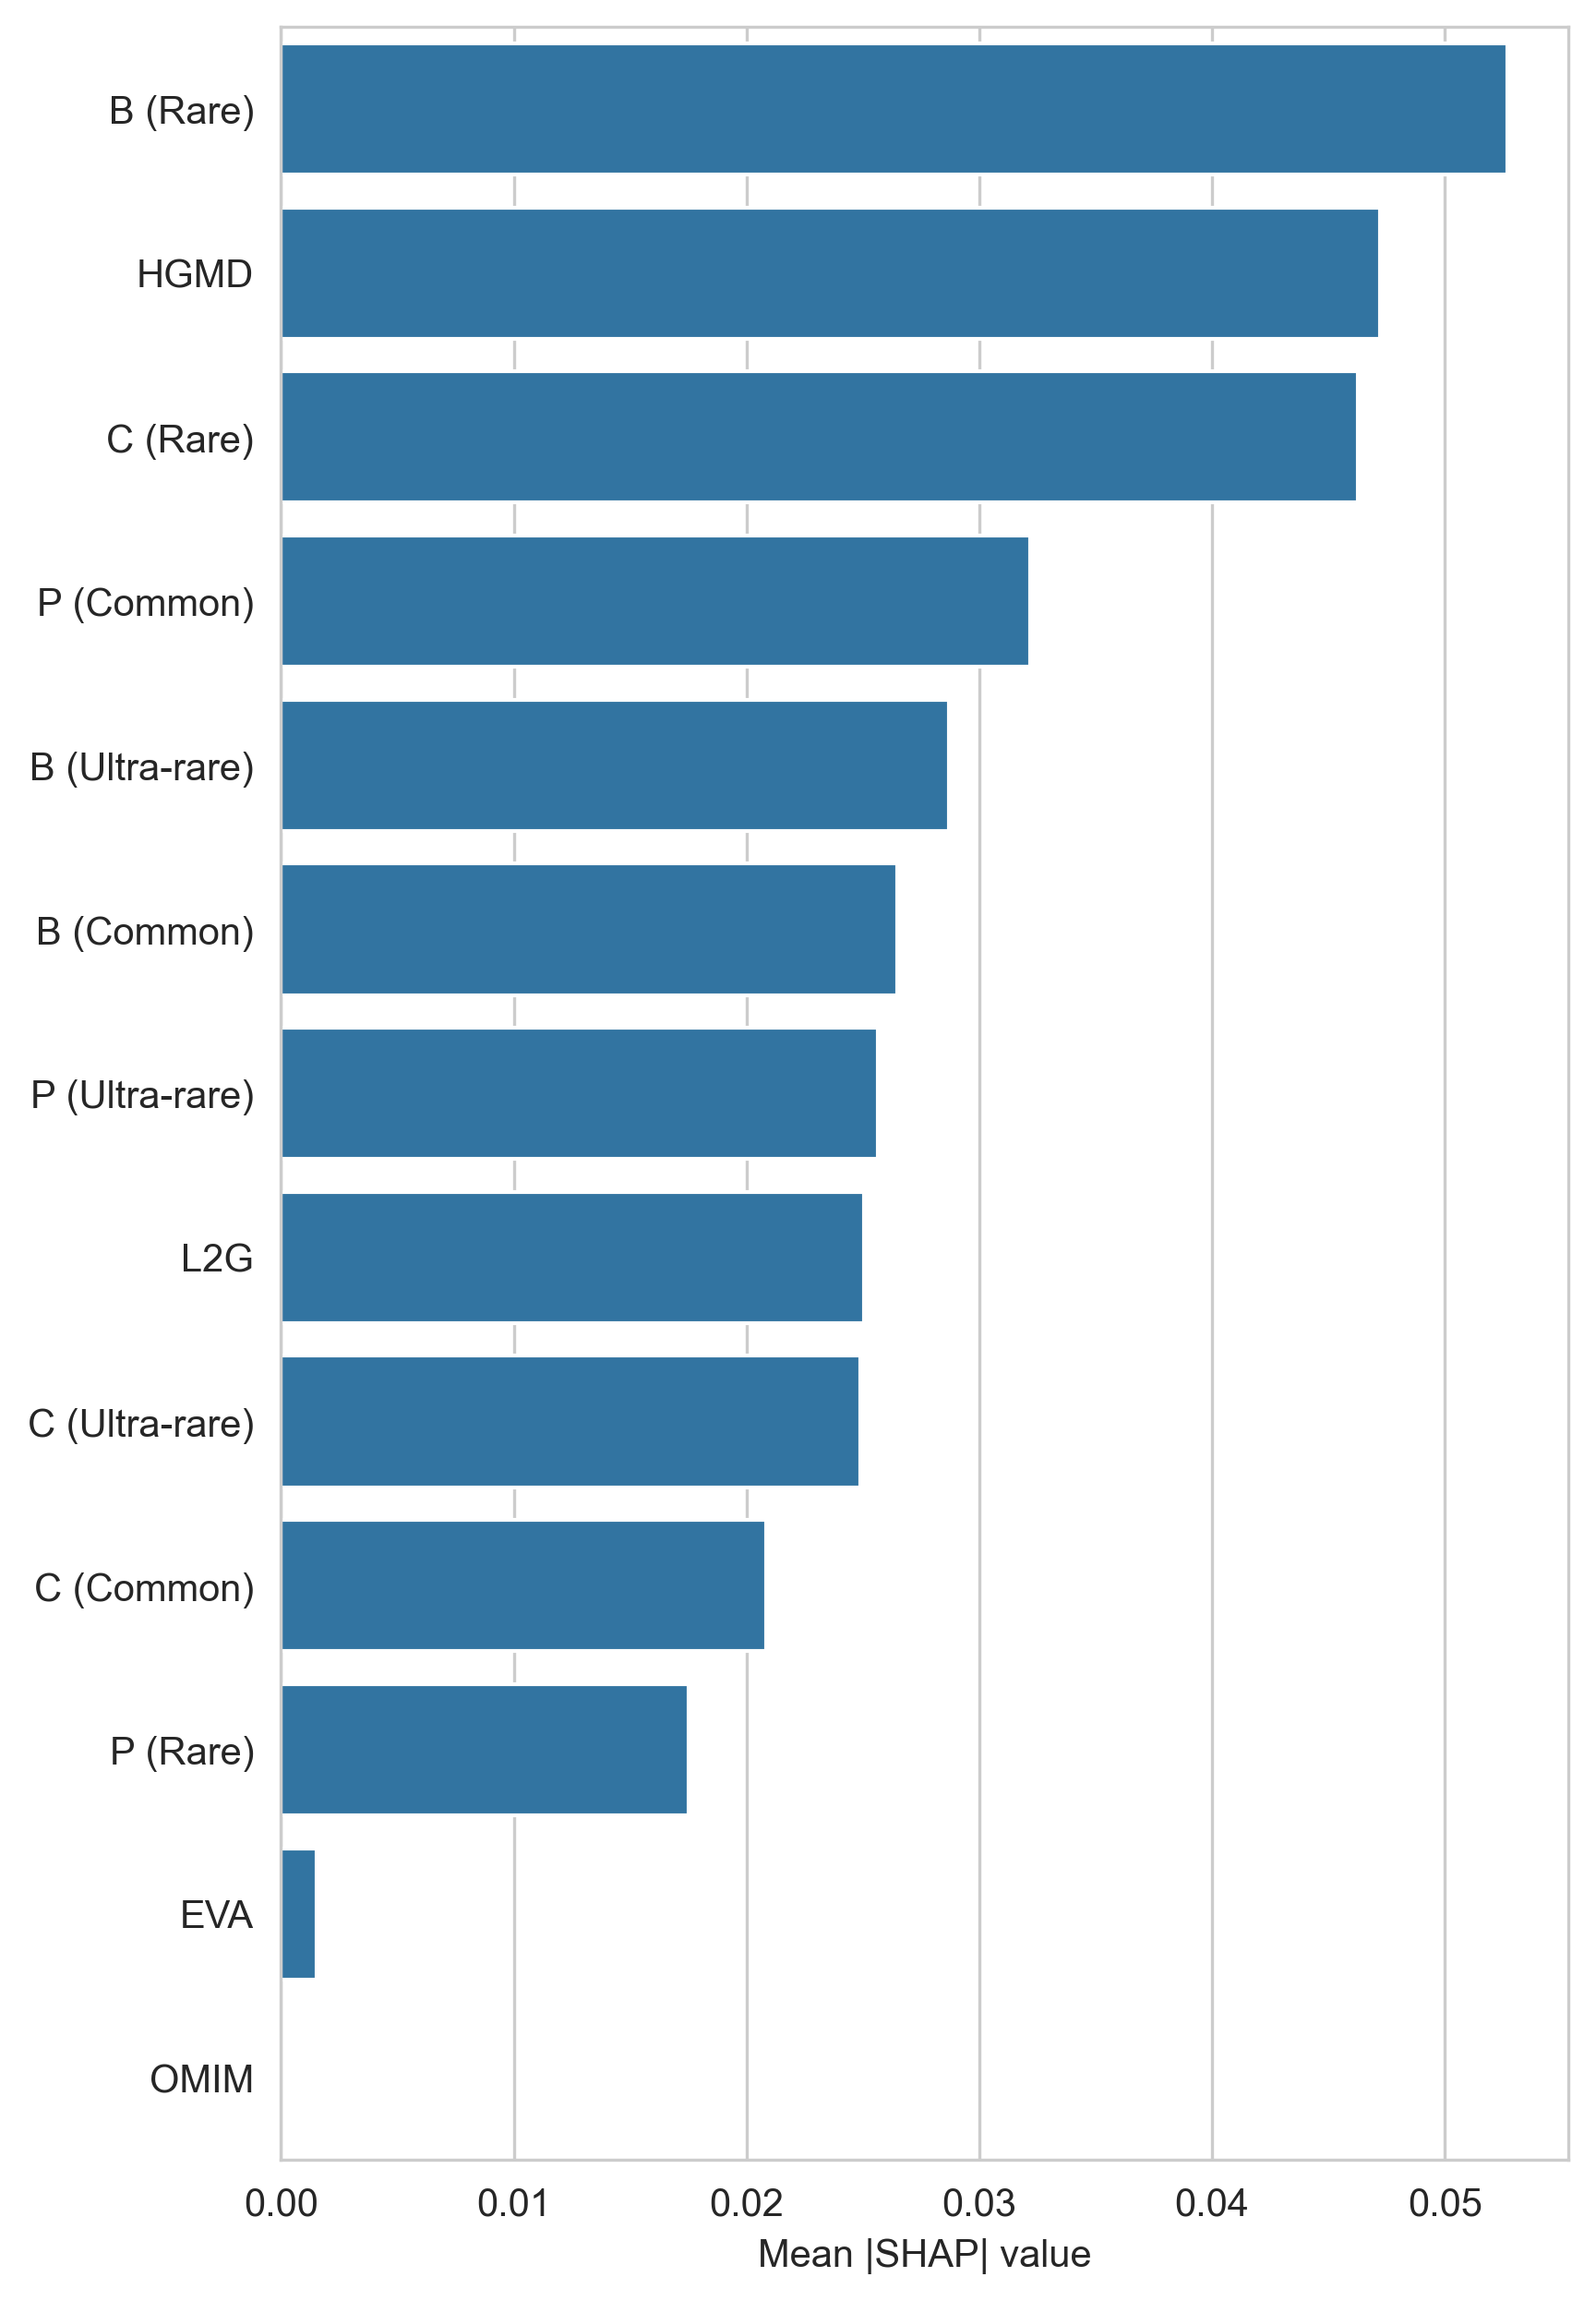

In [23]:
sns.set_style(style='whitegrid')
plt.figure(figsize=(6, 10), dpi=300)

sns.barplot(shap_avg, x='shap', y='feature')

plt.xlabel('Mean |SHAP| value')
plt.ylabel('')

### Calculate metrics

In [ ]:
hold_df = pd.DataFrame()
out_df = pd.DataFrame()

cols = ['LR','GB','GB (CE)','GB (CE, number weight)','GB (CE, phase weight)']

#

for file_name in cols:
    hold = pd.read_pickle(f'./Models/Architecture/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold['model'] = file_name
    hold_df = pd.concat([hold_df,hold])
    
    out = pd.read_pickle(f'./Models/Architecture/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out['model'] = file_name
    out_df = pd.concat([out_df,out])

hold_df = pd.pivot(hold_df, index='g-p', columns='model', values='pred').reset_index()
hold_df = hold_df.merge(input[['g-p','indication','phase']])

out_df = pd.pivot(out_df, index='g-p', columns='model', values='pred').reset_index()
out_df = out_df.merge(output[['g-p','indication','phase']])

#

if True:
    n_bootstraps = 50 # Using fewer bootstraps to speed up calculations
    hold_auprc_results = {key: [] for key in cols}
    out_auprc_results = {key: [] for key in cols}

    for b in range(n_bootstraps):
        sample_df = hold_df.sample(n=len(hold_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            hold_auprc_results[col].append(auprc)

        sample_df = out_df.sample(n=len(out_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            out_auprc_results[col].append(auprc)

    hold_auprc_summary = {}
    out_auprc_summary = {}

    for col in cols:
        mean_auprc = np.mean(hold_auprc_results[col])
        original_stat = average_precision_score(hold_df['indication'], hold_df[col])
        lower_bound, upper_bound = bca_confidence_interval(hold_auprc_results[col], original_stat)
        hold_auprc_summary[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

        mean_auprc = np.mean(out_auprc_results[col])
        original_stat = average_precision_score(out_df['indication'], out_df[col])
        lower_bound, upper_bound = bca_confidence_interval(out_auprc_results[col], original_stat)
        out_auprc_summary[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

    print(hold_auprc_summary)
    print(out_auprc_summary)


{'LR': '0.056 (0.053, 0.059)', 'GB': '0.059 (0.056, 0.064)', 'GB (CE)': '0.075 (0.071, 0.080)', 'GB (CE, number weight)': '0.075 (0.071, 0.080)', 'GB (CE, phase weight)': '0.074 (0.070, 0.079)'}
{'LR': '0.059 (0.053, 0.064)', 'GB': '0.068 (0.061, 0.072)', 'GB (CE)': '0.080 (0.072, 0.087)', 'GB (CE, number weight)': '0.081 (0.072, 0.088)', 'GB (CE, phase weight)': '0.080 (0.073, 0.087)'}


In [ ]:
print(permutation_test(hold_df['indication'], hold_df['LR'], hold_df['GB']))
print(permutation_test(hold_df['indication'], hold_df['GB'], hold_df['GB (CE)']))
print(permutation_test(hold_df['indication'], hold_df['GB (CE)'], hold_df['GB (CE, number weight)']))
print(permutation_test(hold_df['indication'], hold_df['GB (CE)'], hold_df['GB (CE, phase weight)']))
print(permutation_test(hold_df['indication'], hold_df['GB (CE, number weight)'], hold_df['GB (CE, phase weight)']))

In [ ]:
print(permutation_test(out_df['indication'], out_df['LR'], out_df['GB']))
print(permutation_test(out_df['indication'], out_df['GB'], out_df['GB (CE)']))
print(permutation_test(out_df['indication'], out_df['GB (CE)'], out_df['GB (CE, number weight)']))
print(permutation_test(out_df['indication'], out_df['GB (CE)'], out_df['GB (CE, phase weight)']))
print(permutation_test(out_df['indication'], out_df['GB (CE, number weight)'], out_df['GB (CE, phase weight)']))

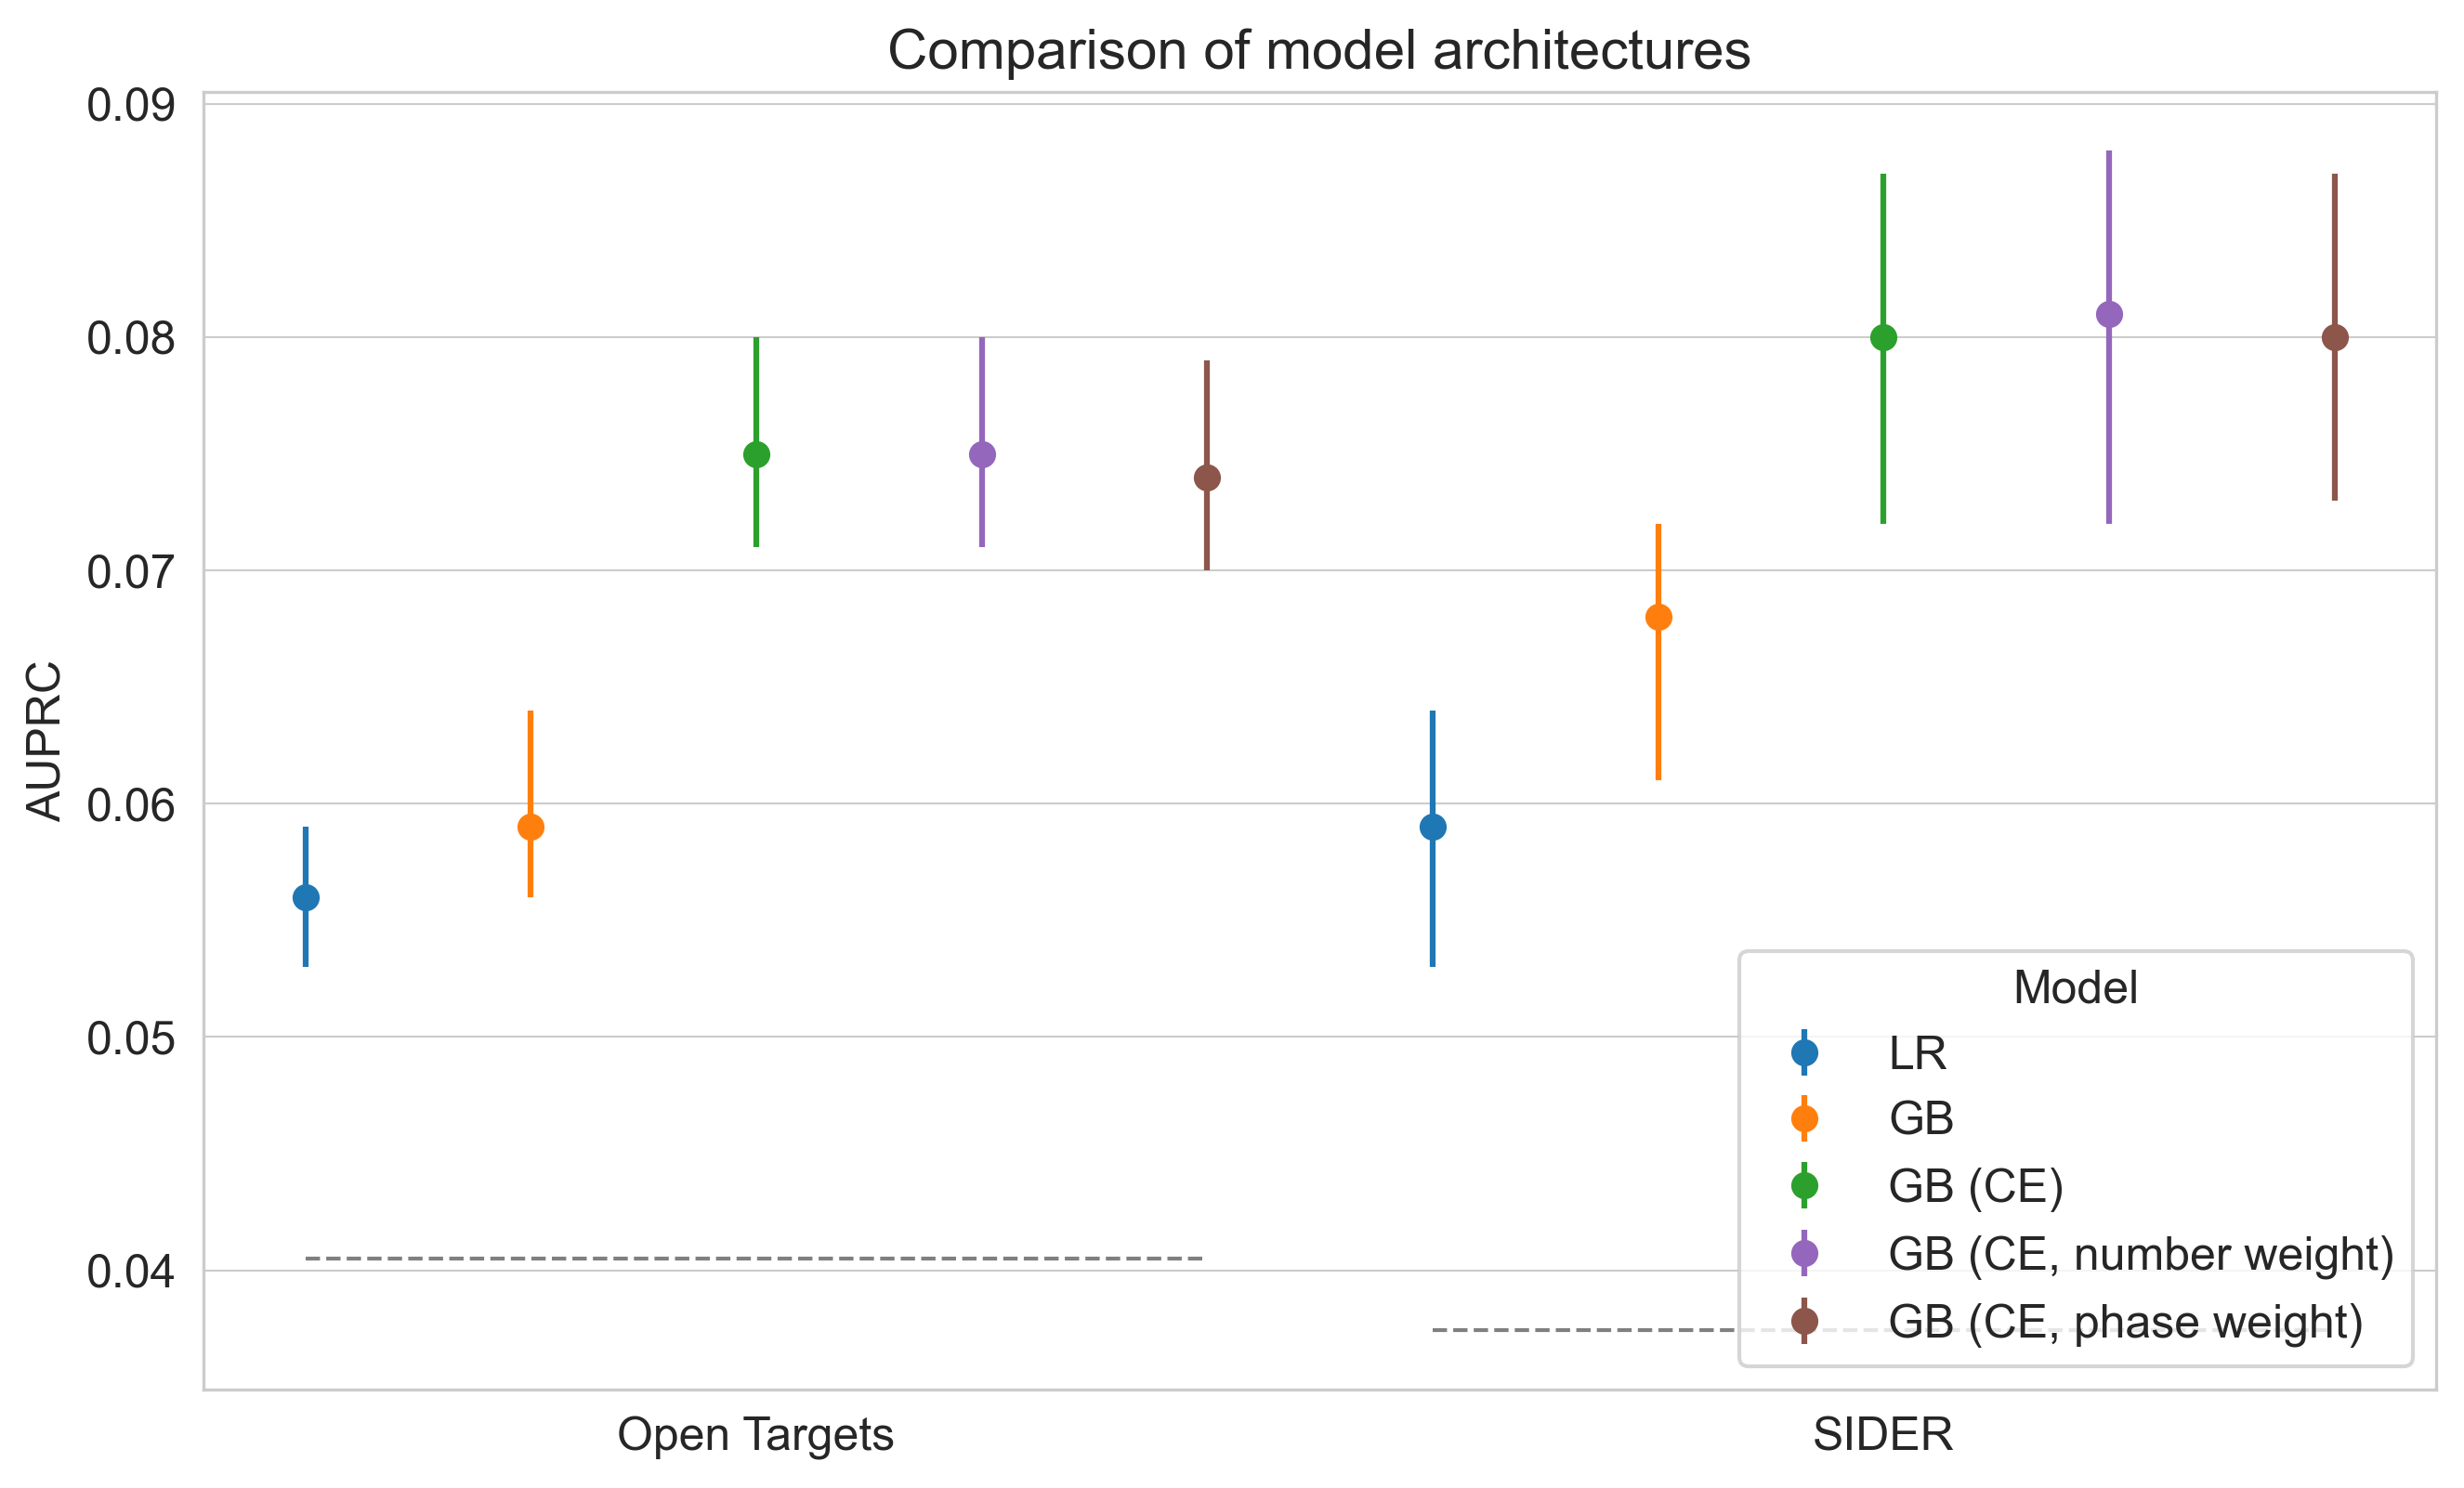

In [34]:
sns.set_style(style='whitegrid')
plt.rcParams.update({'font.size': 12})

def parse_values(data):
    parsed_data = {}
    for key, value in data.items():
        mean, ci = value.split(' ', 1)
        ci_lower, ci_upper = ci.strip('()').split(', ')
        mean = float(mean)
        ci_lower = float(ci_lower)
        ci_upper = float(ci_upper)
        parsed_data[key] = (mean, (mean - ci_lower, ci_upper - mean))
    return parsed_data

parsed_hold = parse_values(hold_auprc_summary)
parsed_out = parse_values(out_auprc_summary)

# Setup for plotting
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=300)

# Define x-axis positions for the two groups
group_positions = [1, 2]  # For auprc_hold and auprc_out
width = 0.1  # Width of each bar/error bar

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']

def plot_group(group_data, position, color):
    labels = list(group_data.keys())
    num_labels = len(labels)
    total_width = width * 2 * (num_labels - 1)
    start_x = position - total_width / 2

    xpos = []
    for i, label in enumerate(labels):
        # Use the standard Matplotlib colors, cycling through if there are more models than colors
        color = default_colors[i % len(default_colors)]
        x = start_x + i * width * 2  # Adjust the spacing here
        xpos.append(x)
        mean, ci = group_data[label]
        ax.errorbar(x, mean, yerr=[[ci[0]], [ci[1]]], fmt='o', color=color, label=label if position == 1 else "_nolegend_")
    return min(xpos), max(xpos)

# Plot each group and get x positions for lines
xmin_hold, xmax_hold = plot_group(parsed_hold, group_positions[0], default_colors)
xmin_out, xmax_out = plot_group(parsed_out, group_positions[1], default_colors)

# Plot horizontal lines
ax.hlines(hold_df['indication'].mean(), xmin_hold, xmax_hold, colors='grey', linestyles='dashed', linewidth=1)
ax.hlines(out_df['indication'].mean(), xmin_out, xmax_out, colors='grey', linestyles='dashed', linewidth=1)

# Customizing the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(['Open Targets', 'SIDER'])
ax.set_ylabel('AUPRC')

# Generate legend without duplicates
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title='Model', loc='lower right')

plt.title('Comparison of model architectures')
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.grid(False, which='both', axis='x') # Disable vertical grid lines

plt.tight_layout()
plt.show()


In [24]:
results_df = []

percentiles = [(0.75,0.85),(0.85,0.95),(0.95,0.98),(0.98,0.99),(0.99,1.00)]

for file_name in ['LR','GB','GB (CE)','GB (CE, number weight)','GB (CE, phase weight)']:

    hold = pd.read_pickle(f'./Models/Architecture/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold = hold.merge(input[['g-p','indication','phase','oe','BI','CV','EM']])
    out = pd.read_pickle(f'./Models/Architecture/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out = out.merge(output[['g-p','indication','phase','oe','BI','CV','EM']])

    if file_name != 'LR':
        imp = pd.read_pickle(f'./Models/Architecture/importance_{file_name}.pkl').groupby(['outer_fold','feature'])[['imp_gain','imp_split']].mean().reset_index()
        imp = imp.groupby(['feature']).agg({'imp_gain': mean_ci_df, 'imp_split': mean_ci_df})
        imp = {'imp_gain':imp['imp_gain'].to_dict(), 'imp_split':imp['imp_split'].to_dict()}
    else:
        metrics = pd.read_pickle(f'./Models/Architecture/metrics_{file_name}.pkl')
        coef = metrics['coef'][0]
        coef = {'coef':coef}

    hold_results = {
        "features": file_name,
        "hold_prop": hold['indication'].mean(),
        "hold_or": or_top_bottom(hold,percentiles),
        "hold_or_phase": or_phase(hold)
    }

    out_results = {
        "out_prop": out['indication'].mean(),
        "out_or": or_top_bottom(out,percentiles)
    }

    if file_name != 'LR':
        results_df.append({**hold_results, **out_results, **imp})
    else:
        results_df.append({**hold_results, **out_results, **coef})

pd.DataFrame(results_df).to_excel('./Models/Architecture/results.xlsx')

Optimization terminated successfully.
         Current function value: 0.159354
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.163718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038682
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073729
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072947
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039964
  

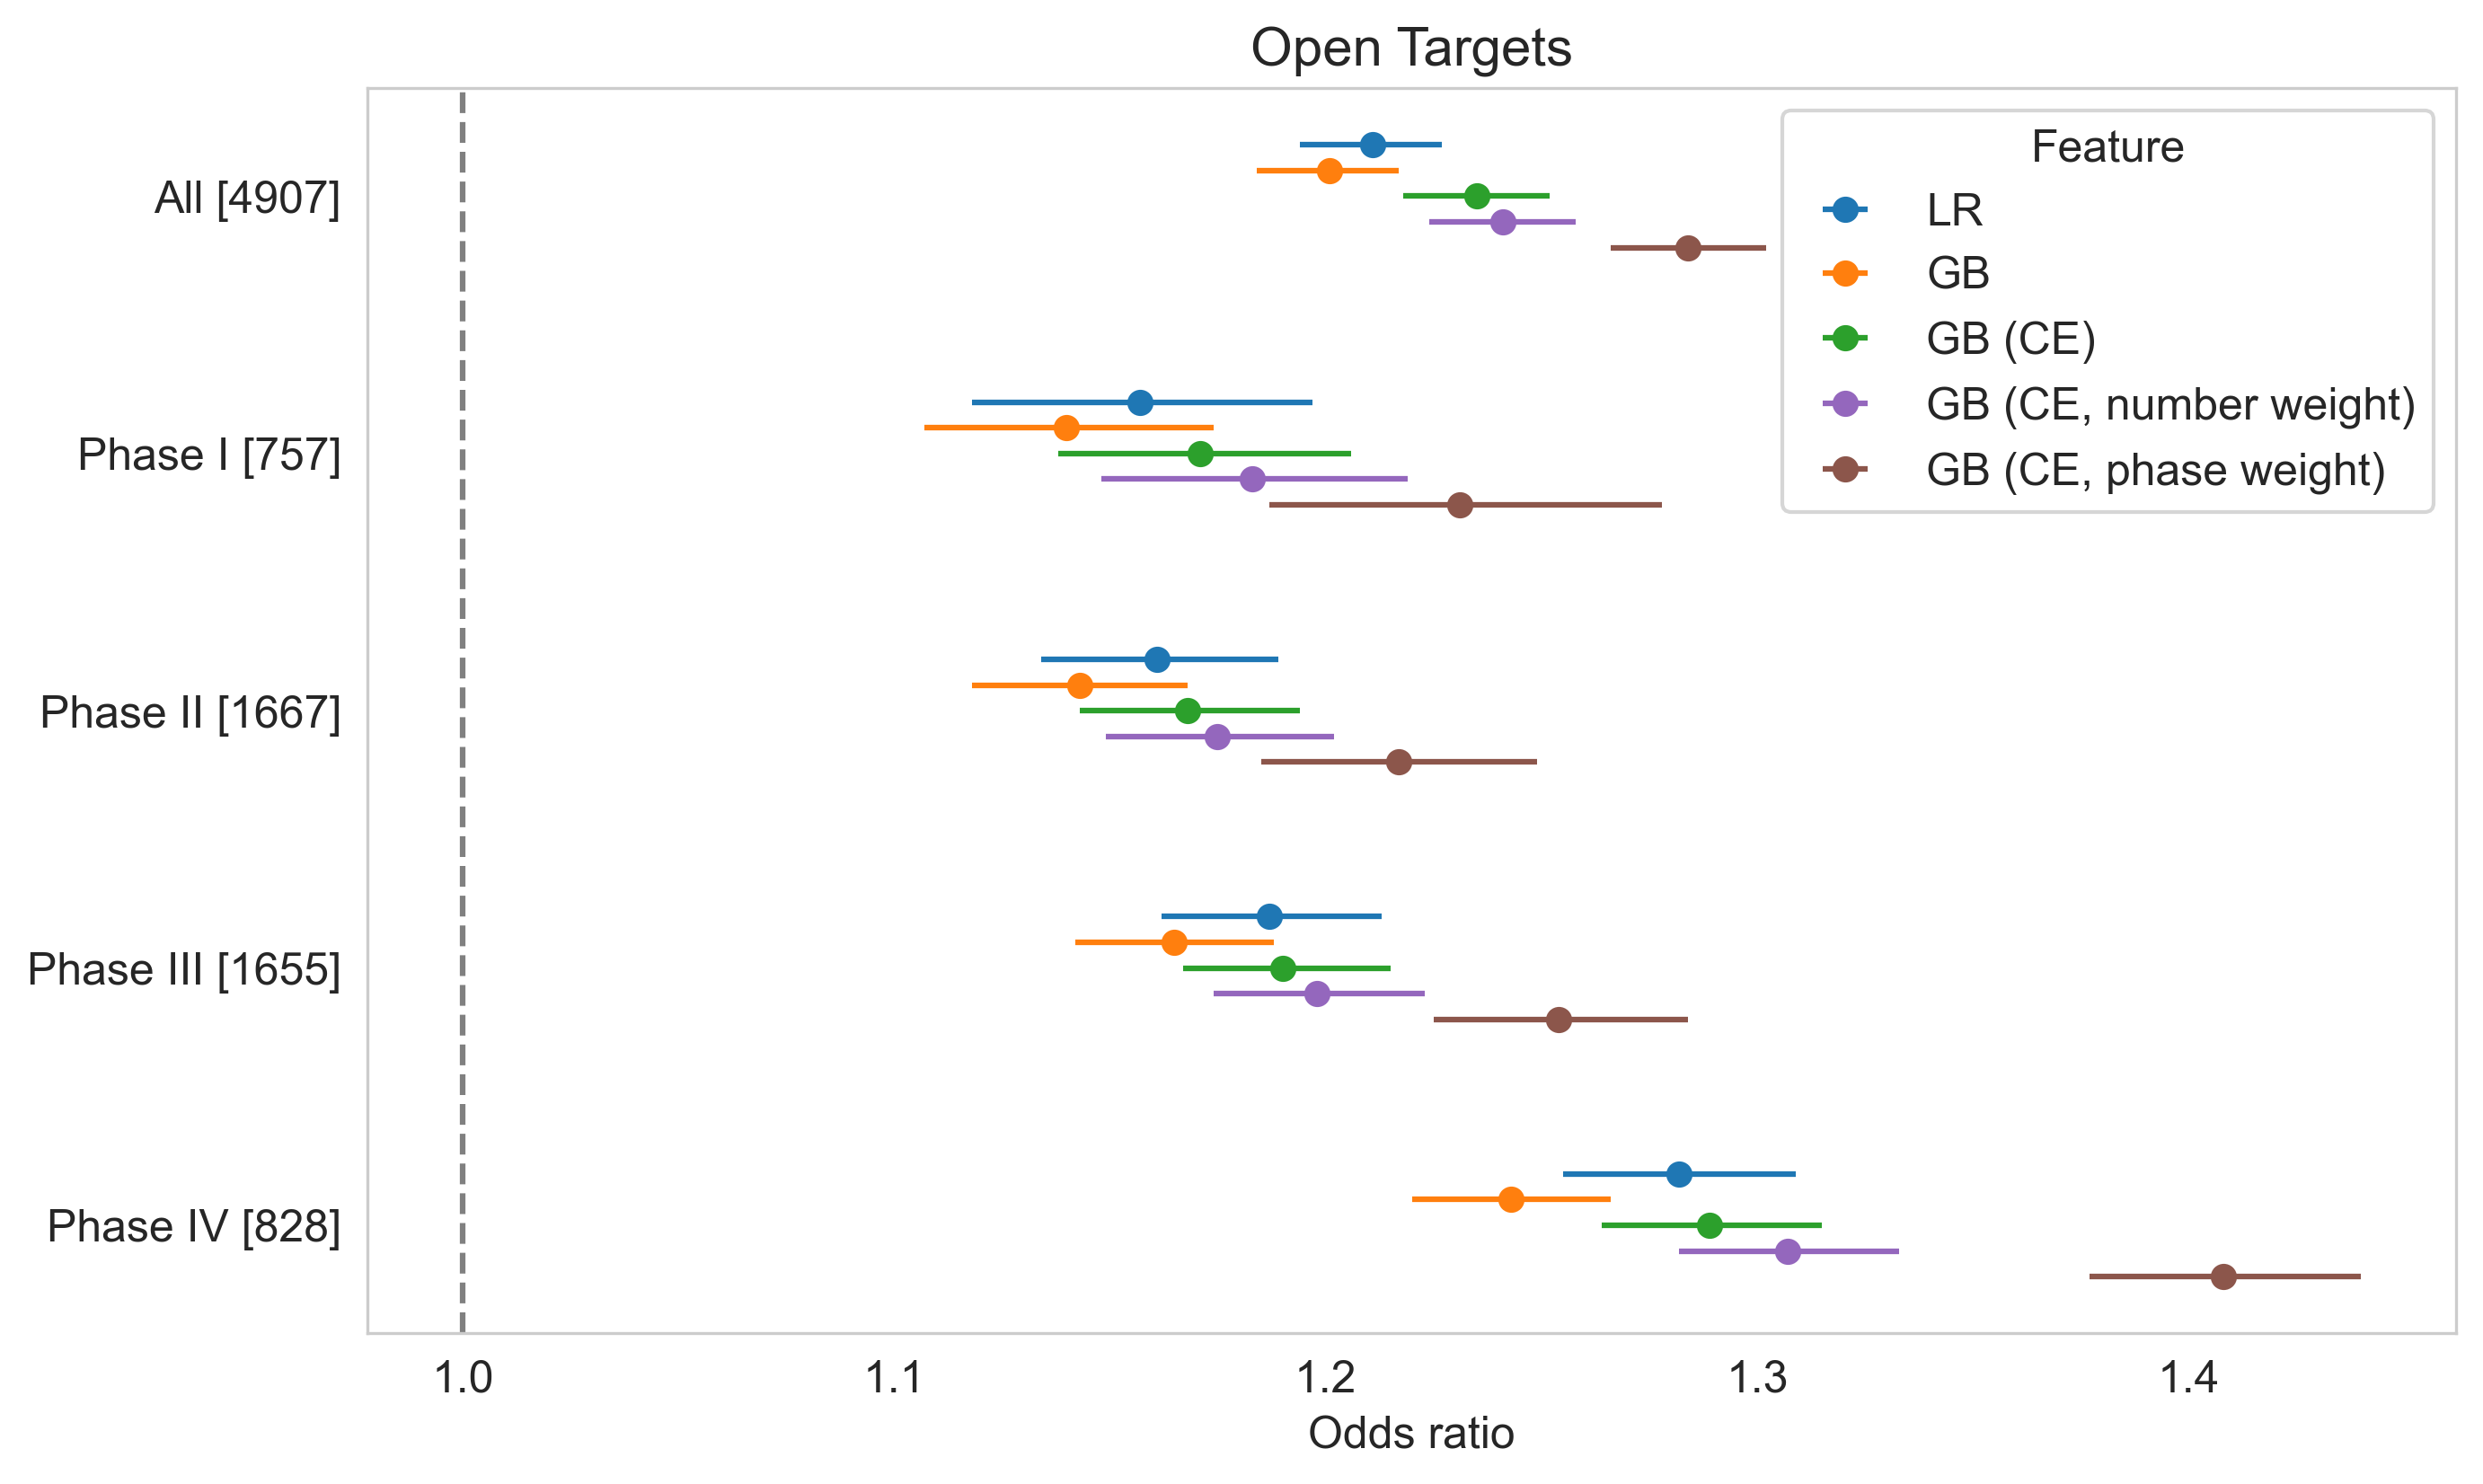

In [28]:
sns.set_style(style='whitegrid')

df = pd.read_excel('./Models/Architecture/results.xlsx')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 1','Phase I')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 2','Phase II')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 3','Phase III')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 4','Phase IV')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_phase'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()


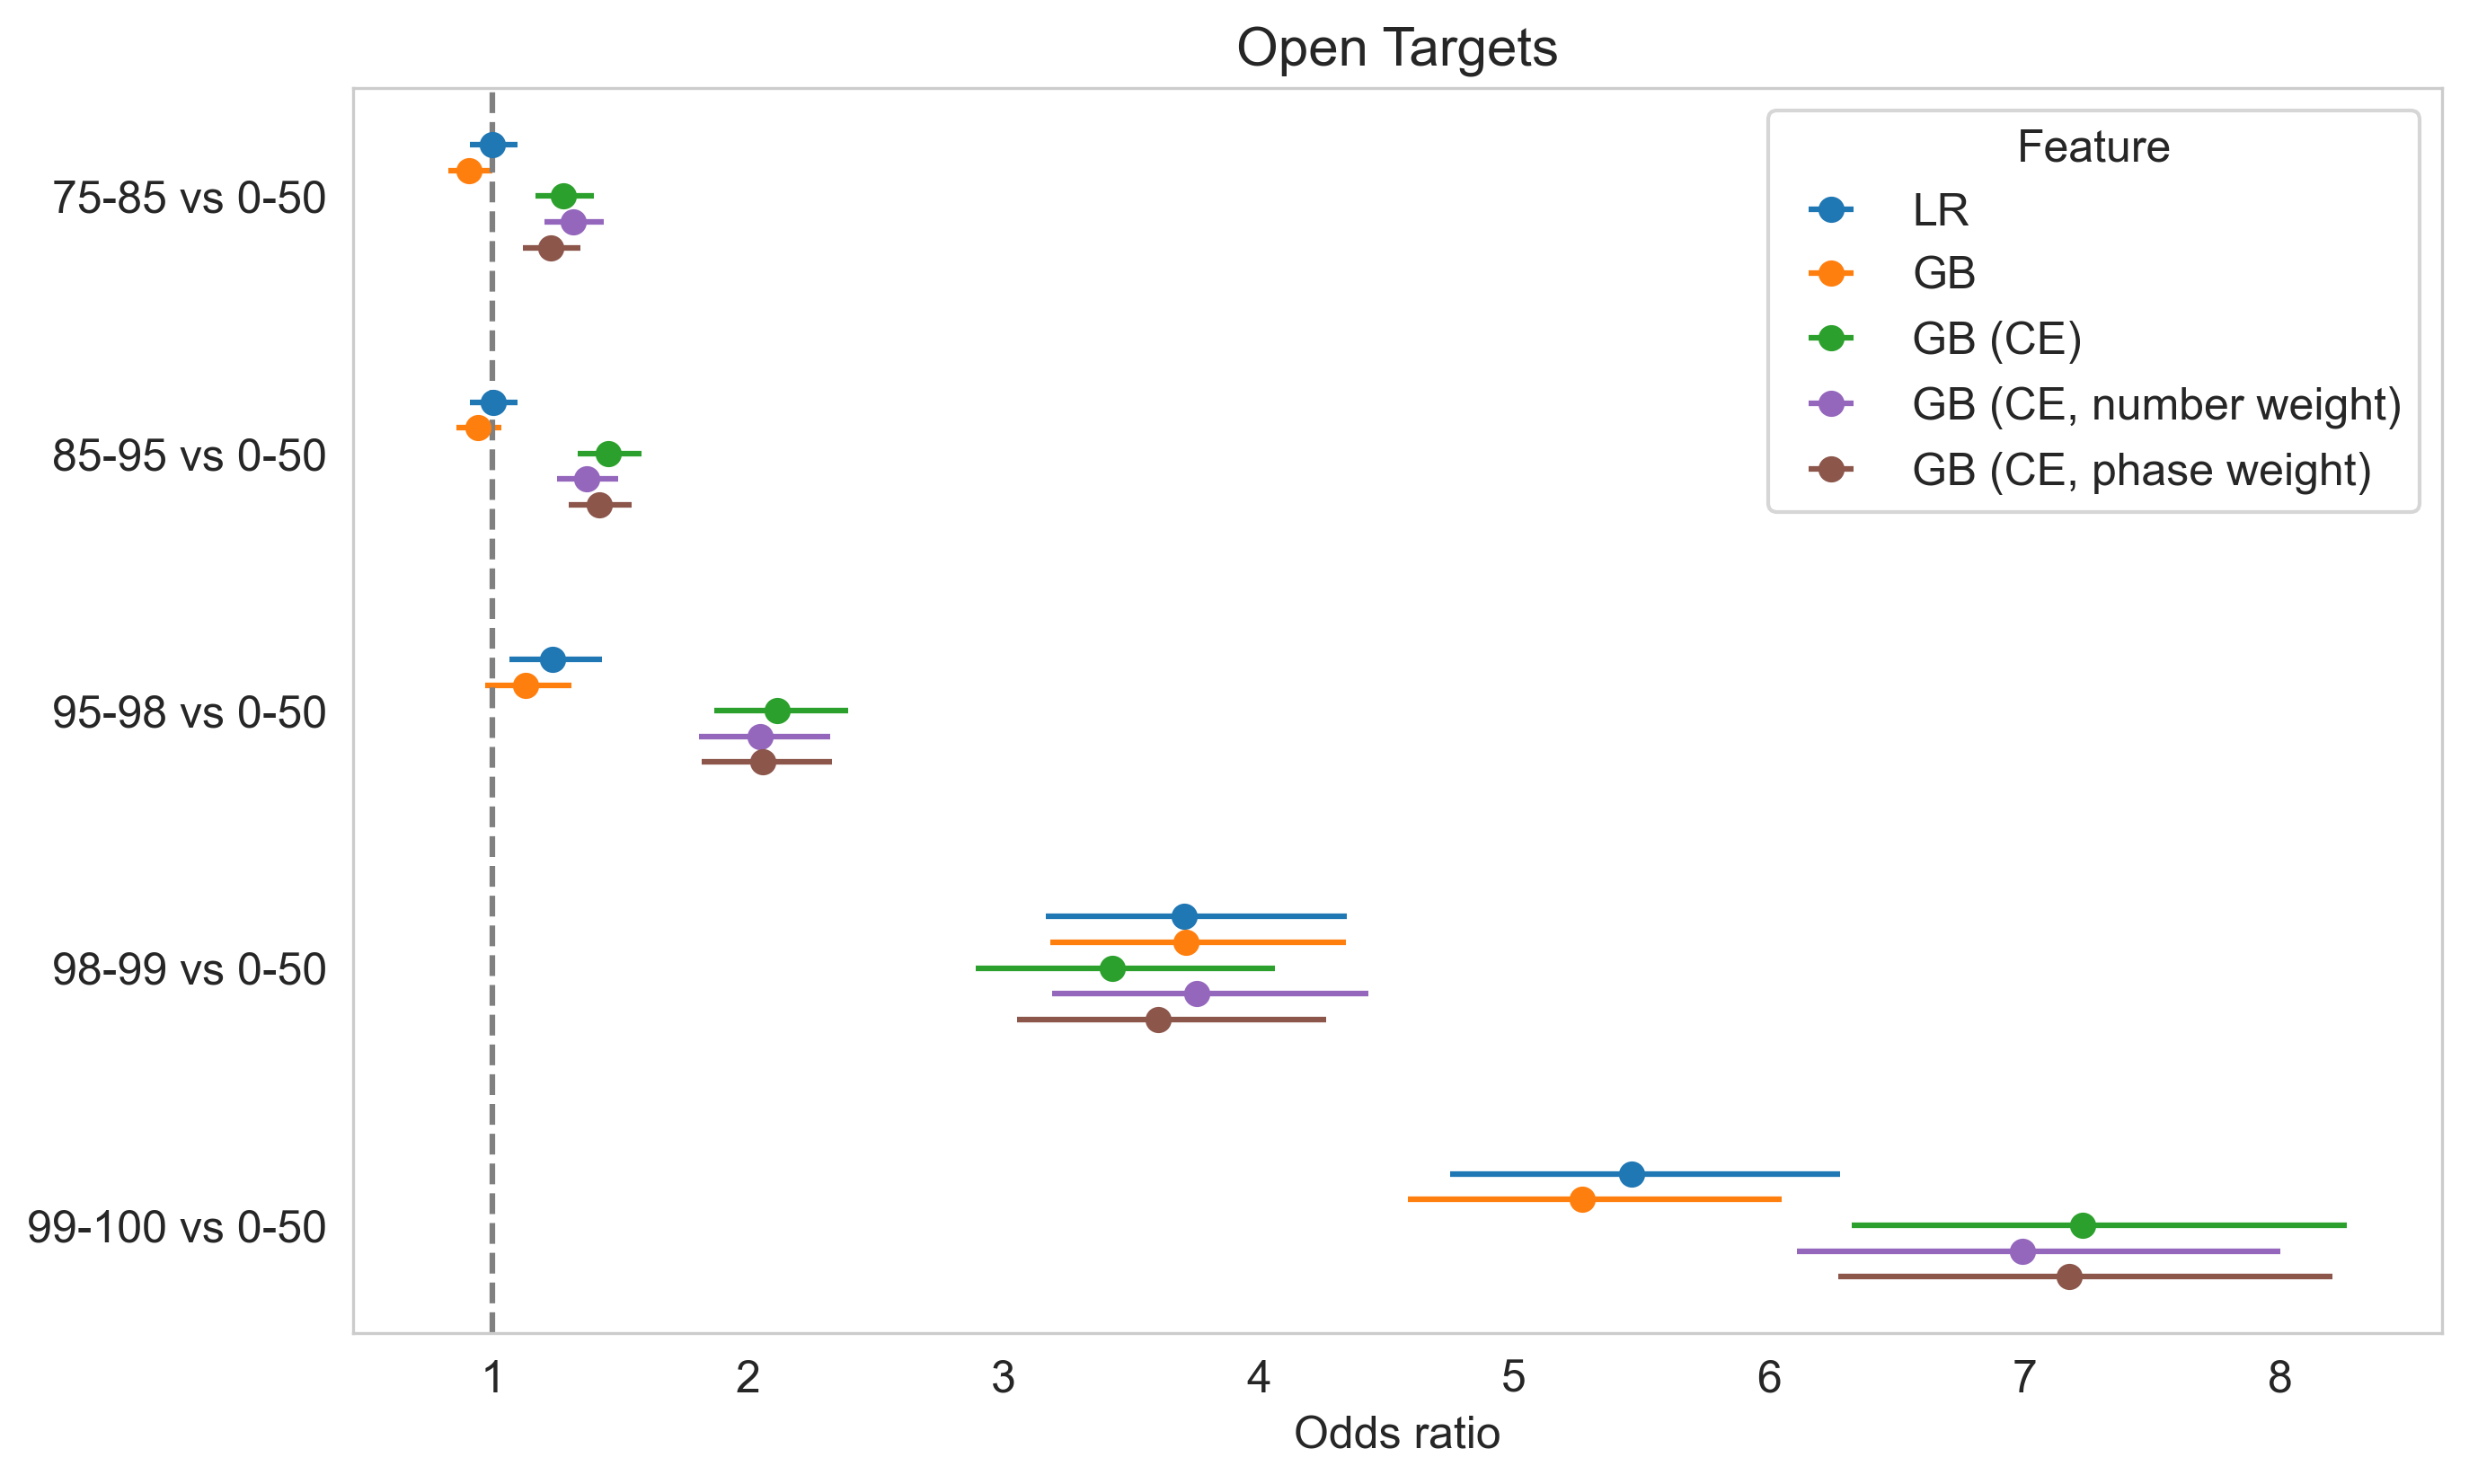

In [27]:
df = pd.read_excel('./Models/Architecture/results.xlsx')
plt.rcParams.update({'font.size': 12})

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

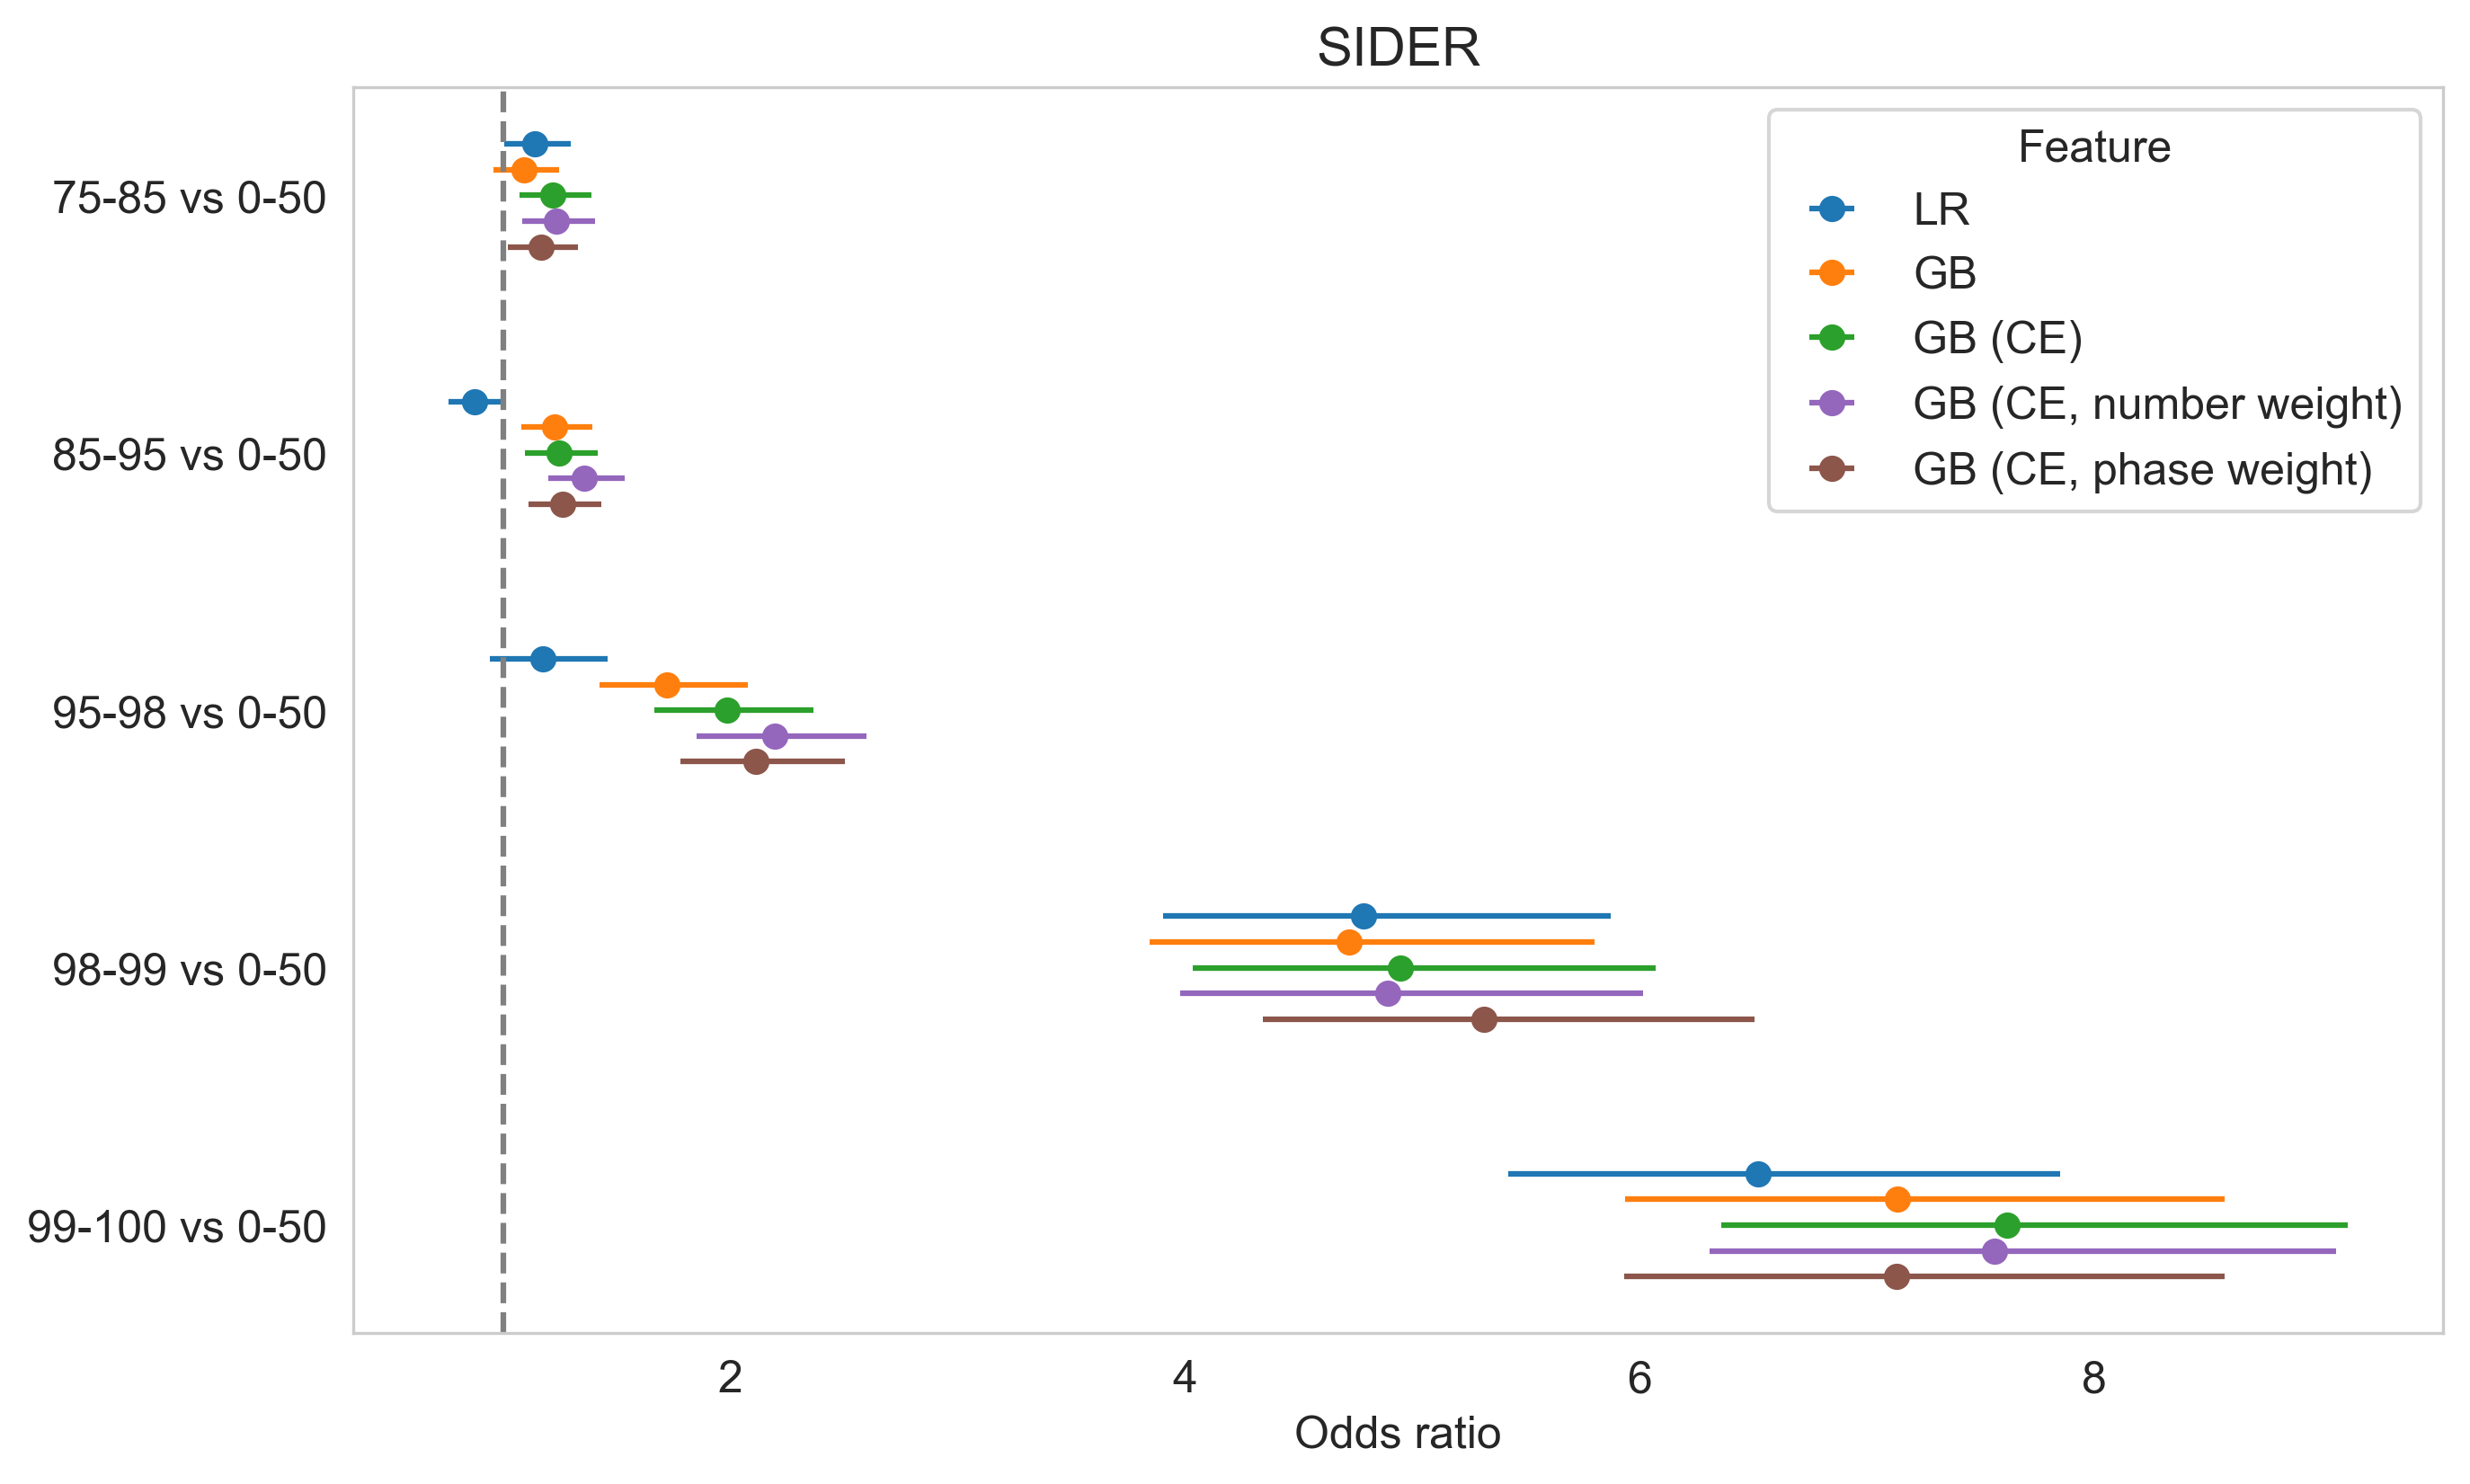

In [30]:
df = pd.read_excel('./Models/Architecture/results.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['out_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('SIDER')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

## LightGBM vs XGBoost vs random forest

In [35]:
hold_df = pd.DataFrame()
out_df = pd.DataFrame()

cols = ['RF (CE, phase weight)','XGB (CE, phase weight)','GB (CE, phase weight)']

#

for file_name in cols:
    hold = pd.read_pickle(f'./Models/Architecture/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold['model'] = file_name
    hold_df = pd.concat([hold_df,hold])
    
    out = pd.read_pickle(f'./Models/Architecture/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out['model'] = file_name
    out_df = pd.concat([out_df,out])

hold_df = pd.pivot(hold_df, index='g-p', columns='model', values='pred').reset_index()
hold_df = hold_df.merge(input[['g-p','indication','phase']])

out_df = pd.pivot(out_df, index='g-p', columns='model', values='pred').reset_index()
out_df = out_df.merge(output[['g-p','indication','phase']])

#

if True:
    n_bootstraps = 50 # Using fewer bootstraps to speed up calculations
    hold_auprc_results = {key: [] for key in cols}
    out_auprc_results = {key: [] for key in cols}

    for b in range(n_bootstraps):
        sample_df = hold_df.sample(n=len(hold_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            hold_auprc_results[col].append(auprc)

        sample_df = out_df.sample(n=len(out_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            out_auprc_results[col].append(auprc)

    hold_auprc_summary = {}
    out_auprc_summary = {}

    for col in cols:
        mean_auprc = np.mean(hold_auprc_results[col])
        original_stat = average_precision_score(hold_df['indication'], hold_df[col])
        lower_bound, upper_bound = bca_confidence_interval(hold_auprc_results[col], original_stat)
        hold_auprc_summary[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

        mean_auprc = np.mean(out_auprc_results[col])
        original_stat = average_precision_score(out_df['indication'], out_df[col])
        lower_bound, upper_bound = bca_confidence_interval(out_auprc_results[col], original_stat)
        out_auprc_summary[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

    print(hold_auprc_summary)
    print(out_auprc_summary)


{'RF (CE, phase weight)': '0.066 (0.062, 0.070)', 'XGB (CE, phase weight)': '0.070 (0.067, 0.075)', 'GB (CE, phase weight)': '0.074 (0.070, 0.079)'}
{'RF (CE, phase weight)': '0.069 (0.064, 0.075)', 'XGB (CE, phase weight)': '0.077 (0.069, 0.083)', 'GB (CE, phase weight)': '0.081 (0.071, 0.084)'}


In [ ]:
print(permutation_test(hold_df['indication'], hold_df['GB (CE, phase weight)'], hold_df['XGB (CE, phase weight)']))
print(permutation_test(hold_df['indication'], hold_df['GB (CE, phase weight)'], hold_df['RF (CE, phase weight)']))
print(permutation_test(hold_df['indication'], hold_df['RF (CE, phase weight)'], hold_df['XGB (CE, phase weight)']))

print(permutation_test(out_df['indication'], out_df['GB (CE, phase weight)'], out_df['XGB (CE, phase weight)']))
print(permutation_test(out_df['indication'], out_df['GB (CE, phase weight)'], out_df['RF (CE, phase weight)']))
print(permutation_test(out_df['indication'], out_df['RF (CE, phase weight)'], out_df['XGB (CE, phase weight)']))

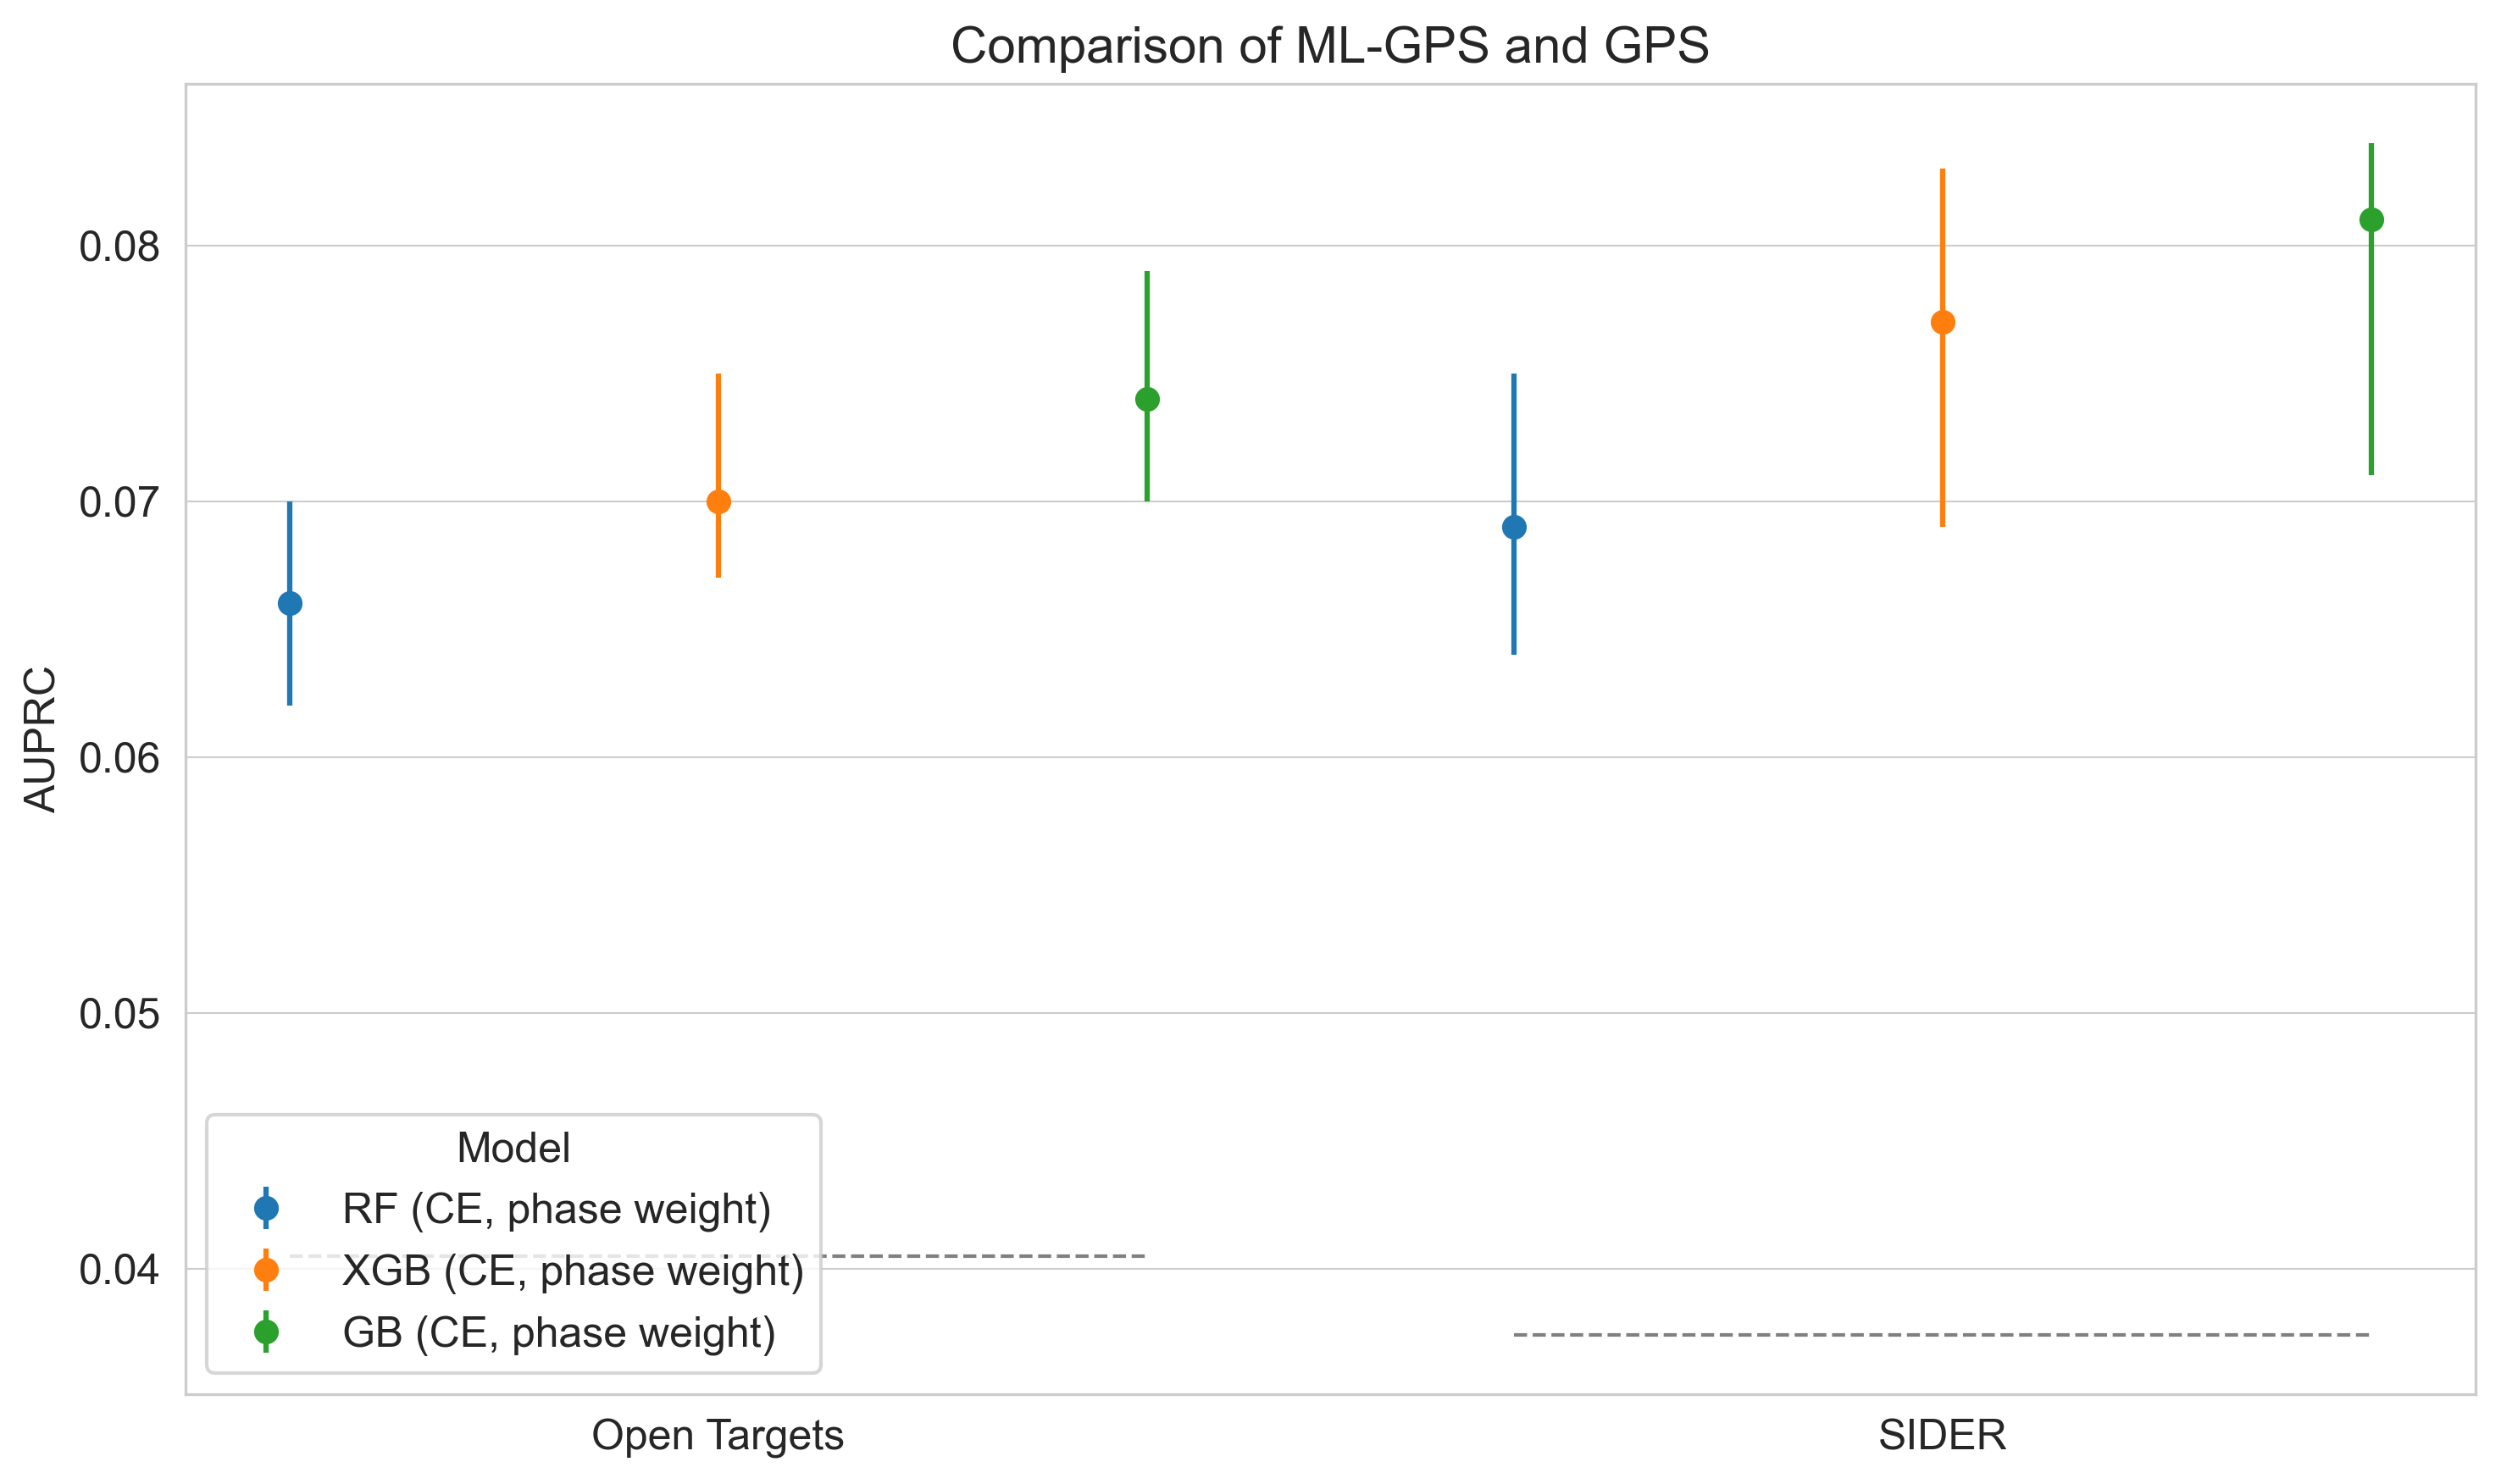

In [36]:
sns.set_style(style='whitegrid')

def parse_values(data):
    parsed_data = {}
    for key, value in data.items():
        mean, ci = value.split(' ', 1)
        ci_lower, ci_upper = ci.strip('()').split(', ')
        mean = float(mean)
        ci_lower = float(ci_lower)
        ci_upper = float(ci_upper)
        parsed_data[key] = (mean, (mean - ci_lower, ci_upper - mean))
    return parsed_data

parsed_hold = parse_values(hold_auprc_summary)
parsed_out = parse_values(out_auprc_summary)

# Setup for plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Define x-axis positions for the two groups
group_positions = [1, 2]  # For auprc_hold and auprc_out
width = 0.175  # Width of each bar/error bar

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_group(group_data, position, color):
    labels = list(group_data.keys())
    num_labels = len(labels)
    total_width = width * 2 * (num_labels - 1)
    start_x = position - total_width / 2

    xpos = []
    for i, label in enumerate(labels):
        # Use the standard Matplotlib colors, cycling through if there are more models than colors
        color = default_colors[i % len(default_colors)]
        x = start_x + i * width * 2  # Adjust the spacing here
        xpos.append(x)
        mean, ci = group_data[label]
        ax.errorbar(x, mean, yerr=[[ci[0]], [ci[1]]], fmt='o', color=color, label=label if position == 1 else "_nolegend_")
    return min(xpos), max(xpos)

# Plot each group and get x positions for lines
xmin_hold, xmax_hold = plot_group(parsed_hold, group_positions[0], default_colors)
xmin_out, xmax_out = plot_group(parsed_out, group_positions[1], default_colors)

# Plot horizontal lines
ax.hlines(hold_df['indication'].mean(), xmin_hold, xmax_hold, colors='grey', linestyles='dashed', linewidth=1)
ax.hlines(out_df['indication'].mean(), xmin_out, xmax_out, colors='grey', linestyles='dashed', linewidth=1)

# Customizing the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(['Open Targets', 'SIDER'])
ax.set_ylabel('AUPRC')

# Generate legend without duplicates
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title='Model', loc='lower left')

plt.title('Comparison of ML-GPS and GPS')
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.grid(False, which='both', axis='x') # Disable vertical grid lines

plt.tight_layout()
plt.show()


In [37]:
results_df = []

percentiles = [(0.75,0.85),(0.85,0.95),(0.95,0.98),(0.98,0.99),(0.99,1.00)]

for file_name in ['RF (CE, phase weight)','XGB (CE, phase weight)','GB (CE, phase weight)']:

    hold = pd.read_pickle(f'./Models/Architecture/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold = hold.merge(input[['g-p','indication','phase','oe','BI','CV','EM']])
    out = pd.read_pickle(f'./Models/Architecture/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out = out.merge(output[['g-p','indication','phase','oe','BI','CV','EM']])

    hold_results = {
        "features": file_name,
        "hold_prop": hold['indication'].mean(),
        "hold_or": or_top_bottom(hold,percentiles),
        "hold_or_phase": or_phase(hold)
    }

    out_results = {
        "out_prop": out['indication'].mean(),
        "out_or": or_top_bottom(out,percentiles)
    }

    if file_name != 'LR':
        results_df.append({**hold_results, **out_results})
    else:
        results_df.append({**hold_results, **out_results})

temp = pd.DataFrame(results_df)
temp['features'] = ['Random forest (CE, phase weight)','XGBoost (CE, phase weight)','LightGBM (CE, phase weight)']
temp.to_excel('./Models/Architecture/results_rf_xgb_lgb.xlsx')

Optimization terminated successfully.
         Current function value: 0.152696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155607
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072907
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039978
  

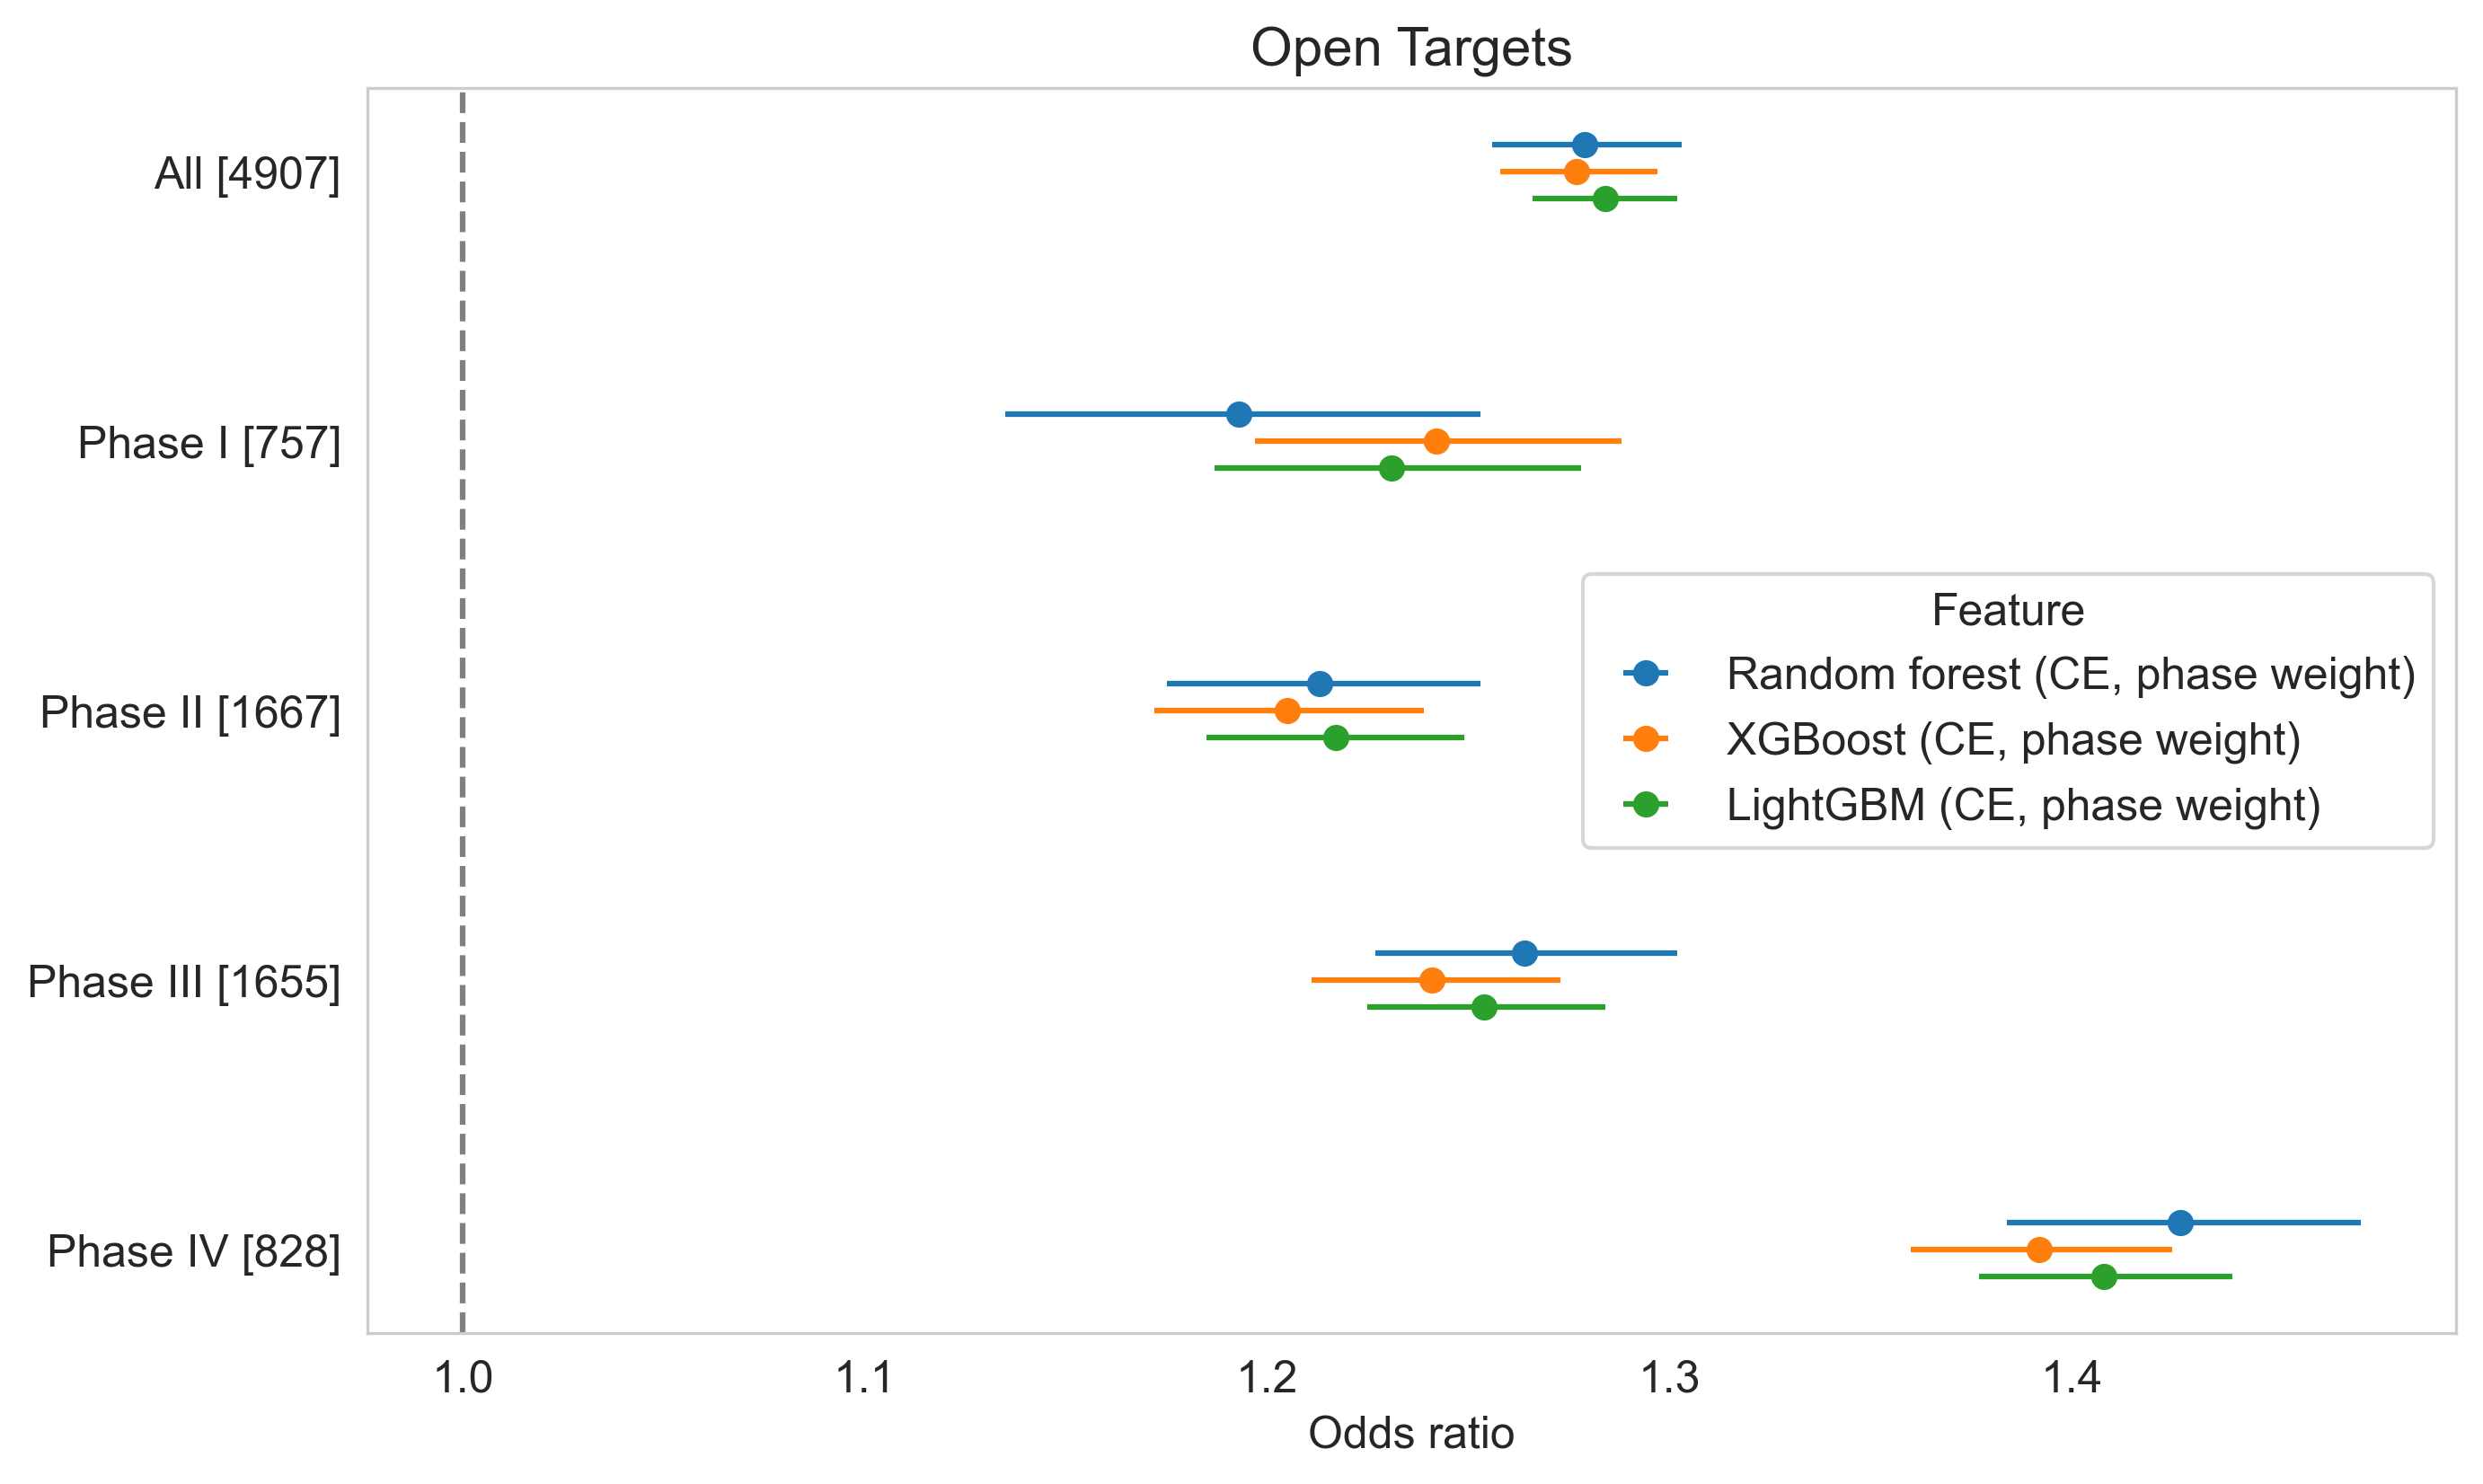

In [41]:
df = pd.read_excel('./Models/Architecture/results_rf_xgb_lgb.xlsx')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 1','Phase I')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 2','Phase II')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 3','Phase III')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 4','Phase IV')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_phase'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for feature in features:
    subset = plot_df[plot_df['Feature'] == feature]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

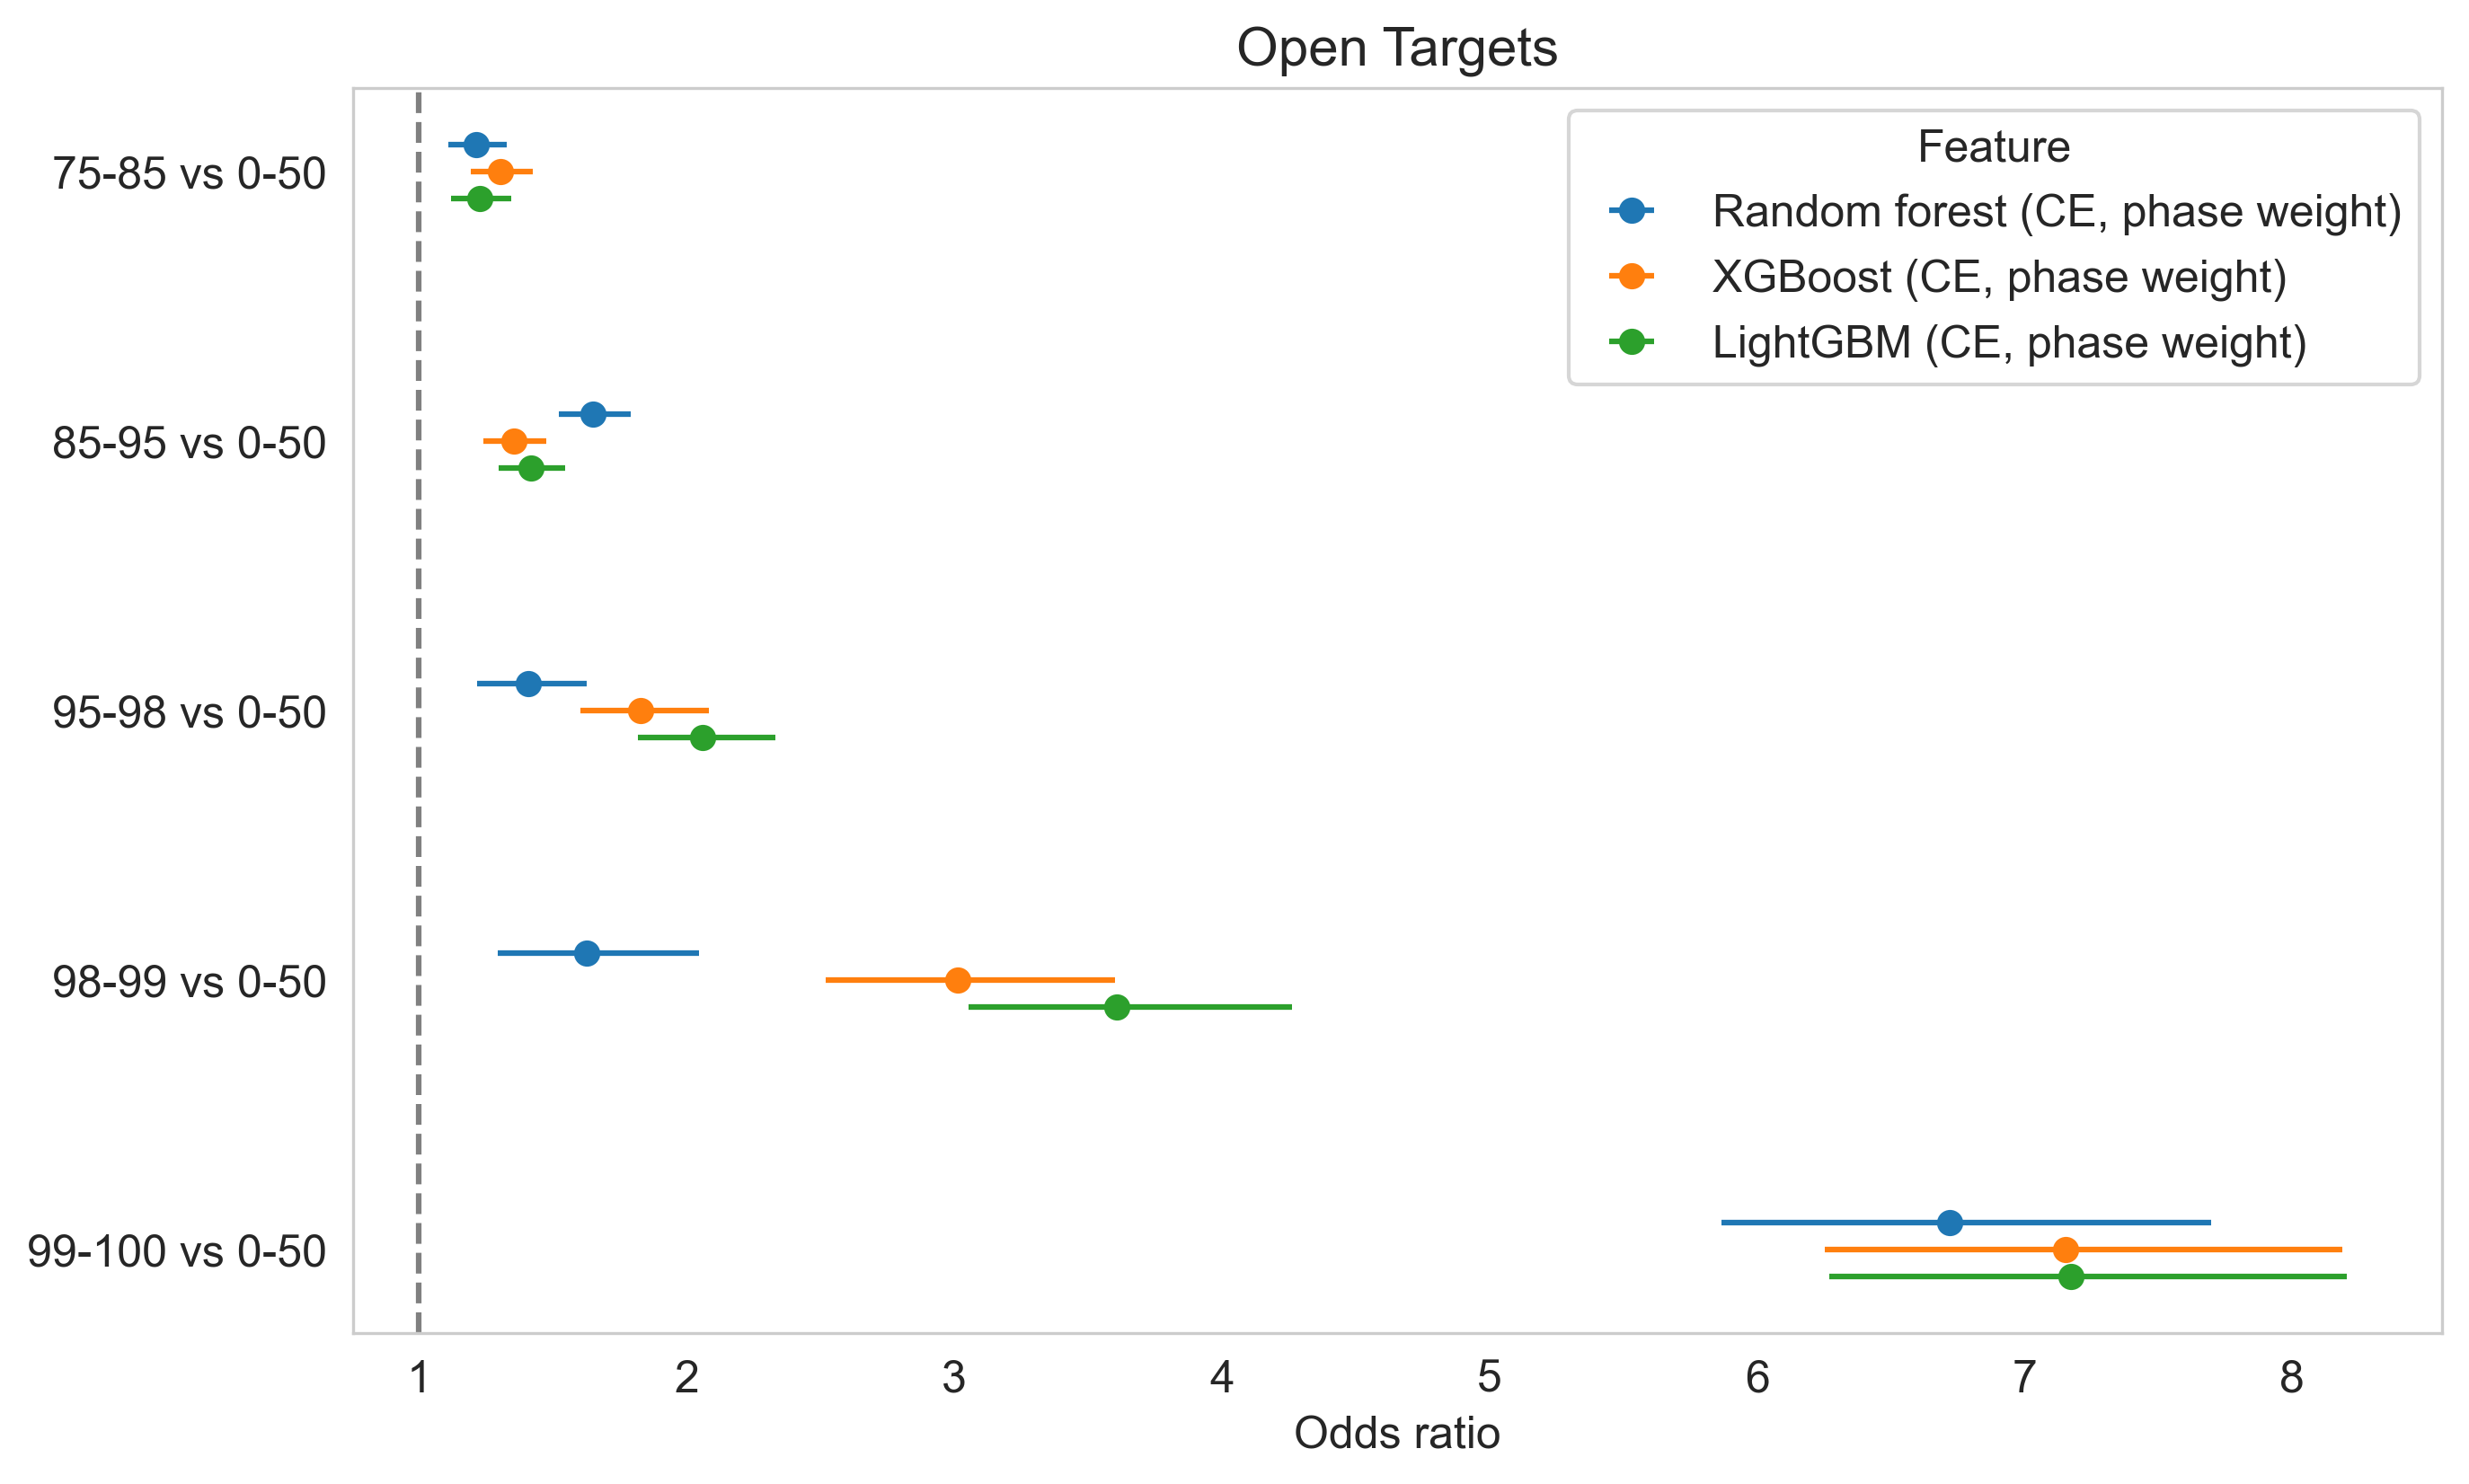

In [40]:
df = pd.read_excel('./Models/Architecture/results_rf_xgb_lgb.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for feature in features:
    subset = plot_df[plot_df['Feature'] == feature]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

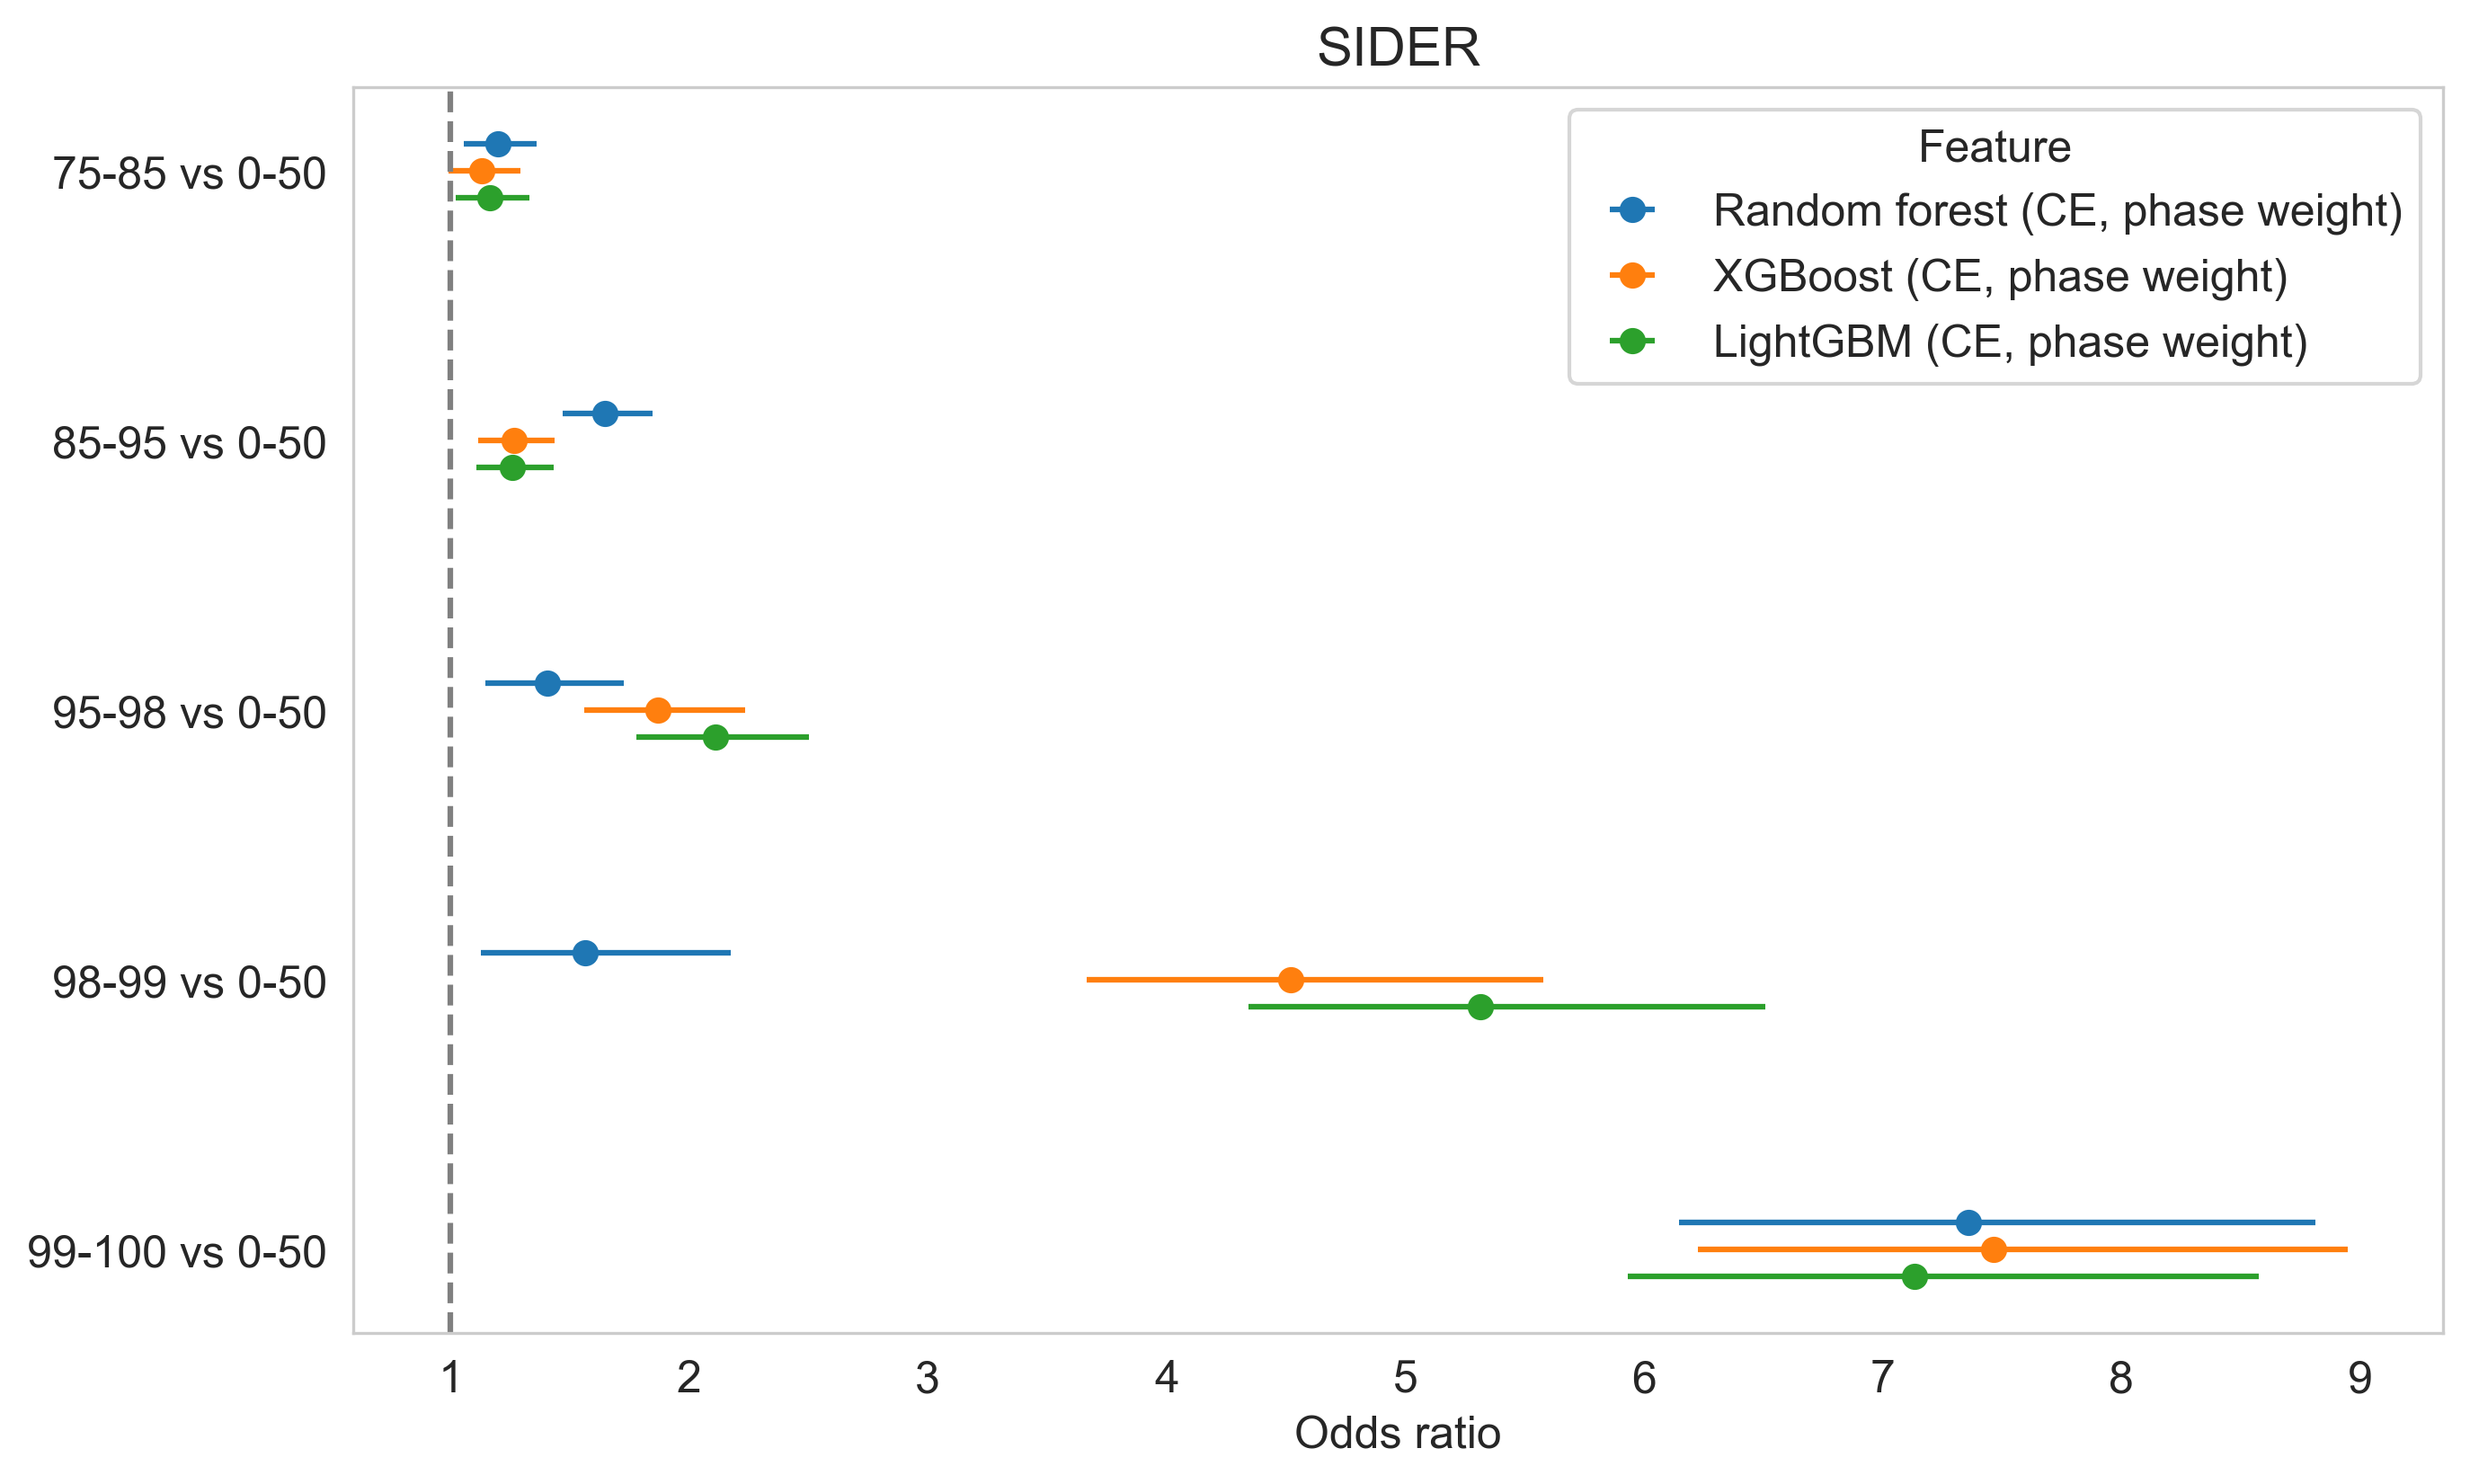

In [42]:
df = pd.read_excel('./Models/Architecture/results_rf_xgb_lgb.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['out_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for feature in features:
    subset = plot_df[plot_df['Feature'] == feature]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('SIDER')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

## P vs ML-GPS

In [43]:
hold_df = pd.DataFrame()
out_df = pd.DataFrame()

cols = ['LR (L2G + Clinical + P)','GB (CE, phase weight)']

#

for file_name in cols:
    hold = pd.read_pickle(f'./Models/Architecture/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold['model'] = file_name
    hold_df = pd.concat([hold_df,hold])
    
    out = pd.read_pickle(f'./Models/Architecture/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out['model'] = file_name
    out_df = pd.concat([out_df,out])

hold_df = pd.pivot(hold_df, index='g-p', columns='model', values='pred').reset_index()
hold_df = hold_df.merge(input[['g-p','indication','phase']])

out_df = pd.pivot(out_df, index='g-p', columns='model', values='pred').reset_index()
out_df = out_df.merge(output[['g-p','indication','phase']])

#

if True:
    n_bootstraps = 50 # Using fewer bootstraps to speed up calculations
    hold_auprc_results = {key: [] for key in cols}
    out_auprc_results = {key: [] for key in cols}

    for b in range(n_bootstraps):
        sample_df = hold_df.sample(n=len(hold_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            hold_auprc_results[col].append(auprc)

        sample_df = out_df.sample(n=len(out_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            out_auprc_results[col].append(auprc)

    hold_auprc_summary = {}
    out_auprc_summary = {}

    for col in cols:
        mean_auprc = np.mean(hold_auprc_results[col])
        original_stat = average_precision_score(hold_df['indication'], hold_df[col])
        lower_bound, upper_bound = bca_confidence_interval(hold_auprc_results[col], original_stat)
        hold_auprc_summary[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

        mean_auprc = np.mean(out_auprc_results[col])
        original_stat = average_precision_score(out_df['indication'], out_df[col])
        lower_bound, upper_bound = bca_confidence_interval(out_auprc_results[col], original_stat)
        out_auprc_summary[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

    print(hold_auprc_summary)
    print(out_auprc_summary)

{'LR (L2G + Clinical + P)': '0.055 (0.052, 0.058)', 'GB (CE, phase weight)': '0.074 (0.070, 0.078)'}
{'LR (L2G + Clinical + P)': '0.060 (0.053, 0.063)', 'GB (CE, phase weight)': '0.082 (0.072, 0.088)'}


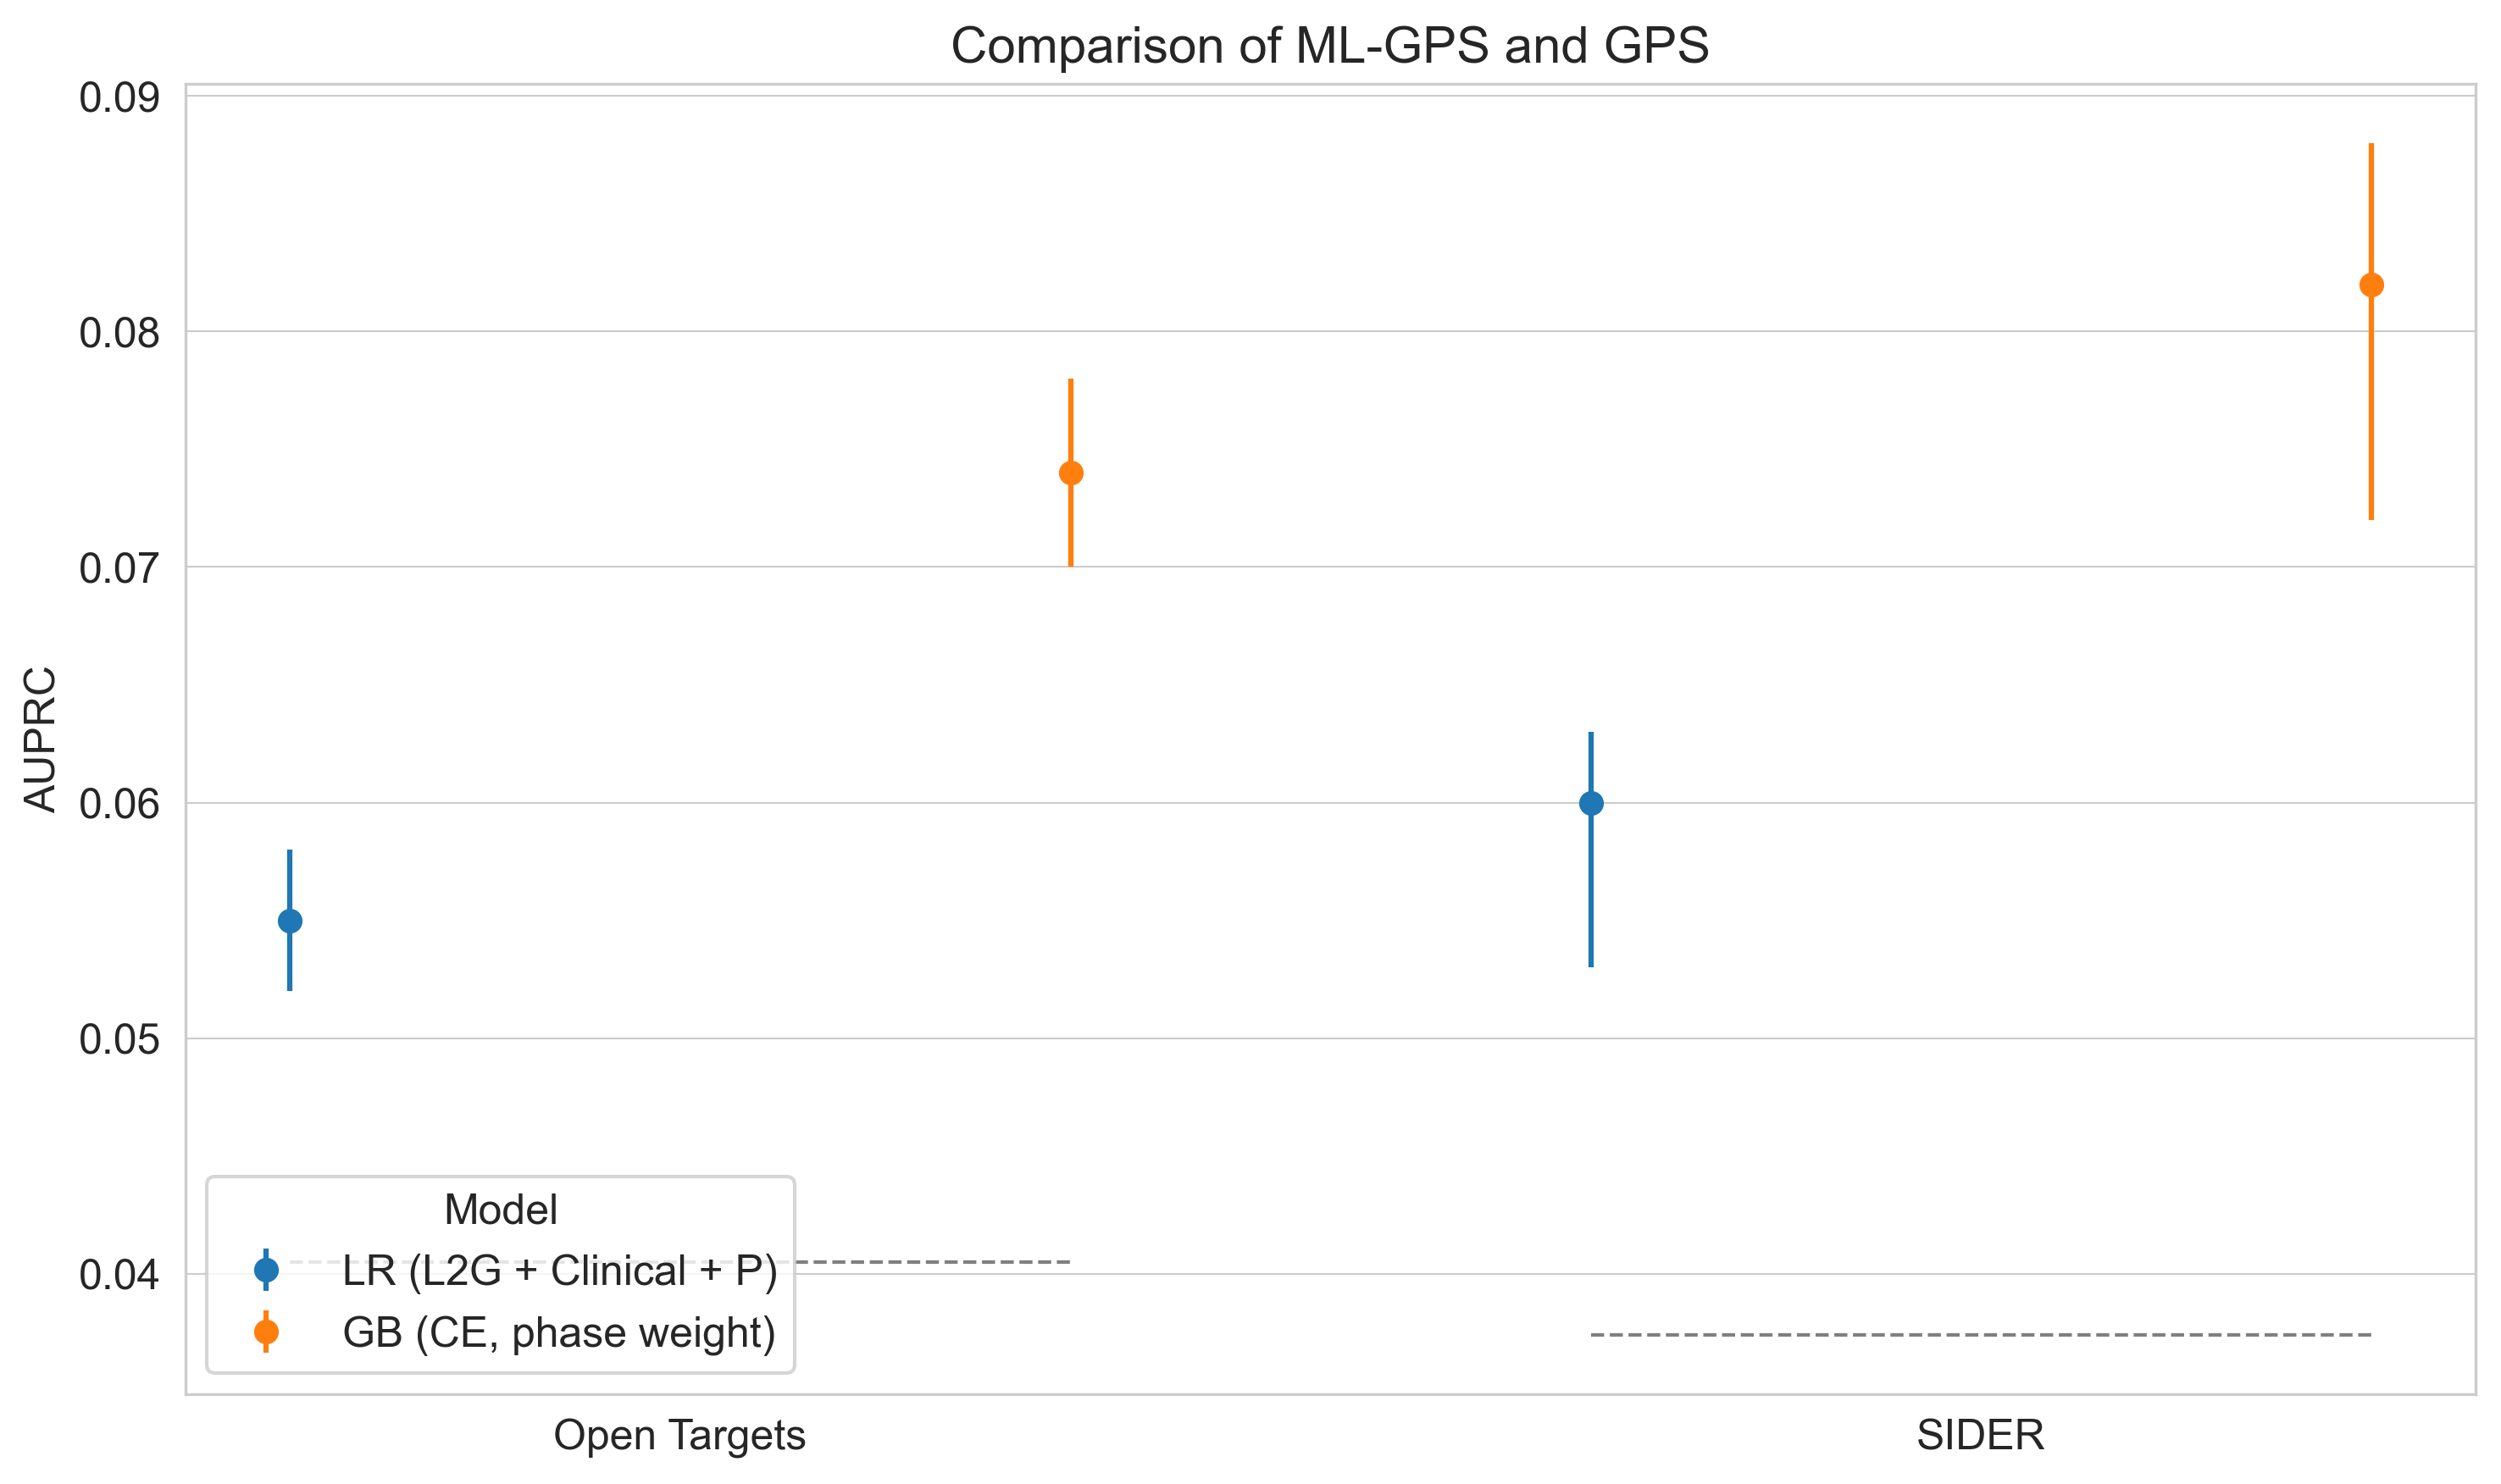

In [44]:
sns.set_style(style='whitegrid')

def parse_values(data):
    parsed_data = {}
    for key, value in data.items():
        mean, ci = value.split(' ', 1)
        ci_lower, ci_upper = ci.strip('()').split(', ')
        mean = float(mean)
        ci_lower = float(ci_lower)
        ci_upper = float(ci_upper)
        parsed_data[key] = (mean, (mean - ci_lower, ci_upper - mean))
    return parsed_data

parsed_hold = parse_values(hold_auprc_summary)
parsed_out = parse_values(out_auprc_summary)

# Setup for plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Define x-axis positions for the two groups
group_positions = [1, 2]  # For auprc_hold and auprc_out
width = 0.3  # Width of each bar/error bar

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_group(group_data, position, color):
    labels = list(group_data.keys())
    num_labels = len(labels)
    total_width = width * 2 * (num_labels - 1)
    start_x = position - total_width / 2

    xpos = []
    for i, label in enumerate(labels):
        # Use the standard Matplotlib colors, cycling through if there are more models than colors
        color = default_colors[i % len(default_colors)]
        x = start_x + i * width * 2  # Adjust the spacing here
        xpos.append(x)
        mean, ci = group_data[label]
        ax.errorbar(x, mean, yerr=[[ci[0]], [ci[1]]], fmt='o', color=color, label=label if position == 1 else "_nolegend_")
    return min(xpos), max(xpos)

# Plot each group and get x positions for lines
xmin_hold, xmax_hold = plot_group(parsed_hold, group_positions[0], default_colors)
xmin_out, xmax_out = plot_group(parsed_out, group_positions[1], default_colors)

# Plot horizontal lines
ax.hlines(hold_df['indication'].mean(), xmin_hold, xmax_hold, colors='grey', linestyles='dashed', linewidth=1)
ax.hlines(out_df['indication'].mean(), xmin_out, xmax_out, colors='grey', linestyles='dashed', linewidth=1)

# Customizing the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(['Open Targets', 'SIDER'])
ax.set_ylabel('AUPRC')

# Generate legend without duplicates
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title='Model', loc='lower left')

plt.title('Comparison of ML-GPS and GPS')
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.grid(False, which='both', axis='x') # Disable vertical grid lines

plt.tight_layout()
plt.show()


In [45]:
results_df = []

percentiles = [(0.75,0.85),(0.85,0.95),(0.95,0.98),(0.98,0.99),(0.99,1.00)]

for file_name in ['LR (L2G + Clinical + P)','GB (CE, phase weight)']:

    hold = pd.read_pickle(f'./Models/Architecture/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold = hold.merge(input[['g-p','indication','phase','oe','BI','CV','EM']])
    out = pd.read_pickle(f'./Models/Architecture/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out = out.merge(output[['g-p','indication','phase','oe','BI','CV','EM']])

    hold_results = {
        "features": file_name,
        "hold_prop": hold['indication'].mean(),
        "hold_or": or_top_bottom(hold,percentiles),
        "hold_or_phase": or_phase(hold)
    }

    out_results = {
        "out_prop": out['indication'].mean(),
        "out_or": or_top_bottom(out,percentiles)
    }

    if file_name != 'LR':
        results_df.append({**hold_results, **out_results})
    else:
        results_df.append({**hold_results, **out_results})

temp = pd.DataFrame(results_df)
temp['features'] = ['Original GPS approximation','ML-GPS']
temp.to_excel('./Models/Architecture/results_mlgps_baseline.xlsx')

Optimization terminated successfully.
         Current function value: 0.159700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.163970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038674
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039953
  

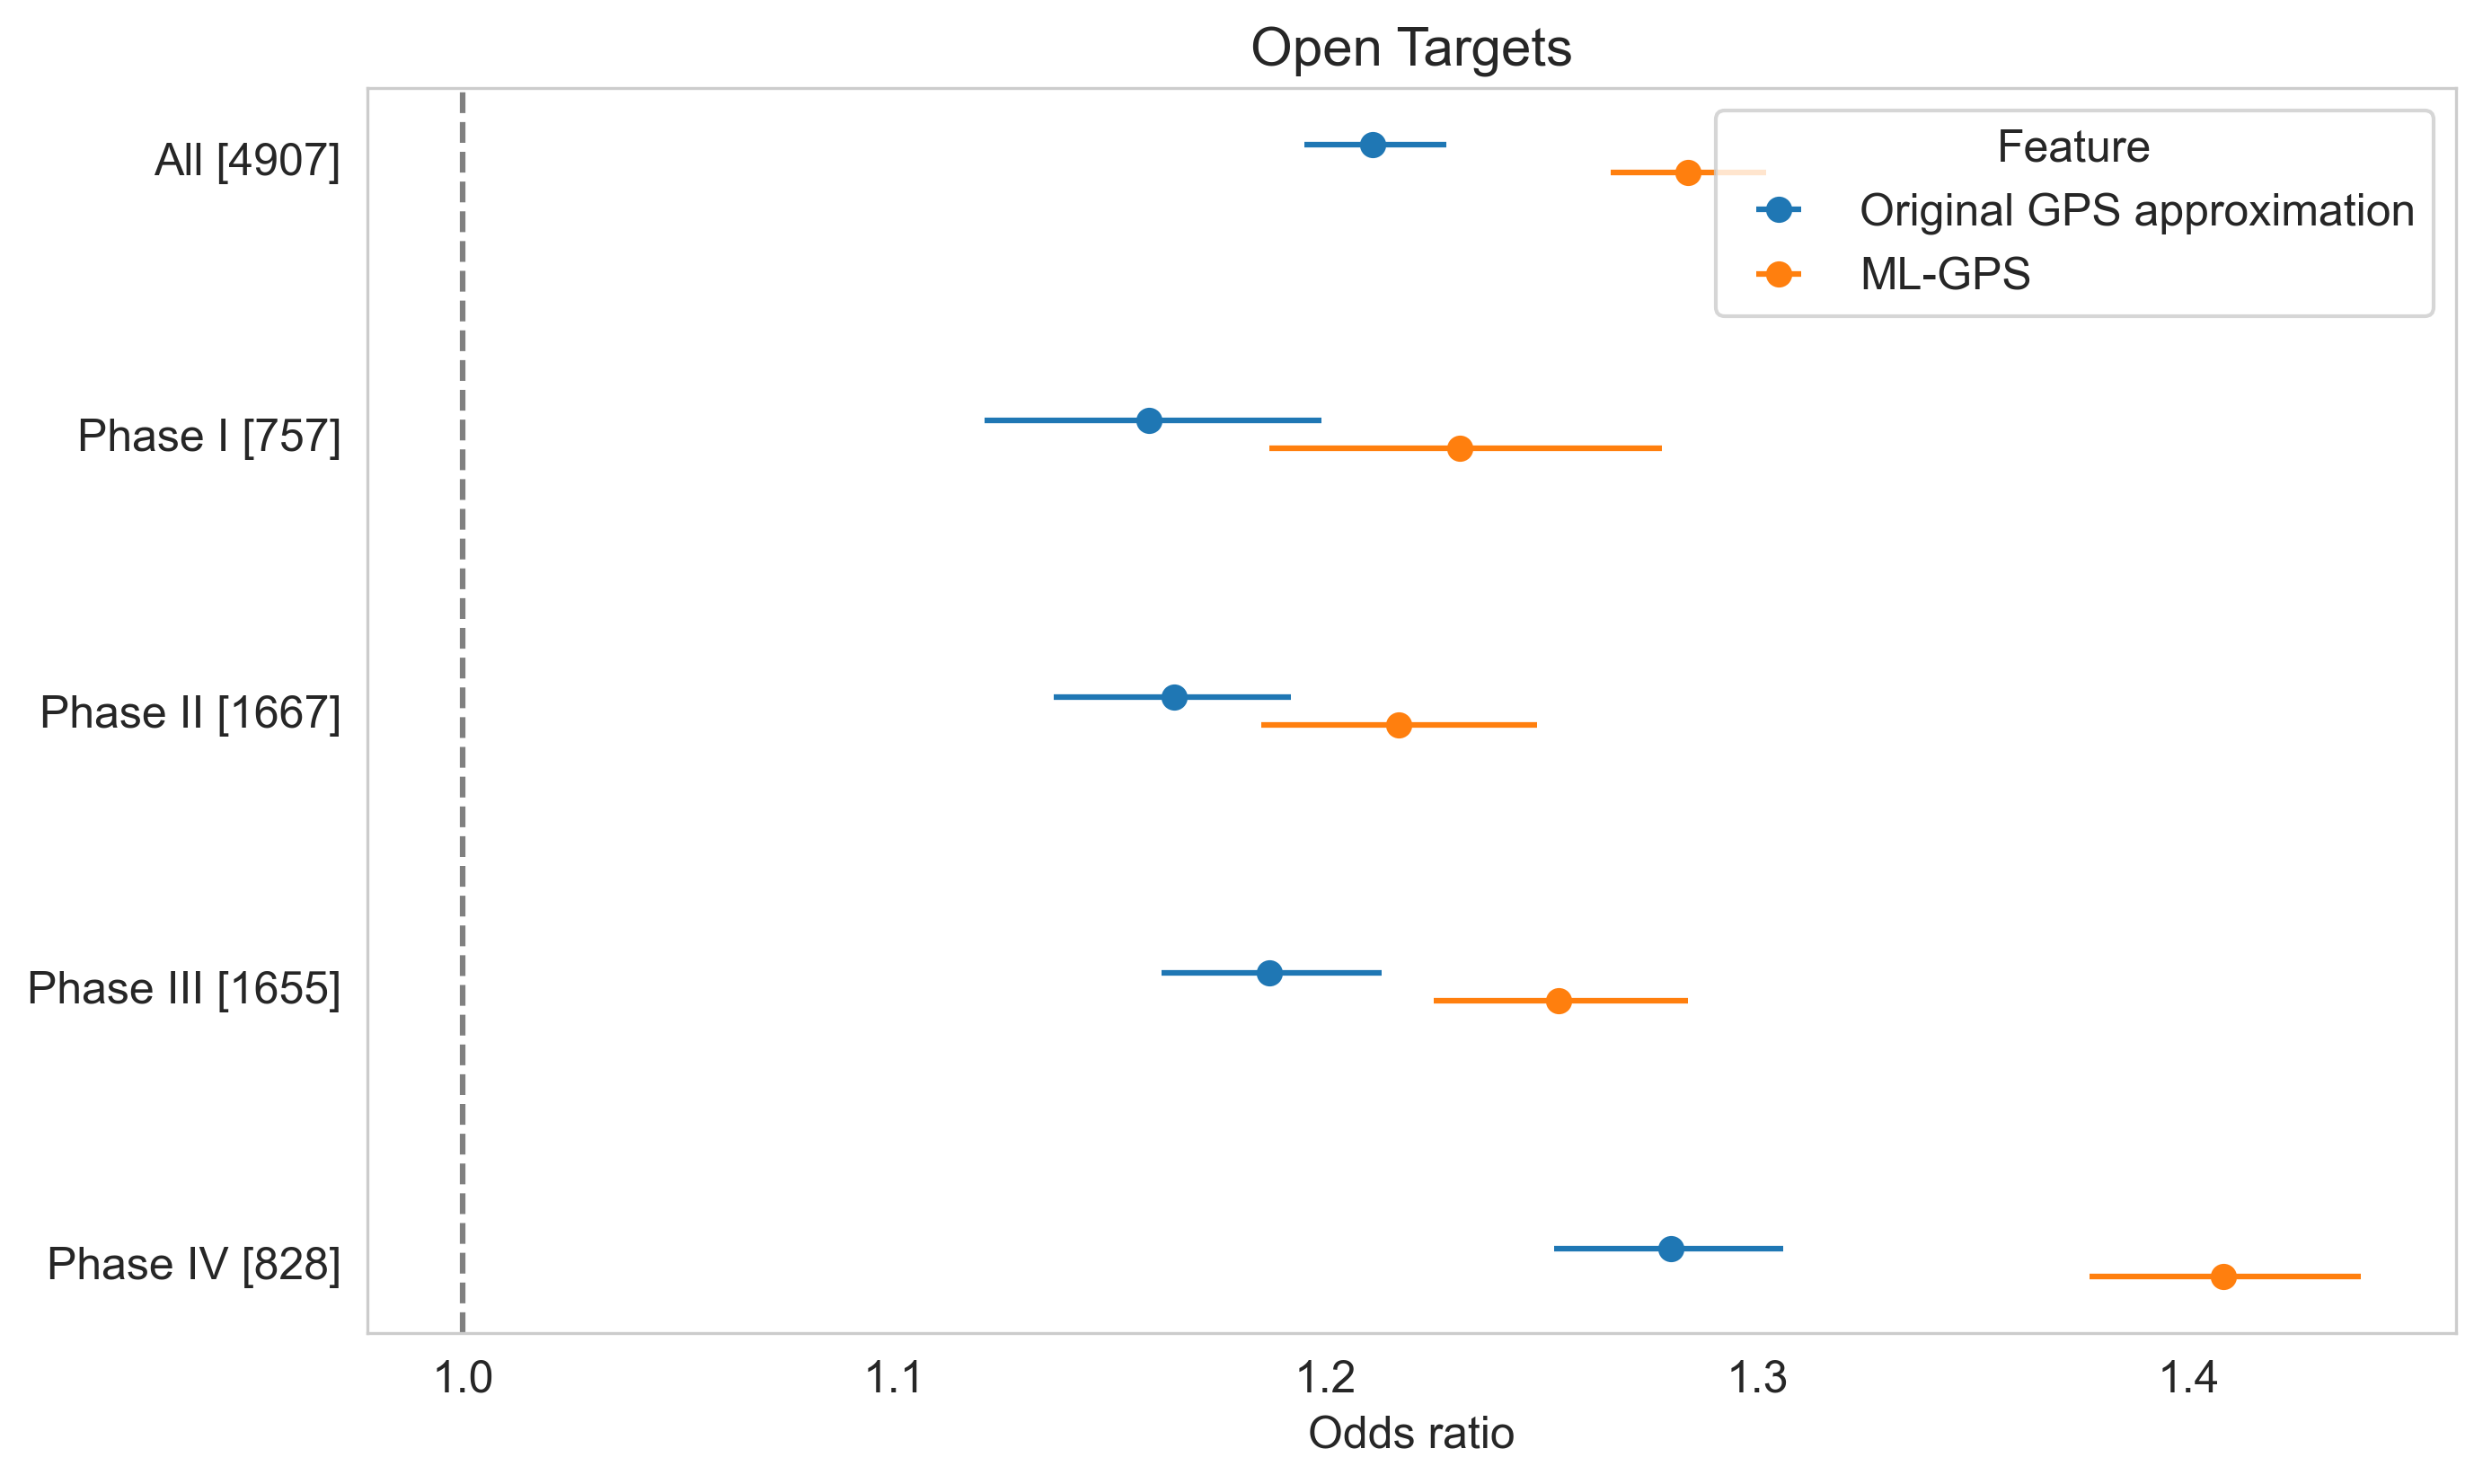

In [46]:
df = pd.read_excel('./Models/Architecture/results_mlgps_baseline.xlsx')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 1','Phase I')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 2','Phase II')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 3','Phase III')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 4','Phase IV')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_phase'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for feature in features:
    subset = plot_df[plot_df['Feature'] == feature]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

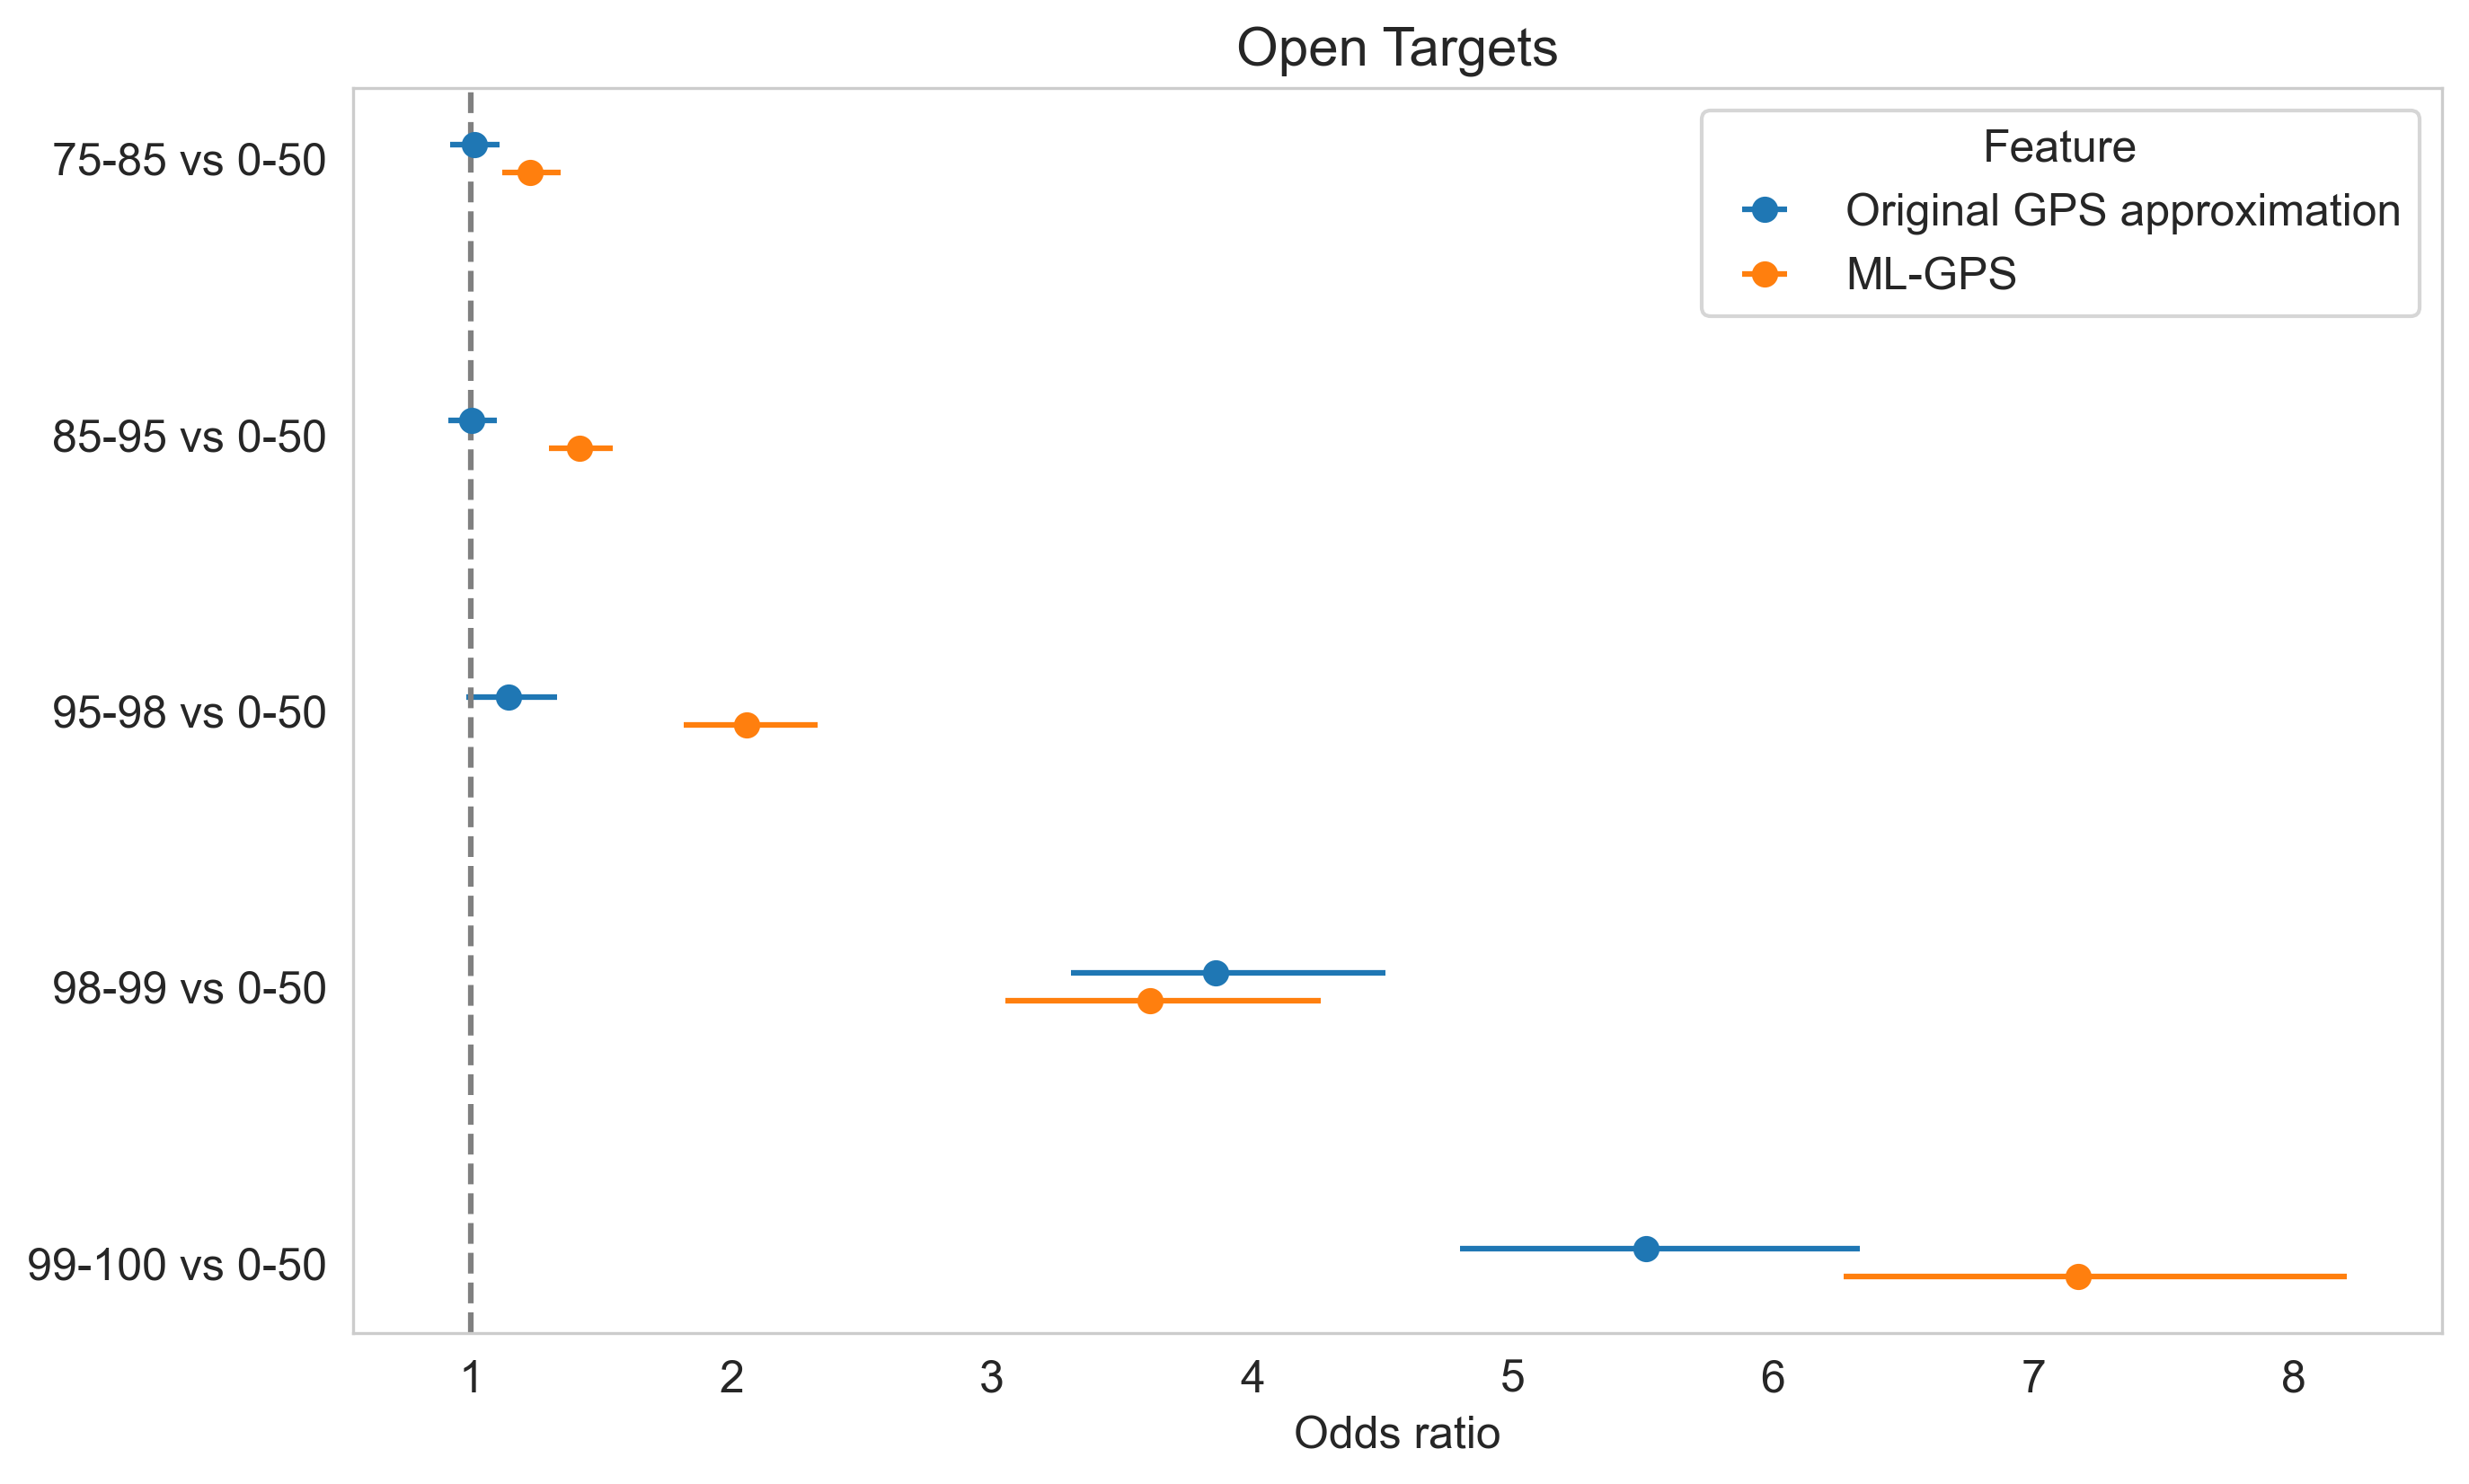

In [47]:
df = pd.read_excel('./Models/Architecture/results_mlgps_baseline.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for feature in features:
    subset = plot_df[plot_df['Feature'] == feature]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

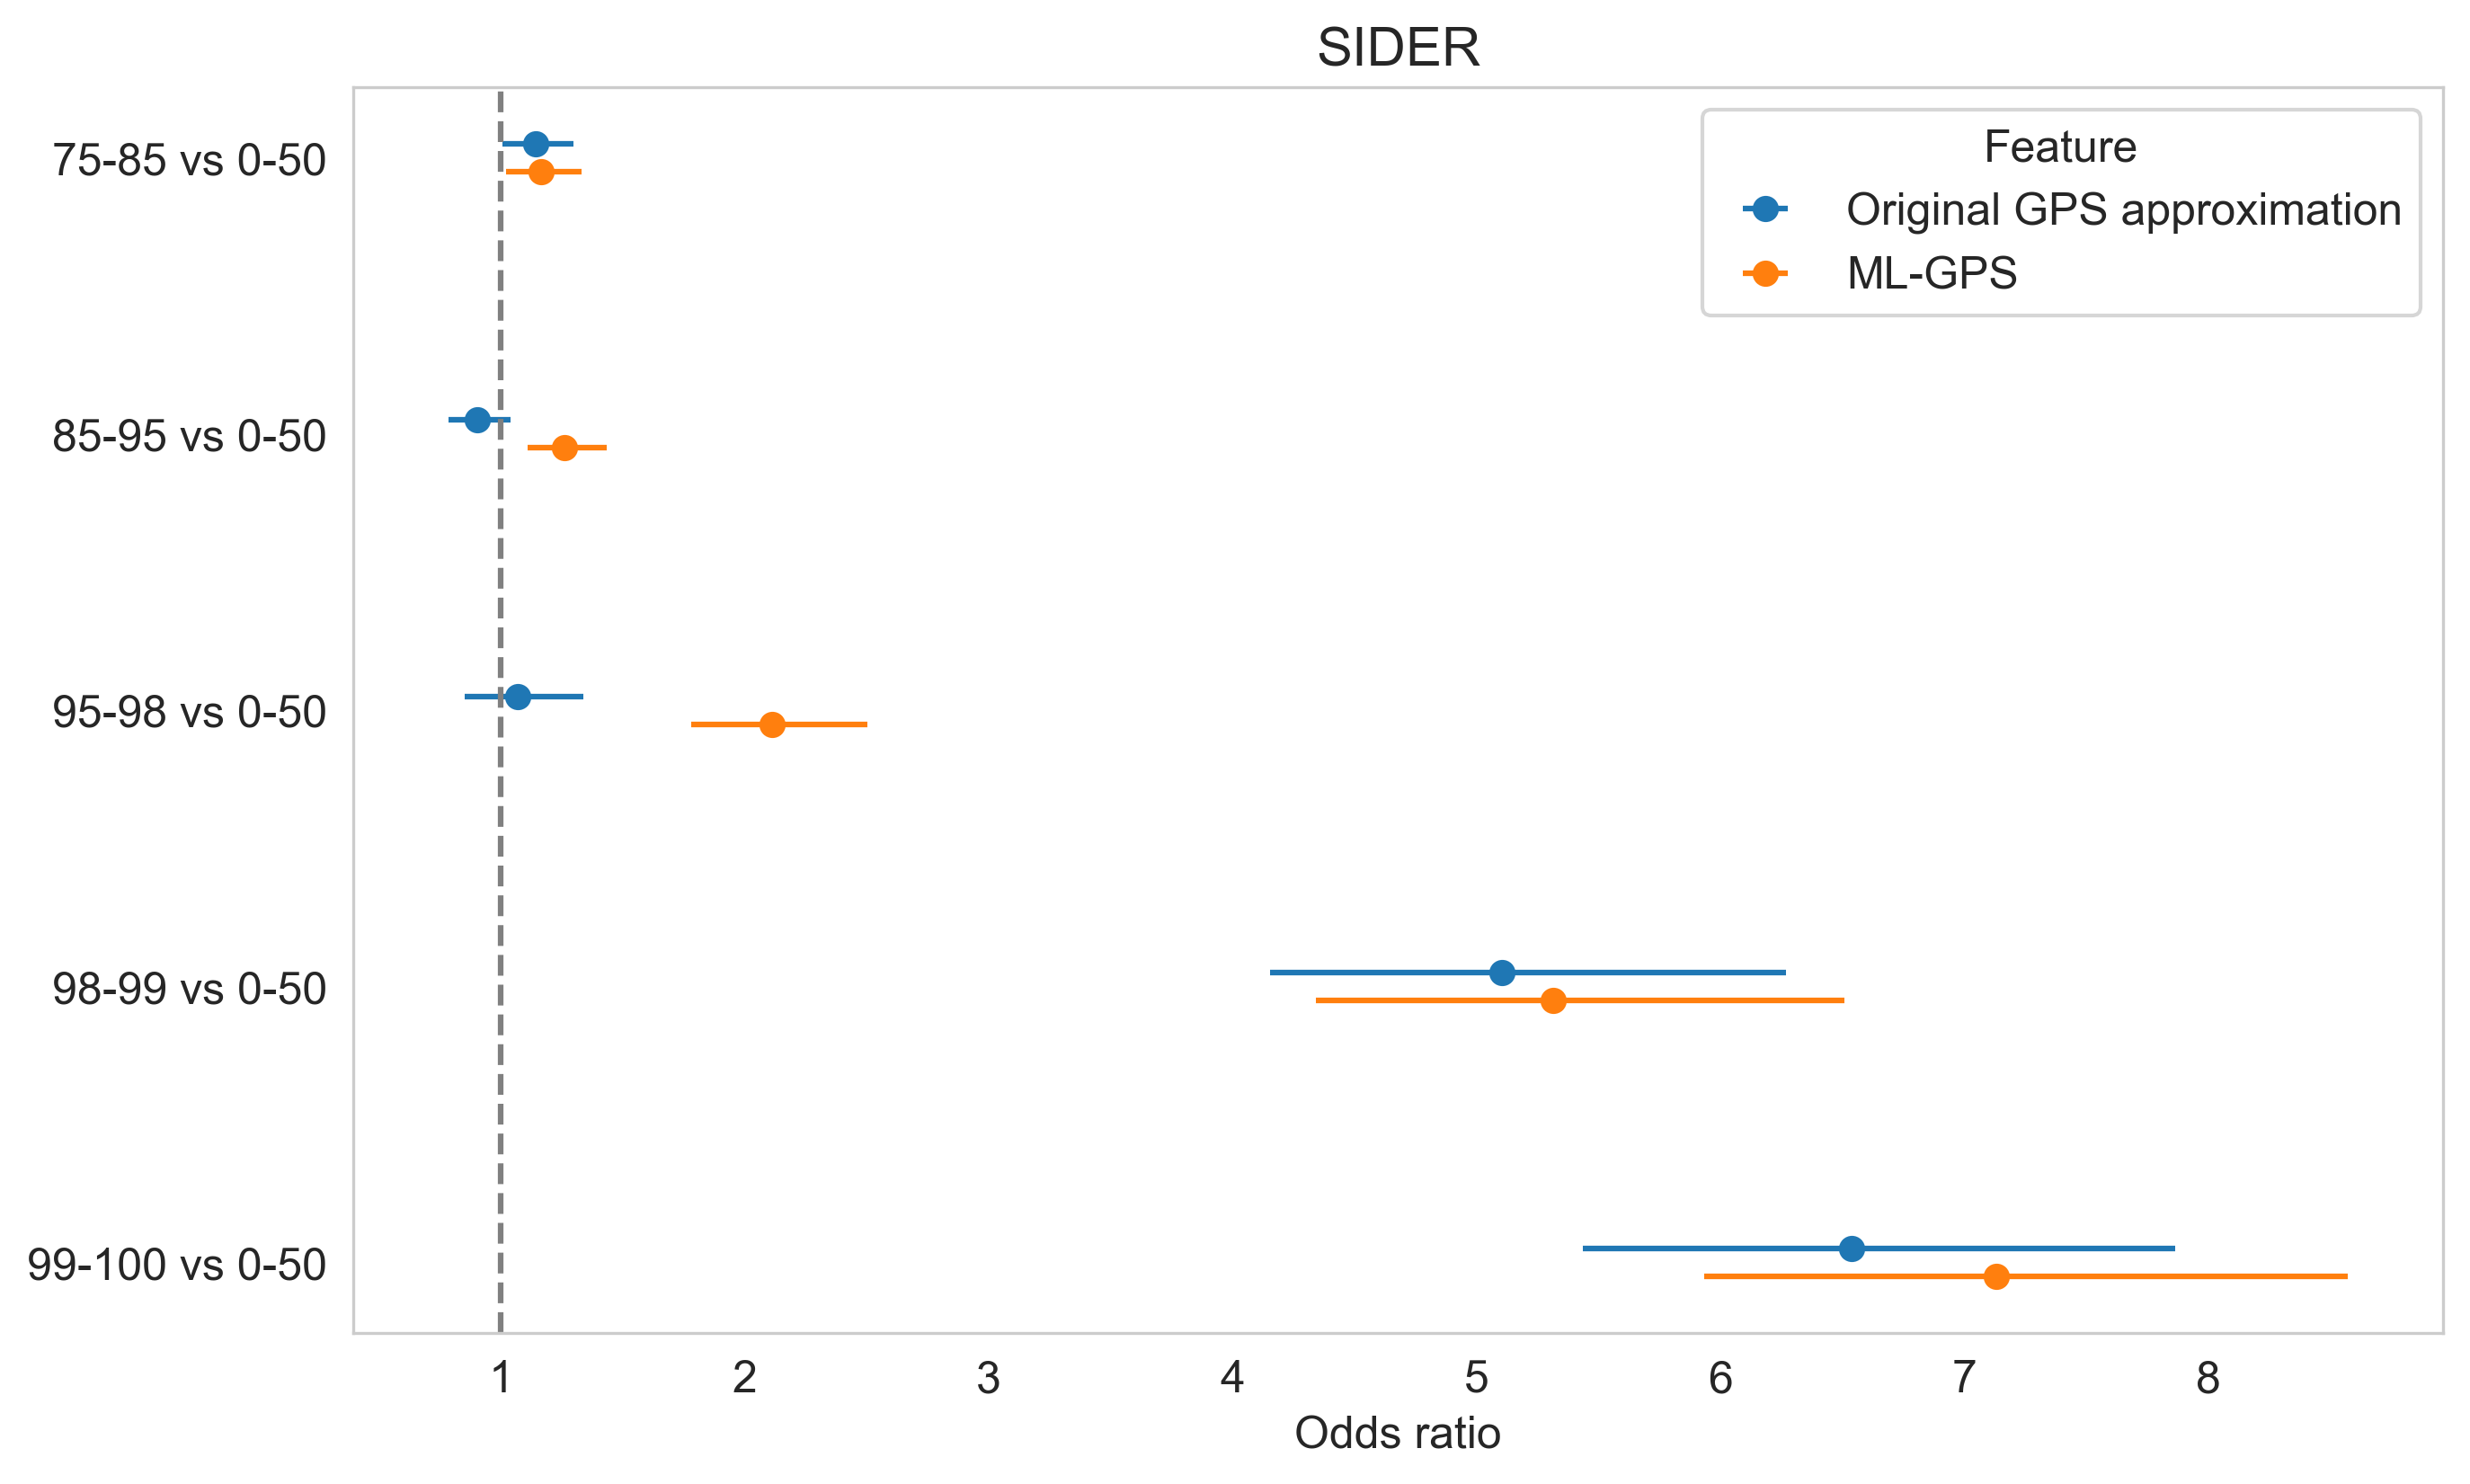

In [48]:
df = pd.read_excel('./Models/Architecture/results_mlgps_baseline.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['out_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for feature in features:
    subset = plot_df[plot_df['Feature'] == feature]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('SIDER')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

## Feature comparison

In [49]:
input_df = input.copy()

input_df['weight'] = 1
input_df.loc[input_df['phase'] == 2, 'weight'] = 1/0.63
input_df.loc[input_df['phase'] == 3, 'weight'] = 1/(0.63*0.31)
input_df.loc[input_df['phase'] == 4, 'weight'] = 1/(0.63*0.31*0.58)

ic_1 = ['l2g_score']
ic_2 = ['EVA_count','HGMD_count','OMIM']
ic_3 = ['EVA_count','HGMD_count','OMIM','l2g_score']
ic_4 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z']
ic_5 = ['EVA_count','HGMD_count','OMIM','l2g_score','p_g_z','p_e_z','p_b_z','c_g_z','c_e_z','c_b_z','b_g_z','b_e_z','b_b_z']

for input_cols, file_name in [[ic_1,'L2G'],[ic_2,'Clinical'],[ic_3,'L2G + Clinical'],[ic_4,'L2G + Clinical + P'],[ic_5,'L2G + Clinical + PCB']]:

    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['indication']
    id_input = input_df['g-p']
    weight_input = input_df['weight']
    
    X_pred = agp[input_cols]
    ids_pred = []
    pred_predictions = []

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []
    results = []

    feat_name = []
    imp_gain = []
    imp_split = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]
        weight_outer = weight_input.iloc[train_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output.loc[~output['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
            weight_train, weight_val = weight_outer.iloc[inner_train_index], weight_outer.iloc[inner_test_index]

            # LightGBM model training
            train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train)
            val_data = lgb.Dataset(X_val, label=y_val, weight=weight_val, reference=train_data)

            params = {
                        'objective': 'binary',
                        'boosting_type': 'goss',
                        'num_boost_round': 1000,
                        'learning_rate': 0.01,
                        'num_leaves': 30,
                        'max_depth': -1,
                        'feature_fraction': 1,
                        'min_data_in_leaf': 50,
                        'verbose': -1,
                        'device_type': 'cpu',
                        'num_threads': -1
            }
            
            gbm = lgb.train(params, train_data, valid_sets=val_data, callbacks=[lgb.early_stopping(stopping_rounds=10)])

            feat_name.append(gbm.feature_name())
            imp_gain.append(gbm.feature_importance(importance_type='gain'))
            imp_split.append(gbm.feature_importance(importance_type='split'))
            
            # Predictions

            val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
            hold_pred = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
            out_pred = gbm.predict(X_output, num_iteration=gbm.best_iteration)

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())
    
            if file_name in ['L2G + Clinical + P','L2G + Clinical + PCB']:
                pred_pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
                pred_predictions.append(pred_pred)
                ids_pred.append(agp['g-p'].to_list())

            # Metrics
            val_loss = log_loss(y_val, val_pred)
            holdout_loss = log_loss(y_holdout, hold_pred)
            holdout_prop = y_holdout.mean()
            holdout_auprc = average_precision_score(y_holdout, hold_pred)
            output_loss = log_loss(y_output, out_pred)
            output_prop = y_output.mean()
            output_auprc = average_precision_score(y_output, out_pred)

            results_dict = {
                'outer_fold':ofold,
                'inner_fold':ifold,
                'val_loss': val_loss,
                'holdout_loss': holdout_loss,
                'holdout_prop': holdout_prop,
                'holdout_auprc': holdout_auprc,
                'output_loss': output_loss,
                'output_prop': output_prop,
                'output_auprc': output_auprc
            }

            # Store results
            results.append(results_dict)
            print(results_dict)

        ofold += 1

    # Convert results to a format suitable for analysis
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'./Models/Features/metrics_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),'pred':flatten(flatten(holdout_predictions))})
    hold_pred.to_pickle(f'./Models/Features/hold_{file_name}.pkl')

    #

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),'pred':flatten(flatten(output_predictions))})
    out_pred.to_pickle(f'./Models/Features/out_{file_name}.pkl')

    #
    
    if file_name in ['L2G + Clinical + P','L2G + Clinical + PCB']:
        pred_pred = pd.DataFrame({'g-p':flatten(flatten(ids_pred)),'pred':flatten(flatten(pred_predictions))})
        pred_pred = pred_pred.groupby('g-p').mean().reset_index()
        pred_pred.to_pickle(f'./Models/Features/pred_{file_name}.pkl')

    #

    importance = pd.DataFrame({'outer_fold':extend(ofold_list, len(input_cols)),'inner_fold':extend(ifold_list, len(input_cols)),'feature':flatten(feat_name),'imp_gain':flatten(imp_gain),'imp_split':flatten(imp_split)})
    importance.to_pickle(f'./Models/Features/importance_{file_name}.pkl')
    

/var/folders/yr/y10yd09d6pg7yv_8hdtwsgf80000gn/T/ipykernel_43092/1943147392.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5873015873015872' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[input_df['phase'] == 2, 'weight'] = 1/0.63
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


1 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.393741
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.220159368103996, 'holdout_loss': 0.22495266756539584, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.047458928893865535, 'output_loss': 0.20097575425146294, 'output_prop': 0.028540136580337584, 'output_auprc': 0.03125144249407197}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.395437
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.2233658381267982, 'holdout_loss': 0.2246962432829417, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.04623157259360678, 'output_loss': 0.20042412796746814, 'output_prop': 0.028540136580337584, 'output_auprc': 0.031220306682652188}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.423142
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.22393731861527078, 'holdout_loss': 0.22188562949973983, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.046076771122553754, 'output_loss': 0.19736679690635792, 'output_prop': 0.028540136580337584, 'output_auprc': 0.031088047922438272}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.39904
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.22051761548410728, 'holdout_loss': 0.22411297343933254, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.04643860967234523, 'output_loss': 0.1998294399031818, 'output_prop': 0.028540136580337584, 'output_auprc': 0.03090339103612182}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.389672
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.22144614220521555, 'holdout_loss': 0.22556655568165468, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.046143238306263296, 'output_loss': 0.20168283541797077, 'output_prop': 0.028540136580337584, 'output_auprc': 0.030817157948315178}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.408524
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.2252109935580562, 'holdout_loss': 0.22168029754800397, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.04788430815804052, 'output_loss': 0.20101815258667827, 'output_prop': 0.028790476498560476, 'output_auprc': 0.030337134870925996}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.391873
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.22335997126289323, 'holdout_loss': 0.22372256108350275, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.0483329022548353, 'output_loss': 0.20319349867390302, 'output_prop': 0.028790476498560476, 'output_auprc': 0.030488277231505354}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.423033
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.22509036836523727, 'holdout_loss': 0.22040349511070606, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.046466197098163735, 'output_loss': 0.19958961250906582, 'output_prop': 0.028790476498560476, 'output_auprc': 0.029951305941047557}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.399831
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.22220014732639015, 'holdout_loss': 0.2229610032916272, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.04804738209349717, 'output_loss': 0.20204027089244908, 'output_prop': 0.028790476498560476, 'output_auprc': 0.030059136101424404}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[217]	valid_0's binary_logloss: 0.389611
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.22266668585128524, 'holdout_loss': 0.2240850262323782, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.04744169737232495, 'output_loss': 0.20355262470356864, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03028025214174569}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.40927
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.22420065150118057, 'holdout_loss': 0.22430094498938316, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.048218050109887715, 'output_loss': 0.1997517729954378, 'output_prop': 0.028826621094379775, 'output_auprc': 0.030356108586911717}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.392995
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.22044470074123512, 'holdout_loss': 0.22608098632945045, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.048985838421743214, 'output_loss': 0.20158355837839376, 'output_prop': 0.028826621094379775, 'output_auprc': 0.030609833123992396}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.410255
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.22215156458204188, 'holdout_loss': 0.22431172646921582, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.04775130306683582, 'output_loss': 0.19982305393046568, 'output_prop': 0.028826621094379775, 'output_auprc': 0.03034275773421515}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[373]	valid_0's binary_logloss: 0.39931
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.22045010408473584, 'holdout_loss': 0.2248176958158356, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.048833363424842784, 'output_loss': 0.20017717527394668, 'output_prop': 0.028826621094379775, 'output_auprc': 0.030490490421862197}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.389764
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.22126481911108617, 'holdout_loss': 0.22638493599923484, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.048503520618076425, 'output_loss': 0.20210176964505058, 'output_prop': 0.028826621094379775, 'output_auprc': 0.030800982263663092}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.409771
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.22539405267713655, 'holdout_loss': 0.22030580508530576, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.045943818461119855, 'output_loss': 0.20007428653795634, 'output_prop': 0.02847387747213812, 'output_auprc': 0.031123417662149197}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.393491
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.22190473745951167, 'holdout_loss': 0.2224514693583047, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04707084099744074, 'output_loss': 0.20259357325203292, 'output_prop': 0.02847387747213812, 'output_auprc': 0.030713012700891194}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.407883
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.2251145653938778, 'holdout_loss': 0.22030984594244743, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04899973625786941, 'output_loss': 0.20025712604081417, 'output_prop': 0.02847387747213812, 'output_auprc': 0.032348888744026603}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.412487
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.22497284043308907, 'holdout_loss': 0.21963573517101267, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04880515991138262, 'output_loss': 0.1994569038917221, 'output_prop': 0.02847387747213812, 'output_auprc': 0.031098490830076125}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.389487
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.2224823419149835, 'holdout_loss': 0.22250189144257754, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04970425452478524, 'output_loss': 0.20264222135629445, 'output_prop': 0.02847387747213812, 'output_auprc': 0.031423093713385954}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.4084
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.2260429848083584, 'holdout_loss': 0.2221935974847505, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.044458984941658744, 'output_loss': 0.19964502829213027, 'output_prop': 0.02763323745192463, 'output_auprc': 0.030125711370536774}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.393763
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.22294133431059232, 'holdout_loss': 0.22438904646290014, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.043854859139571614, 'output_loss': 0.20223729892034925, 'output_prop': 0.02763323745192463, 'output_auprc': 0.03029581571205711}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.408281
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.22627381718186523, 'holdout_loss': 0.22233542403238177, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.04452327162051737, 'output_loss': 0.19974076447829747, 'output_prop': 0.02763323745192463, 'output_auprc': 0.030503536360294726}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.408202
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.22459363916345834, 'holdout_loss': 0.2224400581254498, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.043751872789661646, 'output_loss': 0.19964317014073535, 'output_prop': 0.02763323745192463, 'output_auprc': 0.030314319430737643}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[857]	valid_0's binary_logloss: 0.40001
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.22183618566452928, 'holdout_loss': 0.22269983198537183, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.04626541251801752, 'output_loss': 0.19974069523094085, 'output_prop': 0.02763323745192463, 'output_auprc': 0.032659492362336846}
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.394275
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.21965450413265789, 'holdout_loss': 0.22398595847665512, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.04925475493920634, 'output_loss': 0.19921553890295976, 'output_prop': 0.028540136580337584, 'output_auprc': 0.038767295457467}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.390826
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.222041360154348, 'holdout_loss': 0.2237867357591252, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.04887326437831713, 'output_loss': 0.19885092110604105, 'output_prop': 0.028540136580337584, 'output_auprc': 0.038680800549988126}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.421066
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.22264598165552799, 'holdout_loss': 0.22070428763762465, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.04926615557508005, 'output_loss': 0.19535856943640093, 'output_prop': 0.028540136580337584, 'output_auprc': 0.03878211991862323}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[440]	valid_0's binary_logloss: 0.396598
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.2199078722387384, 'holdout_loss': 0.22319172349002533, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.04993541303375966, 'output_loss': 0.19811419546888595, 'output_prop': 0.028540136580337584, 'output_auprc': 0.039292572698707166}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[444]	valid_0's binary_logloss: 0.381894
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.21875527409651785, 'holdout_loss': 0.22445603582493115, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05020399515251708, 'output_loss': 0.1996236708854072, 'output_prop': 0.028540136580337584, 'output_auprc': 0.038655689608386584}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.407842
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.22463454241914513, 'holdout_loss': 0.2204800073493752, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05481769925042639, 'output_loss': 0.19896897772448052, 'output_prop': 0.028790476498560476, 'output_auprc': 0.038195861918404655}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.386239
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.22176059271292725, 'holdout_loss': 0.2227632864782637, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.052615533229892174, 'output_loss': 0.2012365442913266, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03857402199836904}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.420726
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.22372893705109856, 'holdout_loss': 0.2189689862159767, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.054619008840558265, 'output_loss': 0.19716862679175415, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03876621697805037}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	valid_0's binary_logloss: 0.396195
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.22112814476838075, 'holdout_loss': 0.22158452601425815, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.054709976182702444, 'output_loss': 0.19992240685495102, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03884788725492702}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.382013
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.21992968613300423, 'holdout_loss': 0.22294394604629705, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.054238785754943335, 'output_loss': 0.20149979981835237, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03972496002110525}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.408036
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.2234870884948849, 'holdout_loss': 0.2229419043194237, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.058169504278362226, 'output_loss': 0.1978792260233175, 'output_prop': 0.028826621094379775, 'output_auprc': 0.03932906340986669}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.391156
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.21916706475205602, 'holdout_loss': 0.22466040420878614, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.05864239995954319, 'output_loss': 0.19969344062069294, 'output_prop': 0.028826621094379775, 'output_auprc': 0.03811977017325162}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.407366
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.22091131956337334, 'holdout_loss': 0.22262546074887957, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.060914446784728724, 'output_loss': 0.19746379786721194, 'output_prop': 0.028826621094379775, 'output_auprc': 0.038414982682373804}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.396345
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.21998629944647435, 'holdout_loss': 0.22377577786753802, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06044916731179116, 'output_loss': 0.19874065671265487, 'output_prop': 0.028826621094379775, 'output_auprc': 0.038859660859559816}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[418]	valid_0's binary_logloss: 0.382304
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.2187733632695135, 'holdout_loss': 0.22497285948932855, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.060578060119912056, 'output_loss': 0.20023002059791573, 'output_prop': 0.028826621094379775, 'output_auprc': 0.03889534041549735}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.407895
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.22451991173620317, 'holdout_loss': 0.21913429893688424, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04925308302736815, 'output_loss': 0.1986312512148353, 'output_prop': 0.02847387747213812, 'output_auprc': 0.03843405331507639}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.390979
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.2201513377476517, 'holdout_loss': 0.22095049911867537, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04943039947149119, 'output_loss': 0.20050058789286535, 'output_prop': 0.02847387747213812, 'output_auprc': 0.037737297252305985}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.403588
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.22347155172820557, 'holdout_loss': 0.21930650314233513, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04961726996523644, 'output_loss': 0.19873781727016415, 'output_prop': 0.02847387747213812, 'output_auprc': 0.0377139438150579}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.40949
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.22422603678841443, 'holdout_loss': 0.2187572128840911, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.04978451607767975, 'output_loss': 0.1979785537578523, 'output_prop': 0.02847387747213812, 'output_auprc': 0.03781422641444533}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[351]	valid_0's binary_logloss: 0.382692
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.21997839892529253, 'holdout_loss': 0.22140411269360172, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.049204329941025096, 'output_loss': 0.20111651932333963, 'output_prop': 0.02847387747213812, 'output_auprc': 0.037498486264755417}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.407506
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.22564230796837156, 'holdout_loss': 0.22052817628418728, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05282407730425594, 'output_loss': 0.1977987748597733, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04397299408648122}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.39107
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.22151580824455414, 'holdout_loss': 0.222392677485985, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.054063345327539966, 'output_loss': 0.19983386289841054, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04397864929385052}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.403843
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.2249134510438534, 'holdout_loss': 0.2206515841335508, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05350631864441749, 'output_loss': 0.1979072894782494, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0433987353831596}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[259]	valid_0's binary_logloss: 0.405568
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.2236315406865324, 'holdout_loss': 0.2206413794561361, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05282389243276017, 'output_loss': 0.1978388677386147, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04256392049663379}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.399013
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.22126834301527154, 'holdout_loss': 0.22114872348511502, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05299285145266352, 'output_loss': 0.19829541344207585, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04256041731999854}
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.391967
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.21829503011163082, 'holdout_loss': 0.2223759123391886, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05712334830056992, 'output_loss': 0.19738718637209943, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04260035595108941}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.388958
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.220554944409896, 'holdout_loss': 0.22206393487262638, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.056667783738476925, 'output_loss': 0.19684330260854008, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04234300140458668}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.418227
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.22154695311606995, 'holdout_loss': 0.21932950931464, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.05573559229922761, 'output_loss': 0.19346045017322544, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04183642675152439}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.393609
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.21826451482008907, 'holdout_loss': 0.2213304255502017, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.057805736547157385, 'output_loss': 0.19618828697769658, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04193528497732231}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.378953
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.21706167810410718, 'holdout_loss': 0.22268236992360763, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.056176379487305826, 'output_loss': 0.19765885171055853, 'output_prop': 0.028540136580337584, 'output_auprc': 0.04068394200134954}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.403809
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.22293023928081535, 'holdout_loss': 0.21919955197927643, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06215503960333384, 'output_loss': 0.19721683702790785, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03986807954787742}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.3832
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.21986075957752738, 'holdout_loss': 0.2211522336246517, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.05881435131465116, 'output_loss': 0.1991379446717222, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03925334643737079}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.417533
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.22251012458102282, 'holdout_loss': 0.21771477136663886, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06024080928693416, 'output_loss': 0.19556806796289228, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03939750236878866}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[313]	valid_0's binary_logloss: 0.393476
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.21937071269128205, 'holdout_loss': 0.22016114549981688, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.059603221782501915, 'output_loss': 0.19786134124231047, 'output_prop': 0.028790476498560476, 'output_auprc': 0.040825965318278375}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.37919
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.21822753665204142, 'holdout_loss': 0.22139607882933007, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06106098869249403, 'output_loss': 0.19932580892469498, 'output_prop': 0.028790476498560476, 'output_auprc': 0.03926173096672481}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.404365
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.2219946805575766, 'holdout_loss': 0.22154658444747174, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06349231951629535, 'output_loss': 0.19612263781099273, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04203006133523321}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.388968
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.218011409995034, 'holdout_loss': 0.22330650121565912, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06502615772588065, 'output_loss': 0.1982628188202612, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04233683494225958}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.404479
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.21928634991050128, 'holdout_loss': 0.22119279314857093, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06473150587610645, 'output_loss': 0.195502807772217, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04164313114928579}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.393336
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.2182893351791285, 'holdout_loss': 0.22193375500394283, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06789762235153211, 'output_loss': 0.1965715582132792, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04305598797407326}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.379372
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.21733309522678332, 'holdout_loss': 0.2233214401660535, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.06598888023115909, 'output_loss': 0.1982078224191078, 'output_prop': 0.028826621094379775, 'output_auprc': 0.04343175925701076}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.40409
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.22284874227360943, 'holdout_loss': 0.21770314059122364, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05617382324187901, 'output_loss': 0.19680701131644643, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04277097476151479}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.388846
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.21894431596522532, 'holdout_loss': 0.2194231854324847, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05657379960861246, 'output_loss': 0.1984767545626685, 'output_prop': 0.02847387747213812, 'output_auprc': 0.04126477819905152}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.400928
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.22198959472275095, 'holdout_loss': 0.21772908050338138, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.057295663422392555, 'output_loss': 0.19672138443957937, 'output_prop': 0.02847387747213812, 'output_auprc': 0.041436570624766536}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[252]	valid_0's binary_logloss: 0.405556
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.22251849529675163, 'holdout_loss': 0.21731238484275353, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.05724834111538691, 'output_loss': 0.19609313503803305, 'output_prop': 0.02847387747213812, 'output_auprc': 0.043540652440501065}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[403]	valid_0's binary_logloss: 0.379482
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.21814325156660946, 'holdout_loss': 0.21967997438079298, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.057882276501815336, 'output_loss': 0.19900401858894778, 'output_prop': 0.02847387747213812, 'output_auprc': 0.042754603368990604}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.403319
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.223893082659281, 'holdout_loss': 0.2189217449107876, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.059102971400811694, 'output_loss': 0.19562577155700644, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04983872385986175}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.388935
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.2203374631791031, 'holdout_loss': 0.22099838713726427, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05666039872120018, 'output_loss': 0.19795873337551467, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04739241250963731}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.401759
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.2235692701040745, 'holdout_loss': 0.2192526873456292, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.05815473720718016, 'output_loss': 0.19591144577252392, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04894672439096389}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.402286
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.22203833396540845, 'holdout_loss': 0.2192283205439283, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.058814007325409416, 'output_loss': 0.19589840545622328, 'output_prop': 0.02763323745192463, 'output_auprc': 0.049860579713274}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.396332
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.21998596199542847, 'holdout_loss': 0.21979673658776291, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.058055321637375444, 'output_loss': 0.19647768844376826, 'output_prop': 0.02763323745192463, 'output_auprc': 0.04783263408240726}
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.392678
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.21818687586179403, 'holdout_loss': 0.22222571742704342, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.0638781586428253, 'output_loss': 0.1978017761741166, 'output_prop': 0.028540136580337584, 'output_auprc': 0.0507646962275579}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.38942
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.22057196274662863, 'holdout_loss': 0.22134623942864956, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.0648933407861289, 'output_loss': 0.19596215740883197, 'output_prop': 0.028540136580337584, 'output_auprc': 0.052185166957966475}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.417748
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.22090676679702634, 'holdout_loss': 0.21898340155664434, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06437394823610416, 'output_loss': 0.1935224236670141, 'output_prop': 0.028540136580337584, 'output_auprc': 0.049775814654846595}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.394508
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.2183608347949518, 'holdout_loss': 0.2215462385129408, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06281978293462404, 'output_loss': 0.1963508631742112, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05132982668106098}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.380879
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.2170324138725696, 'holdout_loss': 0.22226254011813582, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06452015861100296, 'output_loss': 0.19716301122348948, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05152982488176459}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.403182
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.22170712236368878, 'holdout_loss': 0.21866382554520689, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06756611866990633, 'output_loss': 0.19643837527371477, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04977403151012852}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[230]	valid_0's binary_logloss: 0.384131
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.21946204402110048, 'holdout_loss': 0.22029712239362065, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06791404871375292, 'output_loss': 0.1985085092051733, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04473614023372549}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.416586
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.22157604255962243, 'holdout_loss': 0.21728438271970402, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06732511642508854, 'output_loss': 0.19546937401201786, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04524126656037065}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.393583
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.21889816588574124, 'holdout_loss': 0.2197285646277707, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06530715734430723, 'output_loss': 0.19801429250480865, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04777906016746131}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.379774
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.21792172364394996, 'holdout_loss': 0.22100936377569738, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.06354643029287654, 'output_loss': 0.1991691506036621, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04641846770783628}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.403909
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.2211026952165343, 'holdout_loss': 0.2212127441715874, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.0742639494966317, 'output_loss': 0.19531539812135817, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05462320257291104}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.389936
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.21752376641618545, 'holdout_loss': 0.22315442477910108, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07438385580366302, 'output_loss': 0.19823001654304576, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05026516506714389}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.405067
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.21902265847143096, 'holdout_loss': 0.22122950163230673, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07467352871637617, 'output_loss': 0.1956475402173086, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05173712084632462}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.393983
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.21805767899599604, 'holdout_loss': 0.2222357200221223, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07277271153060877, 'output_loss': 0.1970336847587334, 'output_prop': 0.028826621094379775, 'output_auprc': 0.050836563457754044}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.379831
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.21646833545453834, 'holdout_loss': 0.223152737958586, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07356788757731089, 'output_loss': 0.19756239244799187, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05052351705640405}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.403659
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.22199955882251104, 'holdout_loss': 0.2176971975989683, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.06410618029461321, 'output_loss': 0.19644227386723212, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05363000978762221}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.389514
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.21879635286222596, 'holdout_loss': 0.219290381107672, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0656302397456758, 'output_loss': 0.19877790691601008, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05057460247534706}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.403174
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.22204907359003043, 'holdout_loss': 0.2175239134044743, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.064691442127937, 'output_loss': 0.19673239495943112, 'output_prop': 0.02847387747213812, 'output_auprc': 0.049113596232300785}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.406626
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.22234240510332007, 'holdout_loss': 0.2171220284067863, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0662238835501835, 'output_loss': 0.19639504429597024, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05116606645299076}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.381346
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.218058891463292, 'holdout_loss': 0.21967997148916873, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0640201915577982, 'output_loss': 0.19910667707469834, 'output_prop': 0.02847387747213812, 'output_auprc': 0.050336996342815424}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.403563
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.22290877321690794, 'holdout_loss': 0.21822626987253013, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06892833024006338, 'output_loss': 0.19465982440103777, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06344686109652685}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.390399
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.22035057735891744, 'holdout_loss': 0.22089188454966424, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06653504942898117, 'output_loss': 0.19809120973452526, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05793905139532735}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.403201
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.22329653220994405, 'holdout_loss': 0.2185959213206717, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06715819296542153, 'output_loss': 0.19543414591177893, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05720935755595707}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.402688
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.22163639224064174, 'holdout_loss': 0.21854276385825872, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0718214063973292, 'output_loss': 0.1956588431310601, 'output_prop': 0.02763323745192463, 'output_auprc': 0.059568216982902086}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.397219
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.2198356143977415, 'holdout_loss': 0.21944769769273756, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06811172381967348, 'output_loss': 0.19651767895289202, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0562100655157447}
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.390479
{'outer_fold': 1, 'inner_fold': 2, 'val_loss': 0.2160228013863134, 'holdout_loss': 0.2202718466497665, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.0686029838692068, 'output_loss': 0.19476360509791824, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05740446129067604}
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[362]	valid_0's binary_logloss: 0.386056
{'outer_fold': 1, 'inner_fold': 3, 'val_loss': 0.21629660518381108, 'holdout_loss': 0.21780088223063487, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06813279463604466, 'output_loss': 0.19184786950576205, 'output_prop': 0.028540136580337584, 'output_auprc': 0.049666217606625686}
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.414618
{'outer_fold': 1, 'inner_fold': 4, 'val_loss': 0.21854155724749894, 'holdout_loss': 0.21684658793296357, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06696192137322382, 'output_loss': 0.19070430243325603, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05173744495795358}
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.390877
{'outer_fold': 1, 'inner_fold': 5, 'val_loss': 0.2159407854207724, 'holdout_loss': 0.21946280631342038, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06834257286954287, 'output_loss': 0.19407756520773423, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05191241856501458}
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.378168
{'outer_fold': 1, 'inner_fold': 6, 'val_loss': 0.214276669424108, 'holdout_loss': 0.21944266265580417, 'holdout_prop': 0.041414016417110094, 'holdout_auprc': 0.06836703226206406, 'output_loss': 0.19369819625072787, 'output_prop': 0.028540136580337584, 'output_auprc': 0.05381814295802802}
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.401282
{'outer_fold': 2, 'inner_fold': 2, 'val_loss': 0.2199842563197216, 'holdout_loss': 0.2164150197710234, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07712180195074984, 'output_loss': 0.194113503364116, 'output_prop': 0.028790476498560476, 'output_auprc': 0.05180933970335222}
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.380794
{'outer_fold': 2, 'inner_fold': 3, 'val_loss': 0.21699818586646702, 'holdout_loss': 0.21747652171004261, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07658192122188506, 'output_loss': 0.19569806679799637, 'output_prop': 0.028790476498560476, 'output_auprc': 0.049602540057897035}
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.41405
{'outer_fold': 2, 'inner_fold': 4, 'val_loss': 0.21982807820720313, 'holdout_loss': 0.21511922973825176, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07536624406485139, 'output_loss': 0.193194194254162, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04998859020242113}
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.389162
{'outer_fold': 2, 'inner_fold': 5, 'val_loss': 0.21660444988983021, 'holdout_loss': 0.21758249991124057, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.07345838829080342, 'output_loss': 0.1957810929520049, 'output_prop': 0.028790476498560476, 'output_auprc': 0.04926647124121252}
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.378471
{'outer_fold': 2, 'inner_fold': 6, 'val_loss': 0.21587748863648212, 'holdout_loss': 0.21826278023335358, 'holdout_prop': 0.04005279874602978, 'holdout_auprc': 0.074996118033783, 'output_loss': 0.1963043123653754, 'output_prop': 0.028790476498560476, 'output_auprc': 0.049930290985336565}
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.402536
{'outer_fold': 3, 'inner_fold': 2, 'val_loss': 0.219627732665895, 'holdout_loss': 0.2192452543650148, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07974116332639572, 'output_loss': 0.19318521064765454, 'output_prop': 0.028826621094379775, 'output_auprc': 0.057816616875938975}
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.386942
{'outer_fold': 3, 'inner_fold': 3, 'val_loss': 0.21576823249390586, 'holdout_loss': 0.221024593899959, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08278936081913327, 'output_loss': 0.19584679985594944, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05565855476981996}
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.402978
{'outer_fold': 3, 'inner_fold': 4, 'val_loss': 0.21672470987562692, 'holdout_loss': 0.21892372664216844, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.0812401877244699, 'output_loss': 0.19354013122458044, 'output_prop': 0.028826621094379775, 'output_auprc': 0.054072633932218096}
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.389775
{'outer_fold': 3, 'inner_fold': 5, 'val_loss': 0.21606880393829683, 'holdout_loss': 0.22029173692493828, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.07731583406048145, 'output_loss': 0.19456539689646504, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05448941506173974}
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.379448
{'outer_fold': 3, 'inner_fold': 6, 'val_loss': 0.21492531019163594, 'holdout_loss': 0.22049356907856563, 'holdout_prop': 0.04207573632538569, 'holdout_auprc': 0.08025035192947644, 'output_loss': 0.1943670406432747, 'output_prop': 0.028826621094379775, 'output_auprc': 0.05910834756010688}
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.401068
{'outer_fold': 4, 'inner_fold': 2, 'val_loss': 0.22000736847073504, 'holdout_loss': 0.21478791221005986, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0765312074520704, 'output_loss': 0.19408138810900563, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05424467294887439}
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.387178
{'outer_fold': 4, 'inner_fold': 3, 'val_loss': 0.21667113407939279, 'holdout_loss': 0.2170057243575808, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07345125165500413, 'output_loss': 0.19627886020329516, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05272224323908008}
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.398797
{'outer_fold': 4, 'inner_fold': 4, 'val_loss': 0.21945867083483941, 'holdout_loss': 0.21500510584109356, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.0768629478438388, 'output_loss': 0.1942497771640929, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05288980765629224}
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.401161
{'outer_fold': 4, 'inner_fold': 5, 'val_loss': 0.21910390202177102, 'holdout_loss': 0.21386260654087808, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07340103382011076, 'output_loss': 0.19306887002863274, 'output_prop': 0.02847387747213812, 'output_auprc': 0.051144547515002414}
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[227]	valid_0's binary_logloss: 0.379376
{'outer_fold': 4, 'inner_fold': 6, 'val_loss': 0.21606484710147747, 'holdout_loss': 0.21680068859963833, 'holdout_prop': 0.03931193795891428, 'holdout_auprc': 0.07709106139476654, 'output_loss': 0.1961575162818976, 'output_prop': 0.02847387747213812, 'output_auprc': 0.05451467098152863}
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.402199
{'outer_fold': 5, 'inner_fold': 2, 'val_loss': 0.22158828529504515, 'holdout_loss': 0.21671487215923357, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0708842368233381, 'output_loss': 0.1924683891270794, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06417576800631611}
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.38683
{'outer_fold': 5, 'inner_fold': 3, 'val_loss': 0.21721738466843987, 'holdout_loss': 0.2181725690383142, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.07094777902700591, 'output_loss': 0.1943442165389101, 'output_prop': 0.02763323745192463, 'output_auprc': 0.0607322419168608}
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.40012
{'outer_fold': 5, 'inner_fold': 4, 'val_loss': 0.2209715536114749, 'holdout_loss': 0.216820428780394, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.0688477295481763, 'output_loss': 0.19253835186755958, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06251209857283327}
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.398679
{'outer_fold': 5, 'inner_fold': 5, 'val_loss': 0.2190705977414848, 'holdout_loss': 0.21625919657892873, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.07283897175735768, 'output_loss': 0.19226583317711848, 'output_prop': 0.02763323745192463, 'output_auprc': 0.06310154890807856}
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.392614
{'outer_fold': 5, 'inner_fold': 6, 'val_loss': 0.21722239979454153, 'holdout_loss': 0.21784314505110575, 'holdout_prop': 0.03955944229024008, 'holdout_auprc': 0.06805442838431829, 'output_loss': 0.19367780116860286, 'output_prop': 0.02763323745192463, 'output_auprc': 0.05940558165108639}


In [50]:
hold_df = pd.DataFrame()
out_df = pd.DataFrame()

cols = ['L2G','Clinical','L2G + Clinical','L2G + Clinical + P','L2G + Clinical + PCB']

#

for file_name in cols:
    hold = pd.read_pickle(f'./Models/Features/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold['model'] = file_name
    hold_df = pd.concat([hold_df,hold])
    
    out = pd.read_pickle(f'./Models/Features/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out['model'] = file_name
    out_df = pd.concat([out_df,out])

hold_df = pd.pivot(hold_df, index='g-p', columns='model', values='pred').reset_index()
hold_df = hold_df.merge(input[['g-p','indication','phase']])

out_df = pd.pivot(out_df, index='g-p', columns='model', values='pred').reset_index()
out_df = out_df.merge(output[['g-p','indication','phase']])

#

if True:
    n_bootstraps = 50 # Using fewer bootstraps to speed up calculations
    hold_auprc_results = {key: [] for key in cols}
    out_auprc_results = {key: [] for key in cols}

    for _ in range(n_bootstraps):
        sample_df = hold_df.sample(n=len(hold_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            hold_auprc_results[col].append(auprc)

        sample_df = out_df.sample(n=len(out_df), replace=True)

        for col in cols:
            auprc = average_precision_score(sample_df['indication'], sample_df[col])
            out_auprc_results[col].append(auprc)

    hold_auprc_summary = {}
    out_auprc_summary = {}

    for col in cols:
        mean_auprc = np.mean(hold_auprc_results[col])
        original_stat = average_precision_score(hold_df['indication'], hold_df[col])
        lower_bound, upper_bound = bca_confidence_interval(hold_auprc_results[col], original_stat)
        hold_auprc_summary[col] = f"{mean_auprc:.4f} ({lower_bound:.4f}, {upper_bound:.4f})"

        mean_auprc = np.mean(out_auprc_results[col])
        original_stat = average_precision_score(out_df['indication'], out_df[col])
        lower_bound, upper_bound = bca_confidence_interval(out_auprc_results[col], original_stat)
        out_auprc_summary[col] = f"{mean_auprc:.4f} ({lower_bound:.4f}, {upper_bound:.4f})"

    print(hold_auprc_summary)
    print(out_auprc_summary)

{'L2G': '0.0480 (0.0453, 0.0494)', 'Clinical': '0.0548 (0.0507, 0.0580)', 'L2G + Clinical': '0.0622 (0.0573, 0.0642)', 'L2G + Clinical + P': '0.0686 (0.0634, 0.0703)', 'L2G + Clinical + PCB': '0.0750 (0.0697, 0.0772)'}
{'L2G': '0.0477 (0.0441, 0.0506)', 'Clinical': '0.0598 (0.0524, 0.0644)', 'L2G + Clinical': '0.0653 (0.0569, 0.0718)', 'L2G + Clinical + P': '0.0768 (0.0687, 0.0828)', 'L2G + Clinical + PCB': '0.0811 (0.0724, 0.0888)'}


In [ ]:
print(permutation_test(hold_df['indication'], hold_df['L2G'], hold_df['Clinical']))
print(permutation_test(hold_df['indication'], hold_df['Clinical'], hold_df['L2G + Clinical']))
print(permutation_test(hold_df['indication'], hold_df['L2G + Clinical'], hold_df['L2G + Clinical + P']))
print(permutation_test(hold_df['indication'], hold_df['L2G + Clinical + P'], hold_df['L2G + Clinical + PCB']))

print(permutation_test(out_df['indication'], out_df['L2G'], out_df['Clinical']))
print(permutation_test(out_df['indication'], out_df['Clinical'], out_df['L2G + Clinical']))
print(permutation_test(out_df['indication'], out_df['L2G + Clinical'], out_df['L2G + Clinical + P']))
print(permutation_test(out_df['indication'], out_df['L2G + Clinical + P'], out_df['L2G + Clinical + PCB']))

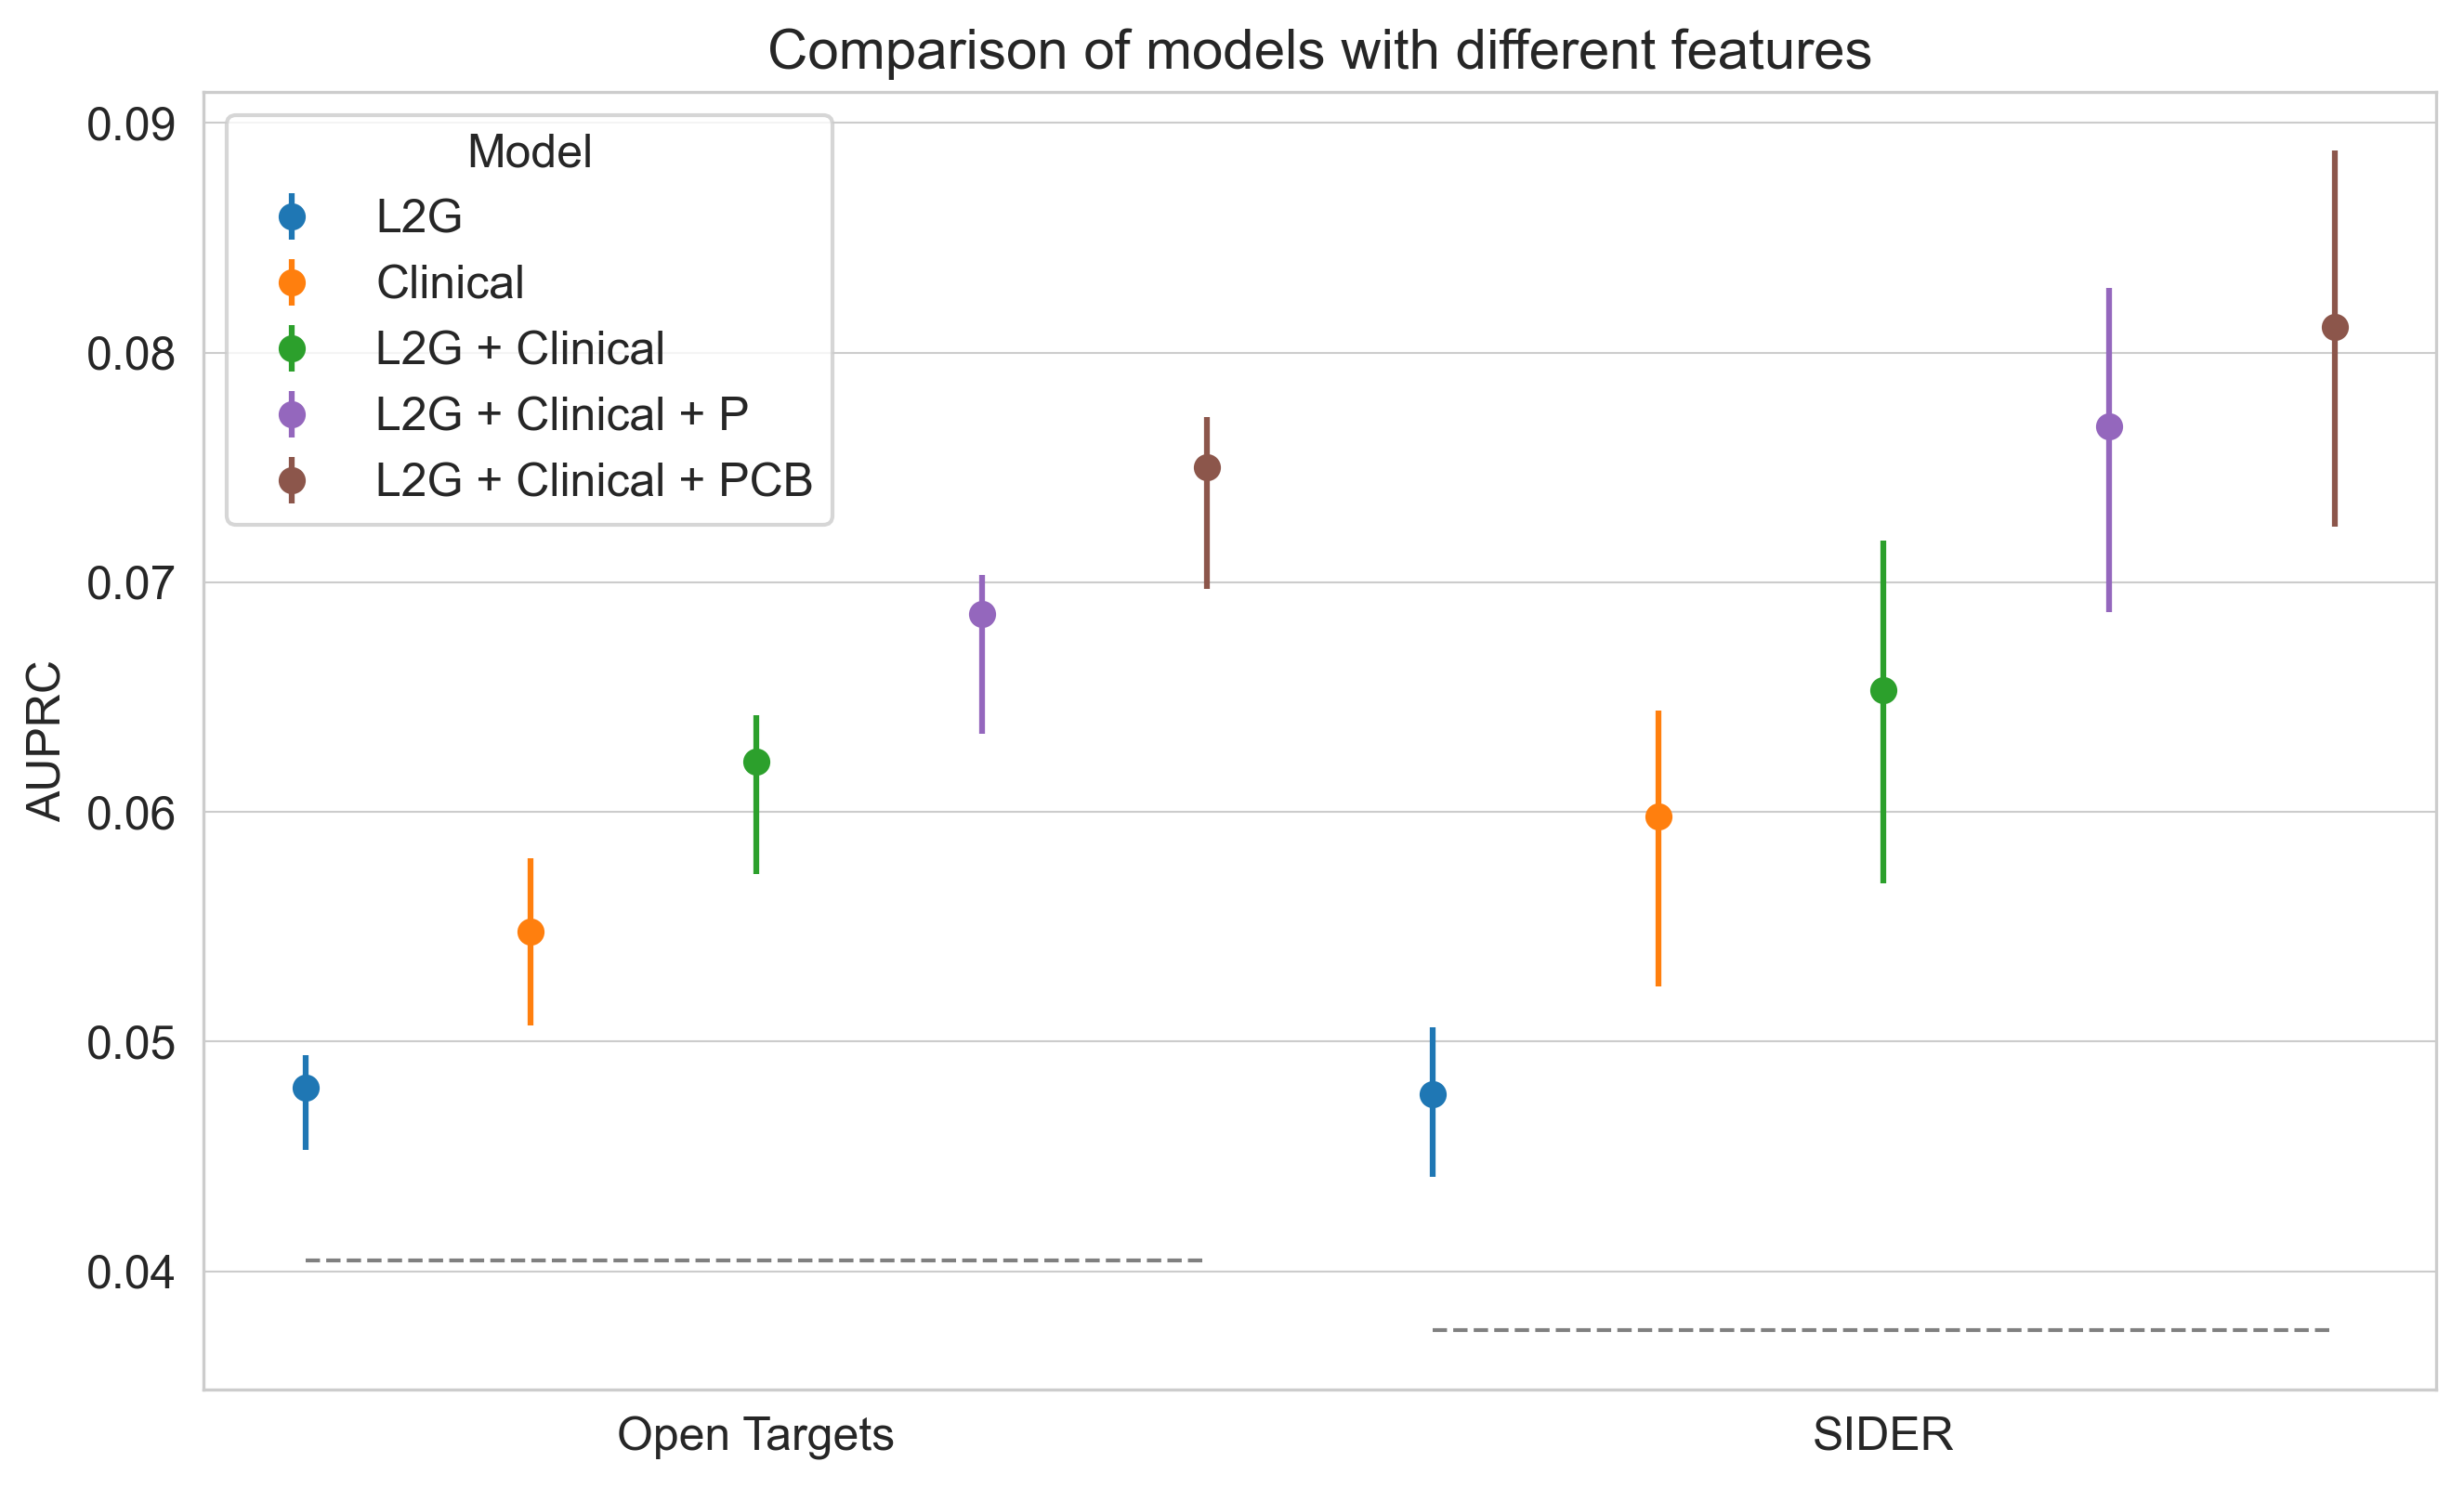

In [51]:
def parse_values(data):
    parsed_data = {}
    for key, value in data.items():
        mean, ci = value.split(' ', 1)
        ci_lower, ci_upper = ci.strip('()').split(', ')
        mean = float(mean)
        ci_lower = float(ci_lower)
        ci_upper = float(ci_upper)
        parsed_data[key] = (mean, (mean - ci_lower, ci_upper - mean))
    return parsed_data

parsed_hold = parse_values(hold_auprc_summary)
parsed_out = parse_values(out_auprc_summary)

# Setup for plotting
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=300)
plt.rcParams.update({'font.size': 12})

# Define x-axis positions for the two groups
group_positions = [1, 2]  # For auprc_hold and auprc_out
width = 0.1  # Width of each bar/error bar

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']

def plot_group(group_data, position, color):
    labels = list(group_data.keys())
    num_labels = len(labels)
    total_width = width * 2 * (num_labels - 1)
    start_x = position - total_width / 2

    xpos = []
    for i, label in enumerate(labels):
        # Use the standard Matplotlib colors, cycling through if there are more models than colors
        color = default_colors[i % len(default_colors)]
        x = start_x + i * width * 2  # Adjust the spacing here
        xpos.append(x)
        mean, ci = group_data[label]
        ax.errorbar(x, mean, yerr=[[ci[0]], [ci[1]]], fmt='o', color=color, label=label if position == 1 else "_nolegend_")
    return min(xpos), max(xpos)

# Plot each group and get x positions for lines
xmin_hold, xmax_hold = plot_group(parsed_hold, group_positions[0], default_colors)
xmin_out, xmax_out = plot_group(parsed_out, group_positions[1], default_colors)

# Plot horizontal lines
ax.hlines(hold_df['indication'].mean(), xmin_hold, xmax_hold, colors='grey', linestyles='dashed', linewidth=1)
ax.hlines(out_df['indication'].mean(), xmin_out, xmax_out, colors='grey', linestyles='dashed', linewidth=1)

# Customizing the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(['Open Targets', 'SIDER'])
ax.set_ylabel('AUPRC')

# Generate legend without duplicates
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title='Model')

plt.title('Comparison of models with different features')
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.grid(False, which='both', axis='x') # Disable vertical grid lines

plt.tight_layout()
plt.show()

In [52]:
results_df = []

percentiles = [(0.75,0.85),(0.85,0.95),(0.95,0.98),(0.98,0.99),(0.99,1.00)]

for file_name in ['L2G','Clinical','L2G + Clinical','L2G + Clinical + P','L2G + Clinical + PCB']:

    hold = pd.read_pickle(f'./Models/Features/hold_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    hold = hold.merge(input[['g-p','indication','phase','oe','BI','CV','EM']])
    out = pd.read_pickle(f'./Models/Features/out_{file_name}.pkl').groupby(['g-p'])['pred'].mean().reset_index()
    out = out.merge(output[['g-p','indication','phase','oe','BI','CV','EM']])

    if file_name != 'LR':
        imp = pd.read_pickle(f'./Models/Features/importance_{file_name}.pkl').groupby(['outer_fold','feature'])[['imp_gain','imp_split']].mean().reset_index()
        imp = imp.groupby(['feature']).agg({'imp_gain': mean_ci_df, 'imp_split': mean_ci_df})
        imp = {'imp_gain':imp['imp_gain'].to_dict(), 'imp_split':imp['imp_split'].to_dict()}
    else:
        metrics = pd.read_pickle(f'./Models/Features/metrics_{file_name}.pkl')
        coef = metrics['coef'][0]
        coef = {'coef':coef}

    hold_results = {
        "features": file_name,
        "hold_prop": hold['indication'].mean(),
        "hold_or": or_top_bottom(hold,percentiles),
        "hold_or_phase": or_phase(hold)
    }

    out_results = {
        "out_prop": out['indication'].mean(),
        "out_or": or_top_bottom(out,percentiles)
    }

    if file_name != 'LR':
        results_df.append({**hold_results, **out_results, **imp})
    else:
        results_df.append({**hold_results, **out_results, **coef})

pd.DataFrame(results_df).to_excel('./Models/Features/results.xlsx')

Optimization terminated successfully.
         Current function value: 0.166212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.168153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038804
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.073298
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040363
  

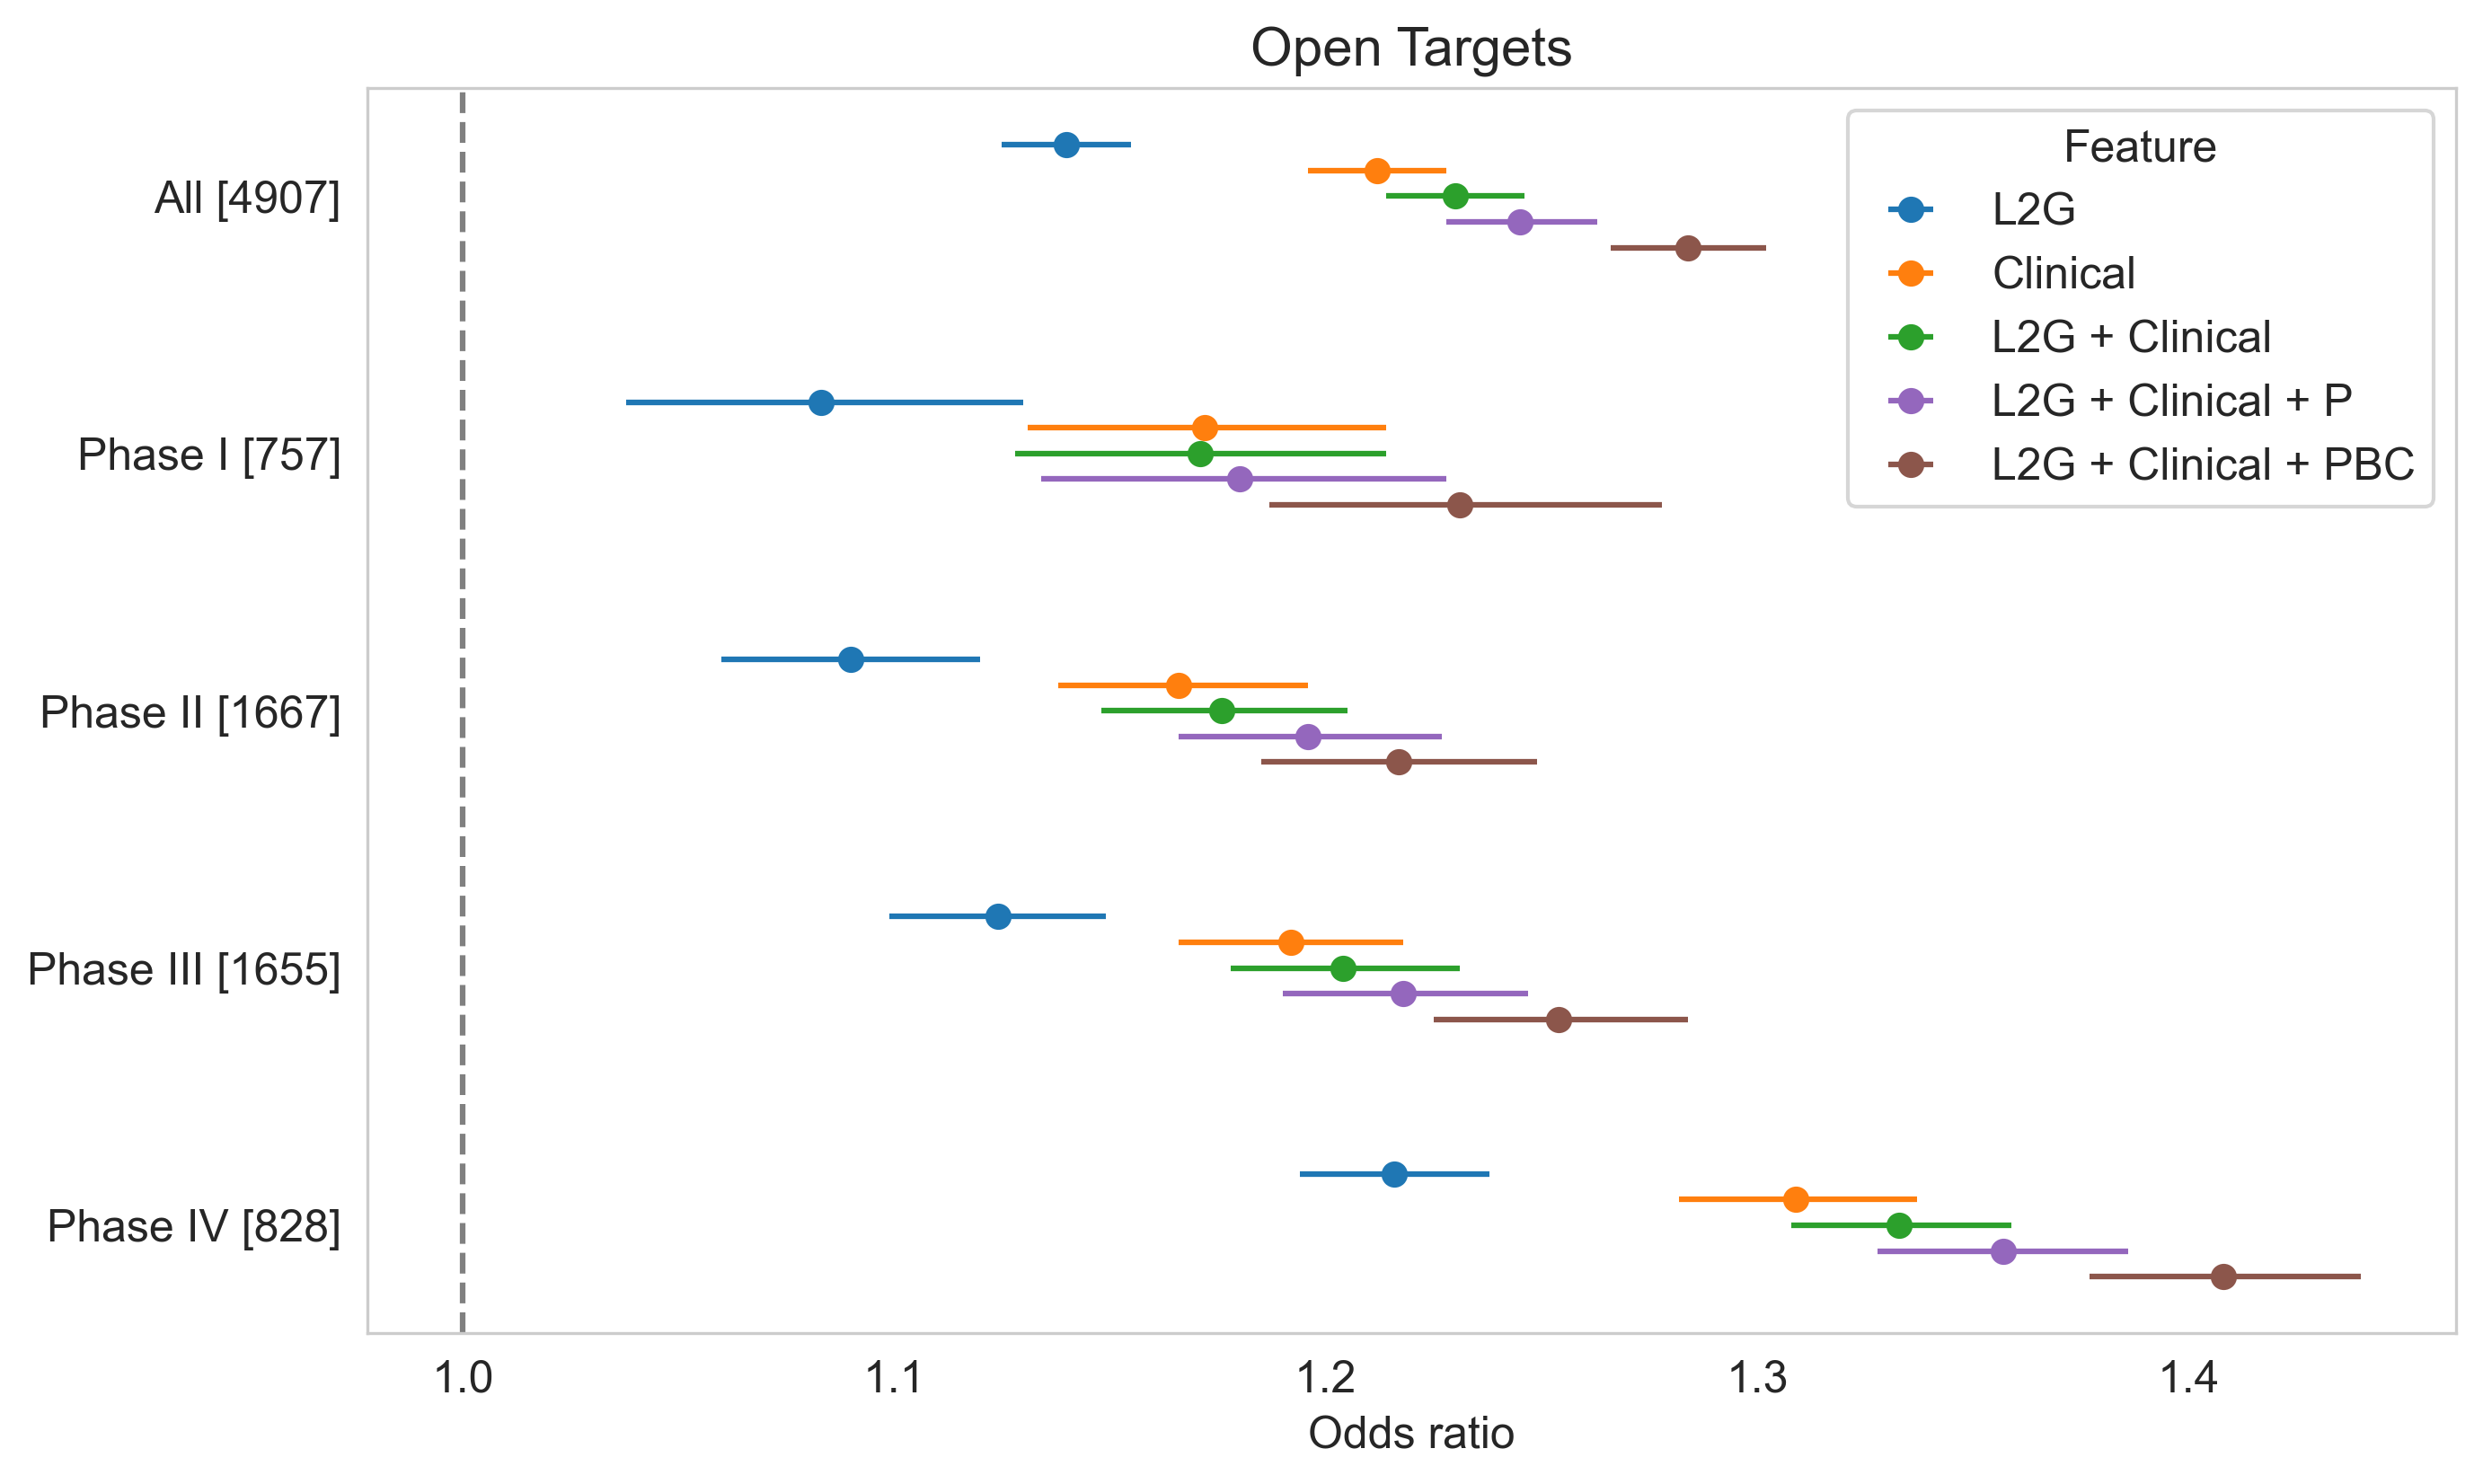

In [54]:
df = pd.read_excel('./Models/Features/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 1','Phase I')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 2','Phase II')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 3','Phase III')
df['hold_or_phase'] = df['hold_or_phase'].str.replace('Phase 4','Phase IV')


plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_phase'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

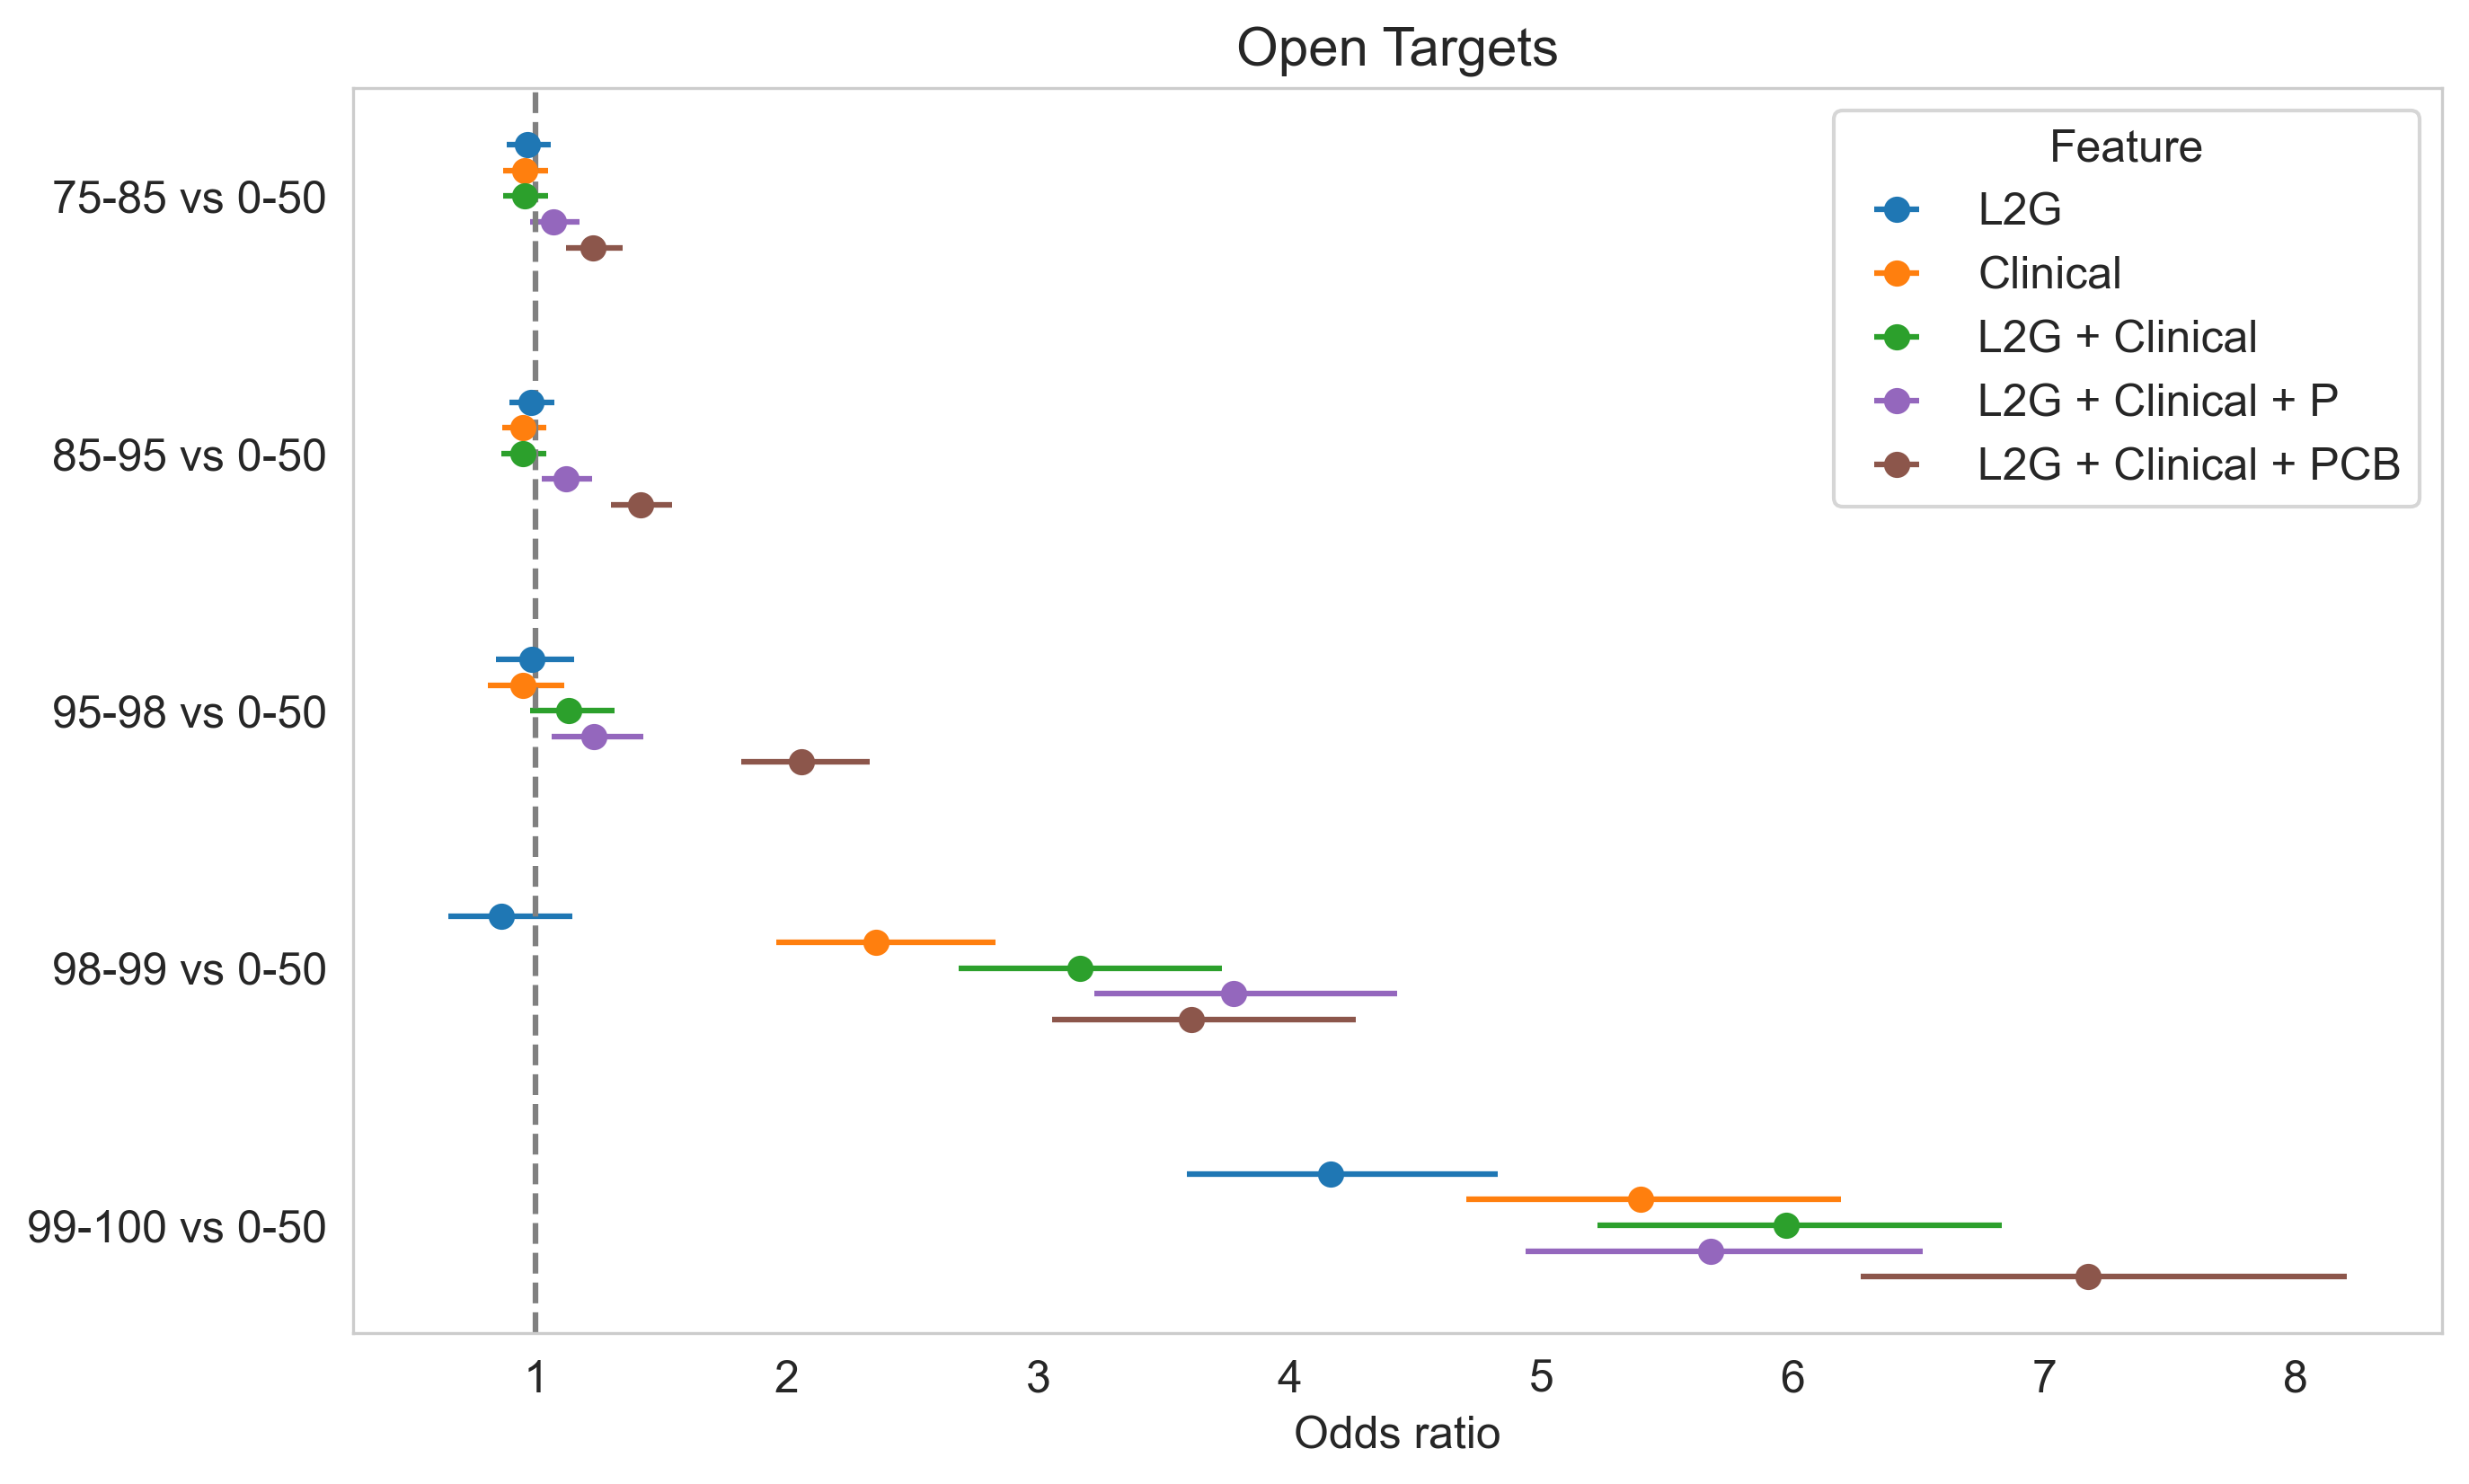

In [57]:
df = pd.read_excel('./Models/Features/results.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

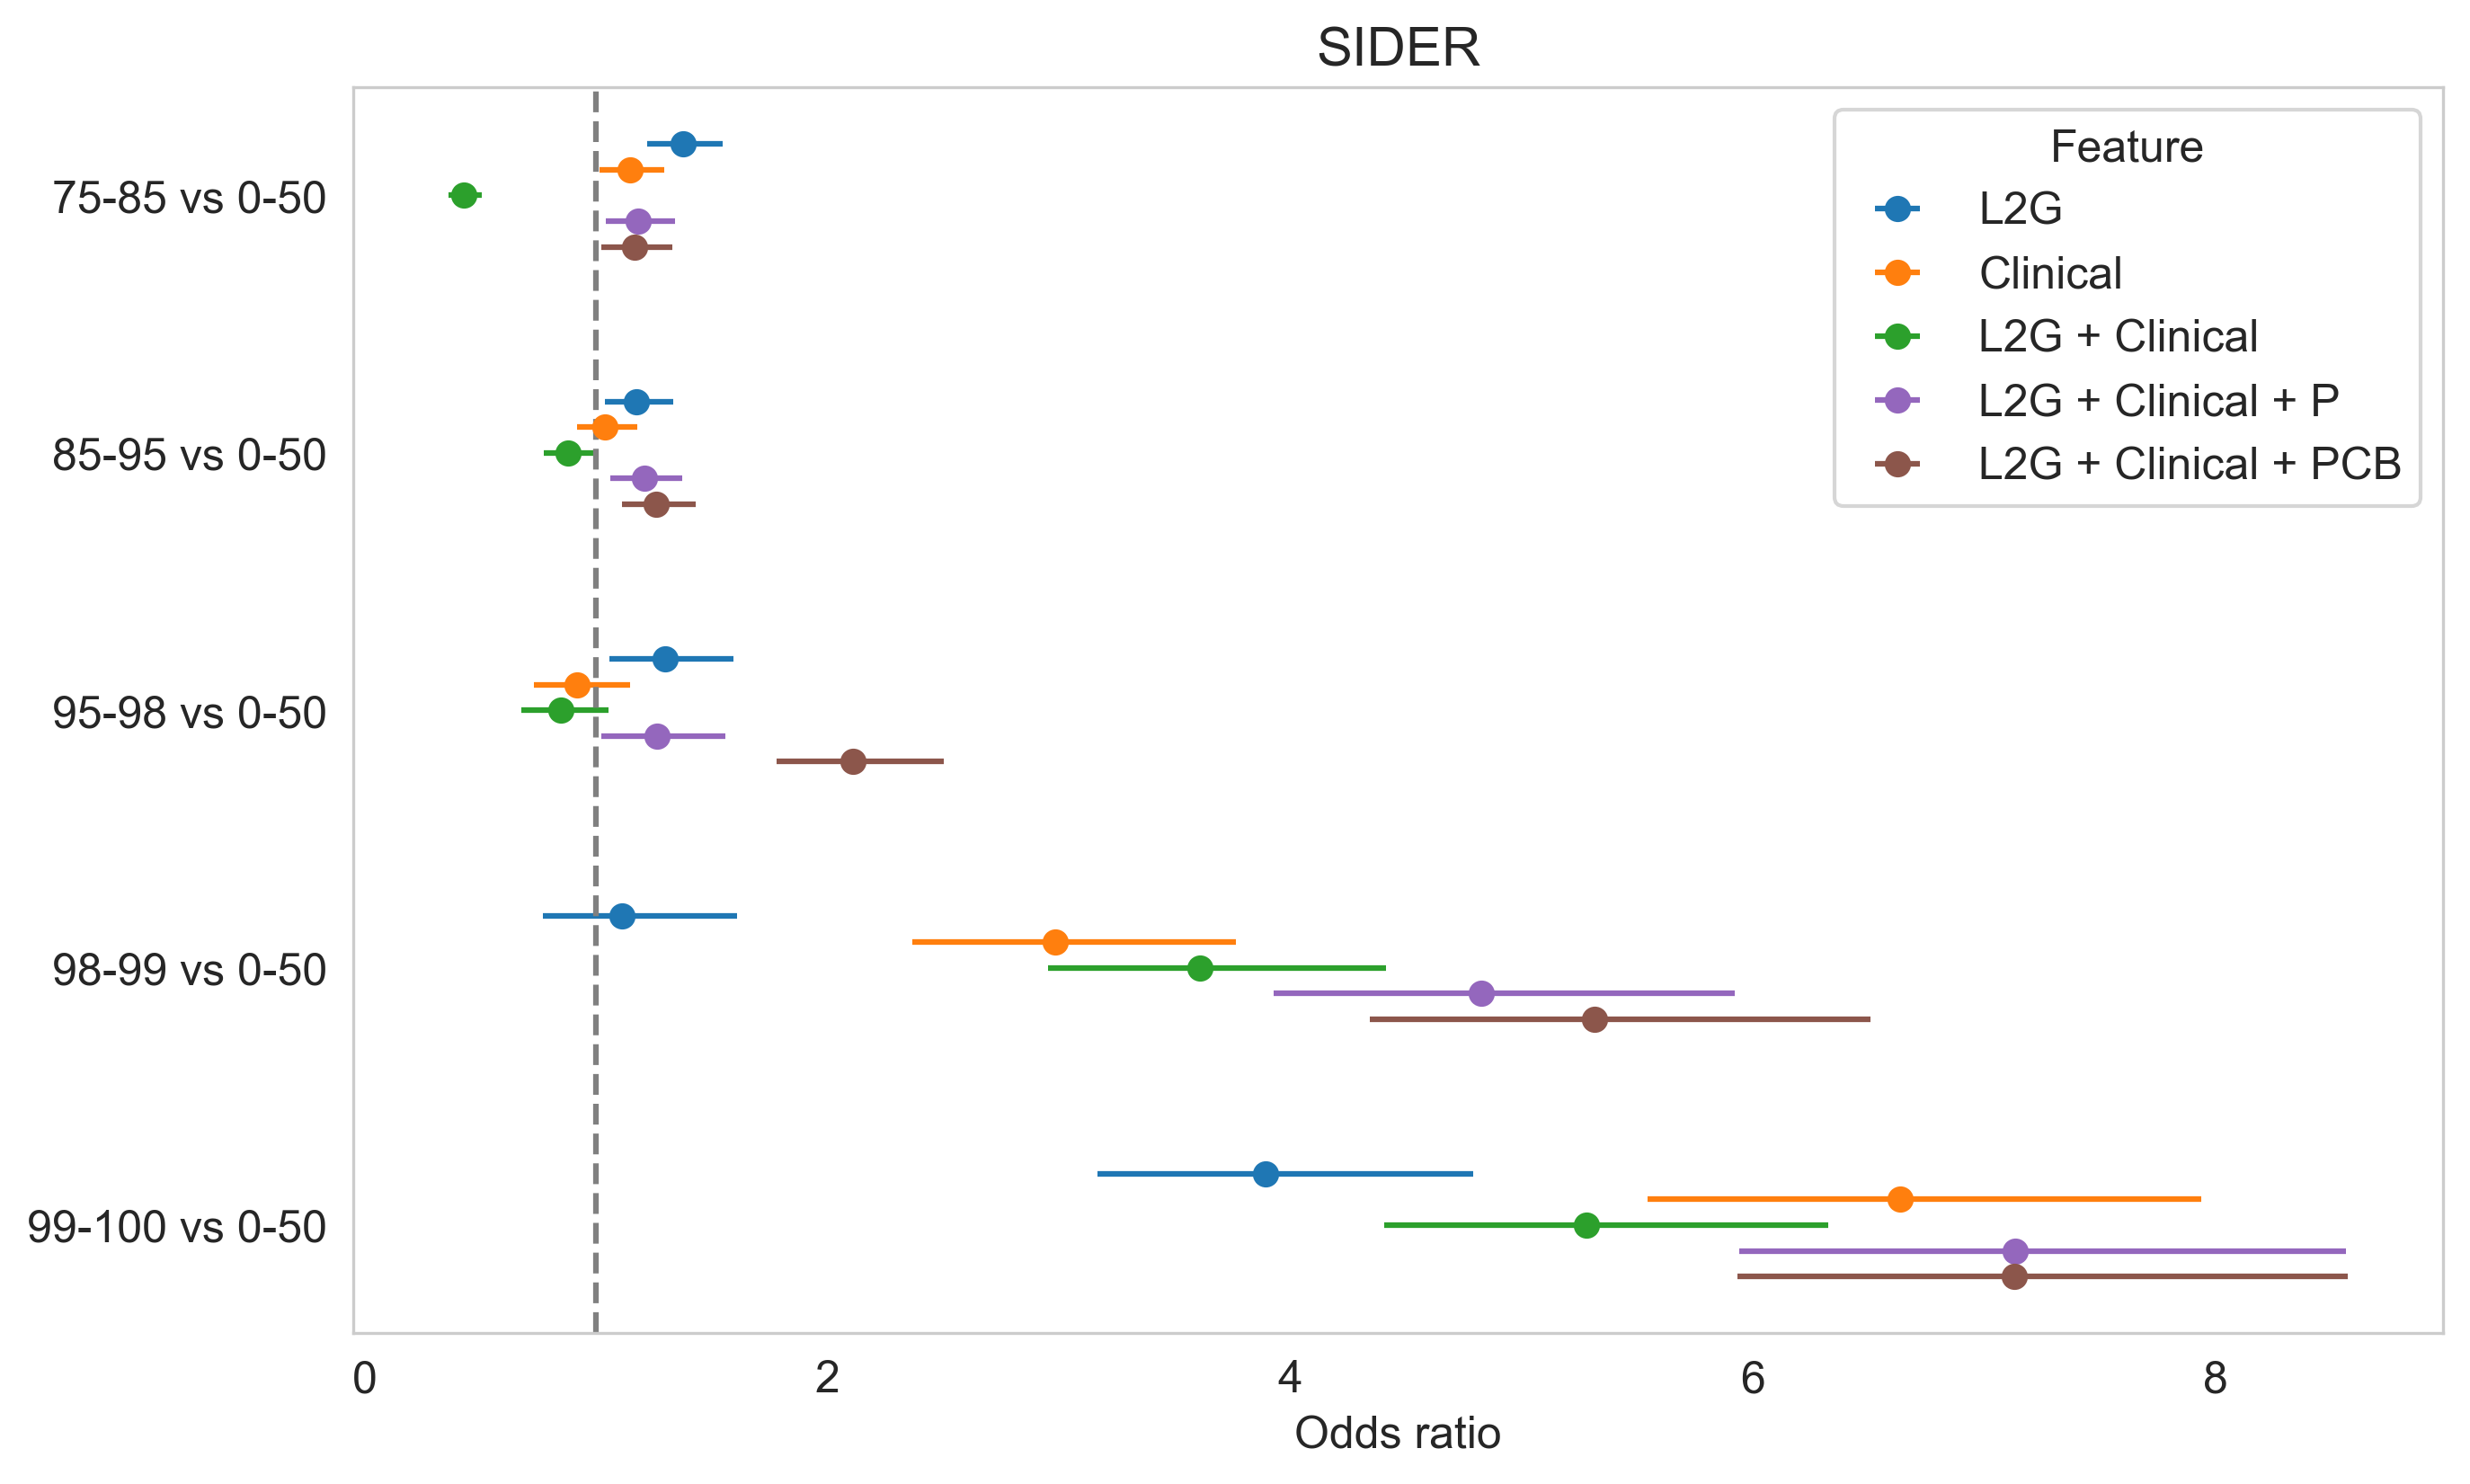

In [58]:
df = pd.read_excel('./Models/Features/results.xlsx')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['out_or'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)

plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('SIDER')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

## Directional

In [59]:
input_df = input.copy()
input_df = input_df.loc[(input_df['indication'] == 0) | ((input_df['activator'] == 1) | (input_df['inhibitor'] == 1))]
input_df['dir_indication'] = 0
input_df.loc[(input_df['indication'] == 1) & (input_df['inhibitor'] == 1), 'dir_indication'] = 1
input_df.loc[(input_df['indication'] == 1) & (input_df['activator'] == 1), 'dir_indication'] = 2

# Modified weights compared to first version
input_df['weight'] = 1
input_df.loc[input_df['phase'] == 2, 'weight'] = 1.1
input_df.loc[input_df['phase'] == 3, 'weight'] = 1.2
input_df.loc[input_df['phase'] == 4, 'weight'] = 1.3
input_df.loc[input_df['dir_indication'] == 1, 'weight'] = input_df['weight']*2
input_df.loc[input_df['dir_indication'] == 2, 'weight'] = input_df['weight']*3

output_dir = output.copy()
output_dir = output_dir.loc[(output_dir['indication'] == 0) | ((output_dir['activator'] == 1) | (output_dir['inhibitor'] == 1))]
output_dir['dir_indication'] = 0
output_dir.loc[(output_dir['indication'] == 1) & (output_dir['inhibitor'] == 1), 'dir_indication'] = 1
output_dir.loc[(output_dir['indication'] == 1) & (output_dir['activator'] == 1), 'dir_indication'] = 2

ic_1 = ['l2g_inh','l2g_neu','l2g_act']
ic_2 = ['EVA_act','EVA_inh','EVA_neu','OMIM', 'HGMD_act', 'HGMD_inh', 'HGMD_neu']
ic_3 = ['EVA_act','EVA_inh','EVA_neu','OMIM', 'HGMD_act', 'HGMD_inh', 'HGMD_neu',\
        'l2g_inh','l2g_neu','l2g_act']
ic_4 = ['EVA_act','EVA_inh','EVA_neu','OMIM', 'HGMD_act', 'HGMD_inh', 'HGMD_neu',\
        'l2g_inh','l2g_neu','l2g_act','p_b_act','p_b_inh','p_e_act','p_e_inh','p_e_neu','p_g_act','p_g_inh']
ic_5 = ['EVA_act','EVA_inh','EVA_neu','OMIM','HGMD_act', 'HGMD_inh', 'HGMD_neu',\
        'l2g_inh','l2g_neu','l2g_act','p_b_act','p_b_inh','p_e_act','p_e_inh','p_e_neu','p_g_act','p_g_inh',\
        'b_b_act', 'b_b_inh', 'b_e_act', 'b_e_inh', 'b_e_neu', 'b_g_act', 'b_g_inh', 
        'c_b_act', 'c_b_inh', 'c_e_act', 'c_e_inh', 'c_e_neu', 'c_g_act', 'c_g_inh']

for input_cols, file_name in [[ic_1,'L2G'], [ic_2,'Clinical'],[ic_3,'L2G + Clinical'],[ic_4,'L2G + Clinical + P'],[ic_5,'L2G + Clinical + PCB']]:
    
    # Prepare data
    X_input = input_df[input_cols]
    y_input = input_df['dir_indication']
    id_input = input_df['g-p']
    weight_input = input_df['weight']
    
    X_pred = agp[input_cols]
    ids_pred = []
    pred_predictions = []

    ids_holdout = []
    ids_output = []
    holdout_predictions = []
    output_predictions = []

    ifold_list = []
    ofold = 1
    ofold_list = []

    feat_name = []
    imp_gain = []
    imp_split = []

    # Nested Cross-Validation
    outer_cv = KFold(n_splits=5, shuffle=False)
    inner_cv = KFold(n_splits=5, shuffle=False)

    for train_index, test_index in outer_cv.split(X_input):

        ifold = 1

        X_train_outer, X_holdout = X_input.iloc[train_index], X_input.iloc[test_index]
        y_train_outer, y_holdout = y_input.iloc[train_index], y_input.iloc[test_index]
        weight_outer = weight_input.iloc[train_index]

        # Remove g-p from SIDER present in OT train/validation
        id_outer = id_input.iloc[train_index]
        output_df = output_dir.loc[~output_dir['g-p'].isin(id_outer)].copy()
        X_output = output_df[input_cols]
        y_output = output_df['dir_indication']

        for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):

            print(ofold,ifold)

            ofold_list.append(ofold)
            ifold_list.append(ifold)
            ifold += 1

            X_train, X_val = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_test_index]
            y_train, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
            weight_train, weight_val = weight_outer.iloc[inner_train_index], weight_outer.iloc[inner_test_index]

            # LightGBM model training
            train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train)
            val_data = lgb.Dataset(X_val, label=y_val, weight=weight_val, reference=train_data)

            params = {
                        'objective': 'multiclassova',
                        'num_class': 3,
                        'metric': 'multi_logloss',
                        'boosting_type': 'goss',
                        'num_boost_round': 1000,
                        'learning_rate': 0.01,
                        'num_leaves': 22,
                        'max_depth': -1,
                        'feature_fraction': 1,
                        'min_data_in_leaf': 50,
                        'verbose': -1,
                        'device_type': 'cpu'
            }
            
            gbm = lgb.train(params, train_data, valid_sets=val_data, callbacks=[lgb.early_stopping(stopping_rounds=10)])

            feat_name.append(gbm.feature_name())
            imp_gain.append(gbm.feature_importance(importance_type='gain'))
            imp_split.append(gbm.feature_importance(importance_type='split'))
            
            # Predictions

            val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
            hold_pred = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
            out_pred = gbm.predict(X_output, num_iteration=gbm.best_iteration)

            holdout_predictions.append(hold_pred)
            output_predictions.append(out_pred)
            ids_holdout.append(input_df['g-p'].iloc[test_index].to_list())
            ids_output.append(output_df['g-p'].to_list())
            
            if file_name in ['L2G + Clinical + P','L2G + Clinical + PCB']:
                pred_pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
                pred_predictions.append(pred_pred)
                ids_pred.append(agp['g-p'].to_list())

        ofold += 1

    #
    
    holdout_predictions = np.concatenate(holdout_predictions, axis=0)
    hold_none = holdout_predictions[:, 0].flatten()
    hold_inh = holdout_predictions[:, 1].flatten()
    hold_act = holdout_predictions[:, 2].flatten()


    lengths = [len(sublist) for sublist in ids_holdout]
    hold_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    hold_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    hold_pred = pd.DataFrame({'outer_fold':hold_i,'inner_fold':hold_j,'g-p':flatten(flatten(ids_holdout)),\
                              'hold_none':hold_none,'hold_inh':hold_inh,'hold_act':hold_act})
    hold_pred.to_pickle(f'./Models/Directional/hold_{file_name}.pkl')

    #
    
    output_predictions = np.concatenate(output_predictions, axis=0)
    out_none = output_predictions[:, 0].flatten()
    out_inh = output_predictions[:, 1].flatten()
    out_act = output_predictions[:, 2].flatten()

    lengths = [len(sublist) for sublist in ids_output]
    out_i = [i for i, length in zip(ofold_list, lengths) for _ in range(length)]
    out_j = [i for i, length in zip(ifold_list, lengths) for _ in range(length)]
    out_pred = pd.DataFrame({'outer_fold':out_i,'inner_fold':out_j,'g-p':flatten(flatten(ids_output)),\
                             'out_none':out_none,'out_inh':out_inh,'out_act':out_act})
    out_pred.to_pickle(f'./Models/Directional/out_{file_name}.pkl')

    #
    
    if file_name in ['L2G + Clinical + P','L2G + Clinical + PCB']:
        pred_predictions = np.concatenate(pred_predictions, axis=0)
        pred_none = pred_predictions[:, 0].flatten()
        pred_inh = pred_predictions[:, 1].flatten()
        pred_act = pred_predictions[:, 2].flatten()

        pred_pred = pd.DataFrame({'g-p':flatten(flatten(ids_pred)),'pred_none':pred_none,'pred_inh':pred_inh,'pred_act':pred_act})
        pred_pred = pred_pred.groupby('g-p').mean().reset_index()
        pred_pred.to_pickle(f'./Models/Directional/pred_{file_name}.pkl')

    #

    importance = pd.DataFrame({'outer_fold':extend(ofold_list, len(input_cols)),'inner_fold':extend(ifold_list, len(input_cols)),'feature':flatten(feat_name),'imp_gain':flatten(imp_gain),'imp_split':flatten(imp_split)})
    importance.to_pickle(f'./Models/Directional/importance_{file_name}.pkl')

/var/folders/yr/y10yd09d6pg7yv_8hdtwsgf80000gn/T/ipykernel_43092/1776092019.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[input_df['phase'] == 2, 'weight'] = 1.1
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


1 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.352028
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.36363
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.375282
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.356438
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.351202
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.369475
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.356841
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.375091
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.356415
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.351144
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.36923
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.349406
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.366048
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 0.355857
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.350973
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.369634
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.349143
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[132]	valid_0's multi_logloss: 0.373446
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.373299
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.350911
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 0.369418
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.349726
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[188]	valid_0's multi_logloss: 0.373147
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.368298
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 0.35484
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.350731
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	valid_0's multi_logloss: 0.36019
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.375146
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[511]	valid_0's multi_logloss: 0.354038
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.347147
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[319]	valid_0's multi_logloss: 0.36769
2 2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 0.353564
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.375075
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[477]	valid_0's multi_logloss: 0.353949
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.347892
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[176]	valid_0's multi_logloss: 0.368031
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 0.34653
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.365291
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[349]	valid_0's multi_logloss: 0.354685
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.347664
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[184]	valid_0's multi_logloss: 0.367948
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.347051
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[200]	valid_0's multi_logloss: 0.369788
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.371611
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[297]	valid_0's multi_logloss: 0.346784
5 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 0.367918
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[189]	valid_0's multi_logloss: 0.347722
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.370353
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.367649
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[440]	valid_0's multi_logloss: 0.352572
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.35023
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[183]	valid_0's multi_logloss: 0.358584
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.372683
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.354592
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.346896
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[148]	valid_0's multi_logloss: 0.367031
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[176]	valid_0's multi_logloss: 0.352036
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.372895
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.35334
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[287]	valid_0's multi_logloss: 0.347007
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.367079
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.346113
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.363595
3 4


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.353532
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[255]	valid_0's multi_logloss: 0.346935
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.367725
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[157]	valid_0's multi_logloss: 0.346492
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[157]	valid_0's multi_logloss: 0.368732
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.370137
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.345835
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[139]	valid_0's multi_logloss: 0.367141
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.347902
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[172]	valid_0's multi_logloss: 0.368996
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.366333
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.351514
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.345964
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 0.356743
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 0.37035
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 0.349564
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.344877
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.365157
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.35101
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.371175
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 0.348942
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.345103
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[141]	valid_0's multi_logloss: 0.364615
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.343171
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.361476
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[267]	valid_0's multi_logloss: 0.349448
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.345064
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 0.365273
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[196]	valid_0's multi_logloss: 0.344025
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.365091
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.36755
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.34519
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[162]	valid_0's multi_logloss: 0.364647
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[188]	valid_0's multi_logloss: 0.344338
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 0.365854
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[218]	valid_0's multi_logloss: 0.362878
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.347526
1 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[254]	valid_0's multi_logloss: 0.344162
1 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[233]	valid_0's multi_logloss: 0.35463
1 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[229]	valid_0's multi_logloss: 0.366756
1 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.34957
1 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[169]	valid_0's multi_logloss: 0.342397
2 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.363294
2 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.348569
2 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[277]	valid_0's multi_logloss: 0.366955
2 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[221]	valid_0's multi_logloss: 0.348816
2 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 0.343906
3 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[183]	valid_0's multi_logloss: 0.364014
3 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[171]	valid_0's multi_logloss: 0.342126
3 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[210]	valid_0's multi_logloss: 0.358193
3 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.348951
3 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[257]	valid_0's multi_logloss: 0.342458
4 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[259]	valid_0's multi_logloss: 0.363308
4 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 0.341292
4 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.362319
4 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[245]	valid_0's multi_logloss: 0.364492
4 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.342282
5 1
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.36235
5 2
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.342103
5 3
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[244]	valid_0's multi_logloss: 0.361897
5 4
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[338]	valid_0's multi_logloss: 0.358847
5 5
Training until validation scores don't improve for 10 rounds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[270]	valid_0's multi_logloss: 0.346097


In [60]:
hold_df = pd.DataFrame()
out_df = pd.DataFrame()

cols = ['L2G','Clinical','L2G + Clinical','L2G + Clinical + P','L2G + Clinical + PCB']

for file_name in cols:
    hold = pd.read_pickle(f'./Models/Directional/hold_{file_name}.pkl').groupby(['g-p'])[['hold_act','hold_inh']].mean().reset_index()
    hold['model'] = file_name
    hold_df = pd.concat([hold_df,hold])
    
    out = pd.read_pickle(f'./Models/Directional/out_{file_name}.pkl').groupby(['g-p'])[['out_act','out_inh']].mean().reset_index()
    out['model'] = file_name
    out_df = pd.concat([out_df,out])

hold_df_act = pd.pivot(hold_df, index='g-p', columns='model', values='hold_act').reset_index()
hold_df_act = hold_df_act.merge(input[['g-p','phase','activator']]).fillna(0)

hold_df_inh = pd.pivot(hold_df, index='g-p', columns='model', values='hold_inh').reset_index()
hold_df_inh = hold_df_inh.merge(input[['g-p','phase','inhibitor']]).fillna(0)

out_df_act = pd.pivot(out_df, index='g-p', columns='model', values='out_act').reset_index()
out_df_act = out_df_act.merge(output[['g-p','phase','activator']]).fillna(0)

out_df_inh = pd.pivot(out_df, index='g-p', columns='model', values='out_inh').reset_index()
out_df_inh = out_df_inh.merge(output[['g-p','phase','inhibitor']]).fillna(0)

#

if True:
    n_bootstraps = 50 # Fewer bootstraps to speed up computations
    hold_auprc_results_act = {key: [] for key in cols}
    hold_auprc_results_inh = {key: [] for key in cols}
    out_auprc_results_act = {key: [] for key in cols}
    out_auprc_results_inh = {key: [] for key in cols}

    for _ in range(n_bootstraps):
        sample_df = hold_df_act.sample(n=len(hold_df_act), replace=True)
        for col in cols:
            auprc = average_precision_score(sample_df['activator'], sample_df[col])
            hold_auprc_results_act[col].append(auprc)

        sample_df = hold_df_inh.sample(n=len(hold_df_inh), replace=True)
        for col in cols:
            auprc = average_precision_score(sample_df['inhibitor'], sample_df[col])
            hold_auprc_results_inh[col].append(auprc)

        sample_df = out_df_act.sample(n=len(out_df_act), replace=True)
        for col in cols:
            auprc = average_precision_score(sample_df['activator'], sample_df[col])
            out_auprc_results_act[col].append(auprc)

        sample_df = out_df_inh.sample(n=len(out_df_inh), replace=True)
        for col in cols:
            auprc = average_precision_score(sample_df['inhibitor'], sample_df[col])
            out_auprc_results_inh[col].append(auprc)

    hold_auprc_summary_act = {}
    hold_auprc_summary_inh = {}
    out_auprc_summary_act = {}
    out_auprc_summary_inh = {}

    for col in cols:
        mean_auprc = np.mean(hold_auprc_results_act[col])
        original_stat = average_precision_score(hold_df_act['activator'], hold_df_act[col])
        lower_bound, upper_bound = bca_confidence_interval(hold_auprc_results_act[col], original_stat)
        hold_auprc_summary_act[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

        mean_auprc = np.mean(hold_auprc_results_inh[col])
        original_stat = average_precision_score(hold_df_inh['inhibitor'], hold_df_inh[col])
        lower_bound, upper_bound = bca_confidence_interval(hold_auprc_results_inh[col], original_stat)
        hold_auprc_summary_inh[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

        mean_auprc = np.mean(out_auprc_results_act[col])
        original_stat = average_precision_score(out_df_act['activator'], out_df_act[col])
        lower_bound, upper_bound = bca_confidence_interval(out_auprc_results_act[col], original_stat)
        out_auprc_summary_act[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

        mean_auprc = np.mean(out_auprc_results_inh[col])
        original_stat = average_precision_score(out_df_inh['inhibitor'], out_df_inh[col])
        lower_bound, upper_bound = bca_confidence_interval(out_auprc_results_inh[col], original_stat)
        out_auprc_summary_inh[col] = f"{mean_auprc:.3f} ({lower_bound:.3f}, {upper_bound:.3f})"

    print(hold_auprc_summary_act)
    print(hold_auprc_summary_inh)
    print(out_auprc_summary_act)
    print(out_auprc_summary_inh)

{'L2G': '0.012 (0.010, 0.014)', 'Clinical': '0.016 (0.012, 0.020)', 'L2G + Clinical': '0.018 (0.014, 0.022)', 'L2G + Clinical + P': '0.023 (0.018, 0.028)', 'L2G + Clinical + PCB': '0.029 (0.022, 0.034)'}
{'L2G': '0.035 (0.033, 0.037)', 'Clinical': '0.040 (0.037, 0.043)', 'L2G + Clinical': '0.044 (0.040, 0.048)', 'L2G + Clinical + P': '0.059 (0.055, 0.064)', 'L2G + Clinical + PCB': '0.067 (0.061, 0.072)'}
{'L2G': '0.012 (0.008, 0.017)', 'Clinical': '0.024 (0.016, 0.034)', 'L2G + Clinical': '0.020 (0.014, 0.028)', 'L2G + Clinical + P': '0.035 (0.021, 0.049)', 'L2G + Clinical + PCB': '0.042 (0.021, 0.054)'}
{'L2G': '0.034 (0.030, 0.038)', 'Clinical': '0.042 (0.037, 0.046)', 'L2G + Clinical': '0.046 (0.039, 0.049)', 'L2G + Clinical + P': '0.062 (0.052, 0.067)', 'L2G + Clinical + PCB': '0.064 (0.056, 0.073)'}


In [ ]:
print(permutation_test(hold_df_act['activator'], hold_df_act['Clinical'], hold_df_act['L2G']))
print(permutation_test(hold_df_act['activator'], hold_df_act['L2G'], hold_df_act['L2G + Clinical']))
print(permutation_test(hold_df_act['activator'], hold_df_act['Clinical'], hold_df_act['L2G + Clinical']))
print(permutation_test(hold_df_act['activator'], hold_df_act['L2G + Clinical'], hold_df_act['L2G + Clinical + P']))
print(permutation_test(hold_df_act['activator'], hold_df_act['L2G + Clinical'], hold_df_act['L2G + Clinical + PCB']))
print(permutation_test(hold_df_act['activator'], hold_df_act['L2G + Clinical + P'], hold_df_act['L2G + Clinical + PCB']))

print(permutation_test(hold_df_inh['inhibitor'], hold_df_inh['L2G'], hold_df_inh['Clinical']))
print(permutation_test(hold_df_inh['inhibitor'], hold_df_inh['Clinical'], hold_df_inh['L2G + Clinical']))
print(permutation_test(hold_df_inh['inhibitor'], hold_df_inh['L2G + Clinical'], hold_df_inh['L2G + Clinical + P']))
print(permutation_test(hold_df_inh['inhibitor'], hold_df_inh['L2G + Clinical + P'], hold_df_inh['L2G + Clinical + PCB']))

print(permutation_test(out_df_act['activator'], out_df_act['L2G'], out_df_act['Clinical']))
print(permutation_test(out_df_act['activator'], out_df_act['L2G'], out_df_act['L2G + Clinical']))
print(permutation_test(out_df_act['activator'], out_df_act['Clinical'], out_df_act['L2G + Clinical']))
print(permutation_test(out_df_act['activator'], out_df_act['L2G + Clinical'], out_df_act['L2G + Clinical + P']))
print(permutation_test(out_df_act['activator'], out_df_act['L2G + Clinical'], out_df_act['L2G + Clinical + PCB']))
print(permutation_test(out_df_act['activator'], out_df_act['L2G + Clinical + P'], out_df_act['L2G + Clinical + PCB']))

print(permutation_test(out_df_inh['inhibitor'], out_df_inh['L2G'], out_df_inh['Clinical']))
print(permutation_test(out_df_inh['inhibitor'], out_df_inh['Clinical'], out_df_inh['L2G + Clinical']))
print(permutation_test(out_df_inh['inhibitor'], out_df_inh['L2G + Clinical'], out_df_inh['L2G + Clinical + P']))
print(permutation_test(out_df_inh['inhibitor'], out_df_inh['L2G + Clinical + P'], out_df_inh['L2G + Clinical + PCB']))

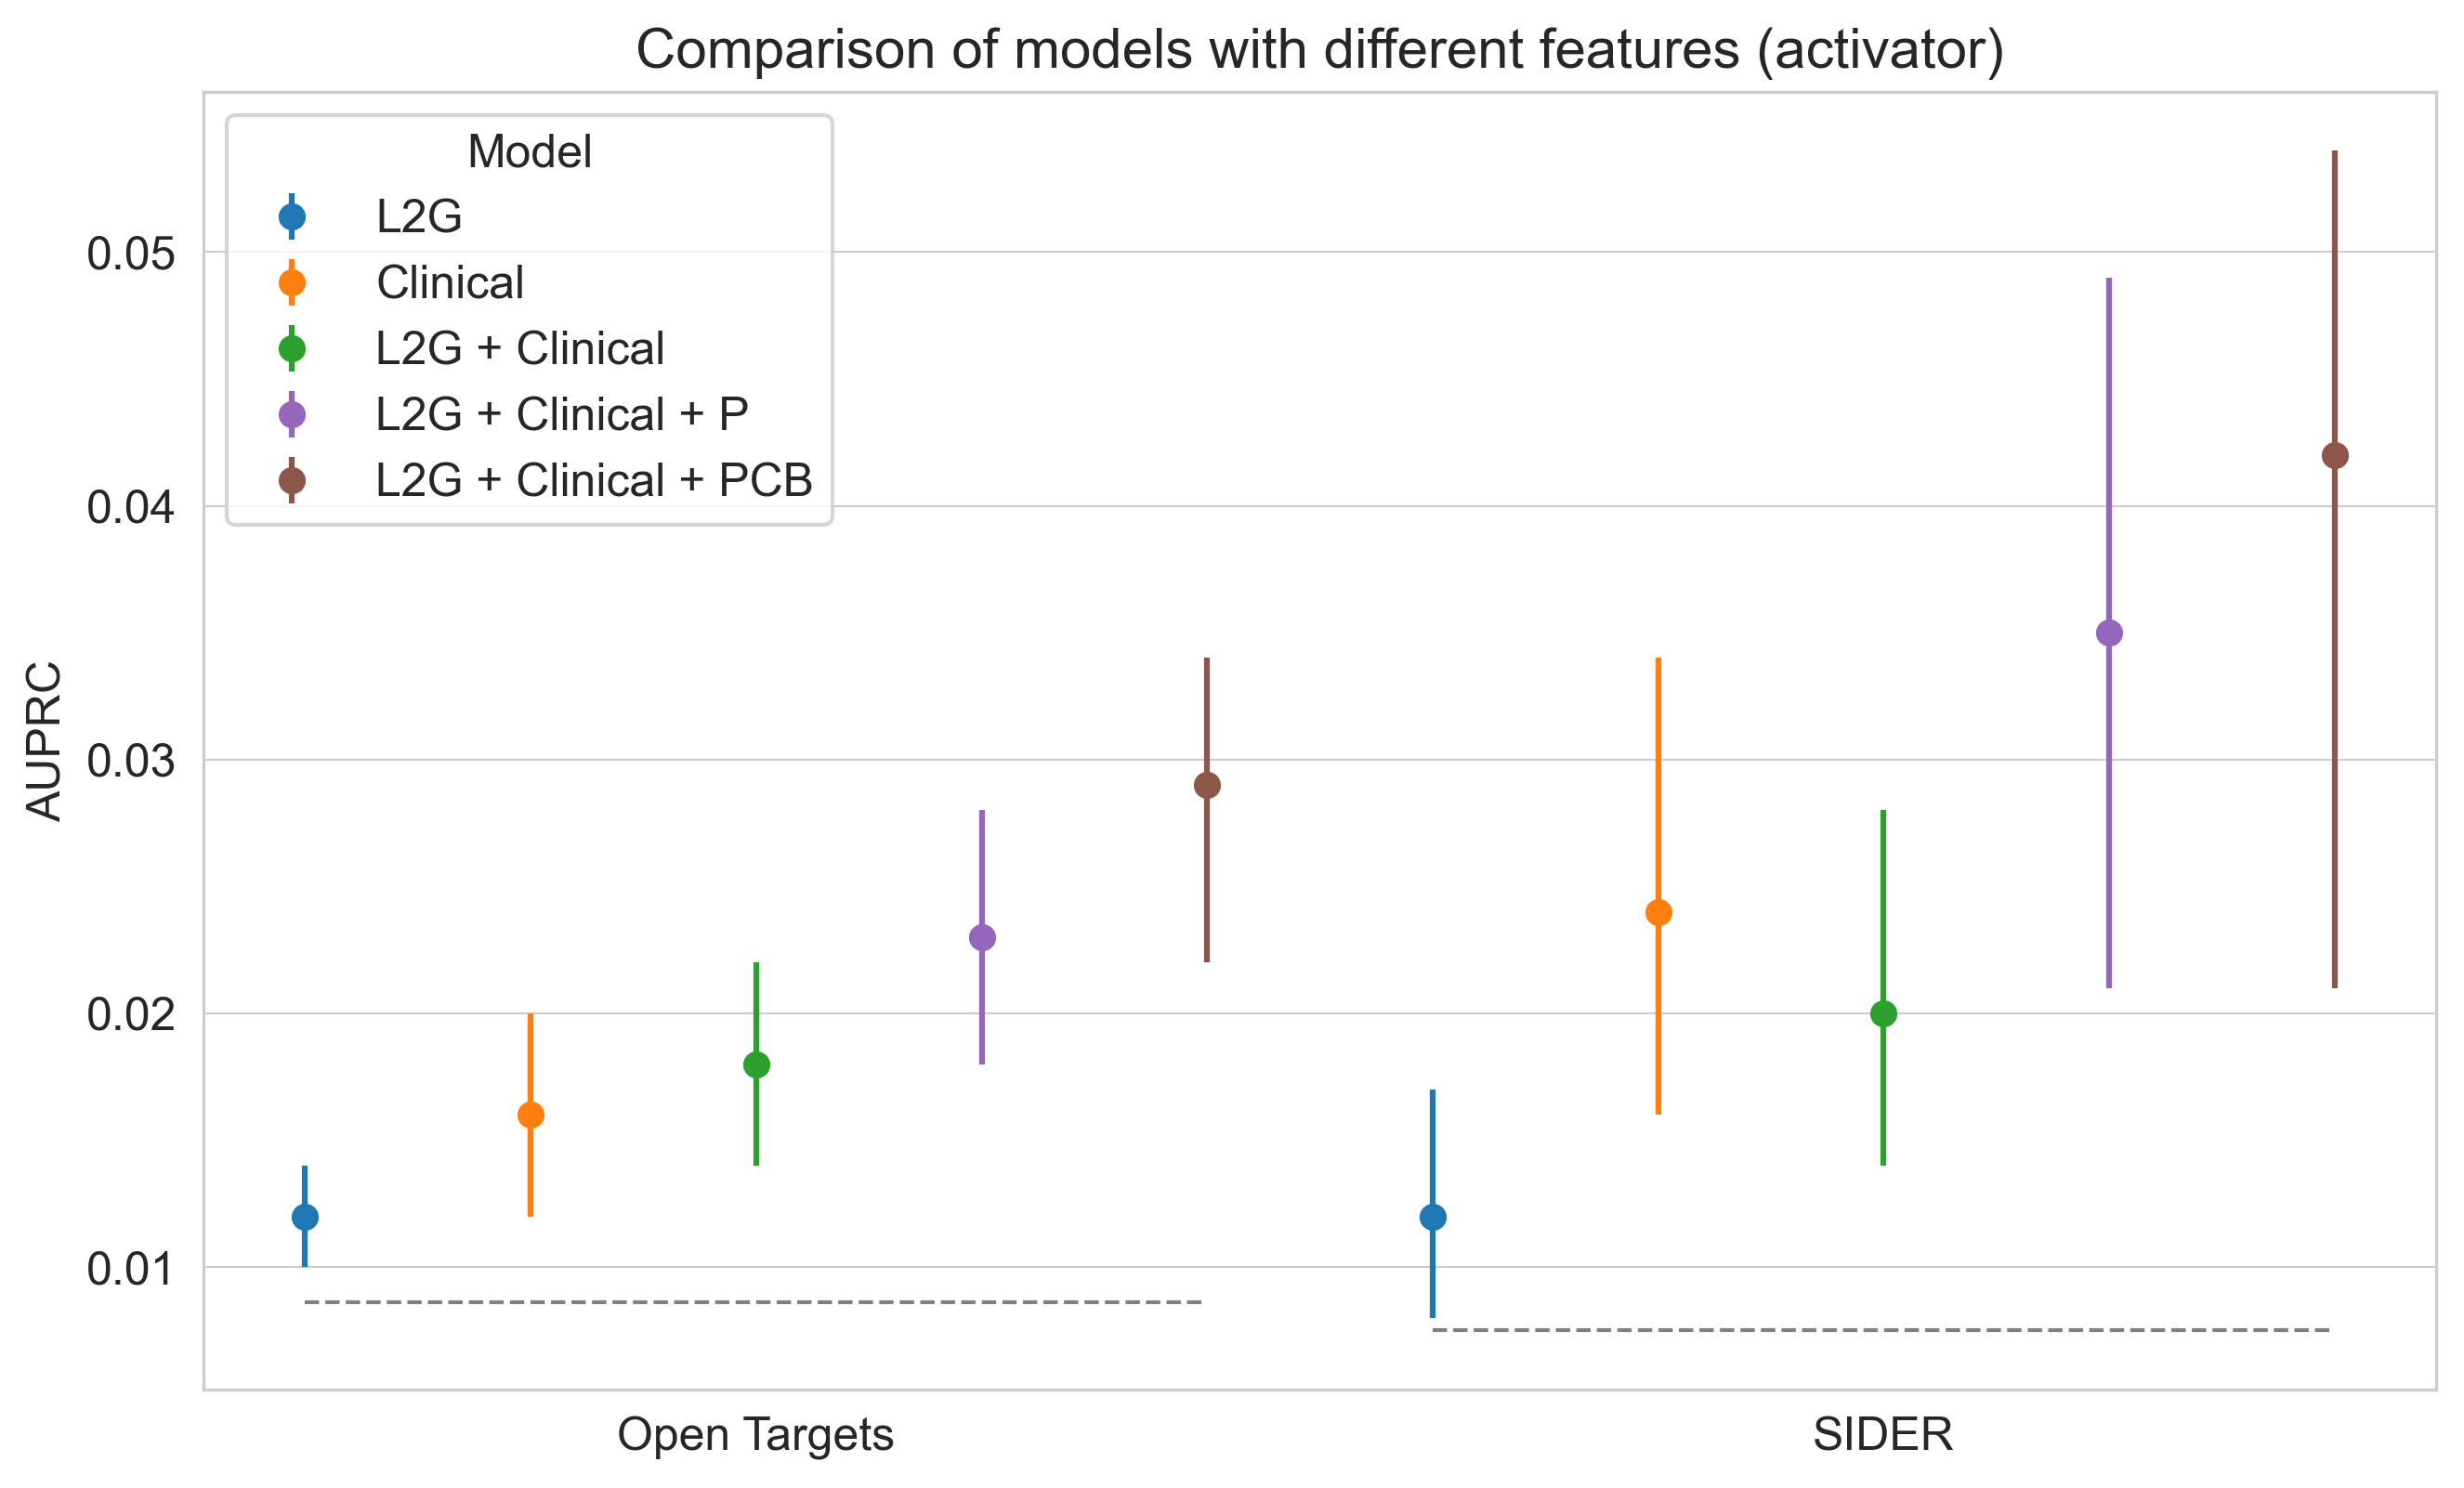

In [61]:
sns.set_style(style='whitegrid')

def parse_values(data):
    parsed_data = {}
    for key, value in data.items():
        mean, ci = value.split(' ', 1)
        ci_lower, ci_upper = ci.strip('()').split(', ')
        mean = float(mean)
        ci_lower = float(ci_lower)
        ci_upper = float(ci_upper)
        parsed_data[key] = (mean, (mean - ci_lower, ci_upper - mean))
    return parsed_data

parsed_hold = parse_values(hold_auprc_summary_act)
parsed_out = parse_values(out_auprc_summary_act)

# Setup for plotting
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=300)

# Define x-axis positions for the two groups
group_positions = [1, 2]  # For auprc_hold and auprc_out
width = 0.1  # Width of each bar/error bar

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']

def plot_group(group_data, position, color):
    labels = list(group_data.keys())
    num_labels = len(labels)
    total_width = width * 2 * (num_labels - 1)
    start_x = position - total_width / 2

    xpos = []
    for i, label in enumerate(labels):
        # Use the standard Matplotlib colors, cycling through if there are more models than colors
        color = default_colors[i % len(default_colors)]
        x = start_x + i * width * 2  # Adjust the spacing here
        xpos.append(x)
        mean, ci = group_data[label]
        ax.errorbar(x, mean, yerr=[[ci[0]], [ci[1]]], fmt='o', color=color, label=label if position == 1 else "_nolegend_")
    return min(xpos), max(xpos)

# Plot each group and get x positions for lines
xmin_hold, xmax_hold = plot_group(parsed_hold, group_positions[0], default_colors)
xmin_out, xmax_out = plot_group(parsed_out, group_positions[1], default_colors)

# Plot horizontal lines
ax.hlines(hold_df_act['activator'].mean(), xmin_hold, xmax_hold, colors='grey', linestyles='dashed', linewidth=1)
ax.hlines(out_df_act['activator'].mean(), xmin_out, xmax_out, colors='grey', linestyles='dashed', linewidth=1)

# Customizing the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(['Open Targets', 'SIDER'])
ax.set_ylabel('AUPRC')

# Generate legend without duplicates
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title='Model', loc='upper left')

plt.title('Comparison of models with different features (activator)')
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.grid(False, which='both', axis='x') # Disable vertical grid lines

plt.tight_layout()
plt.show()

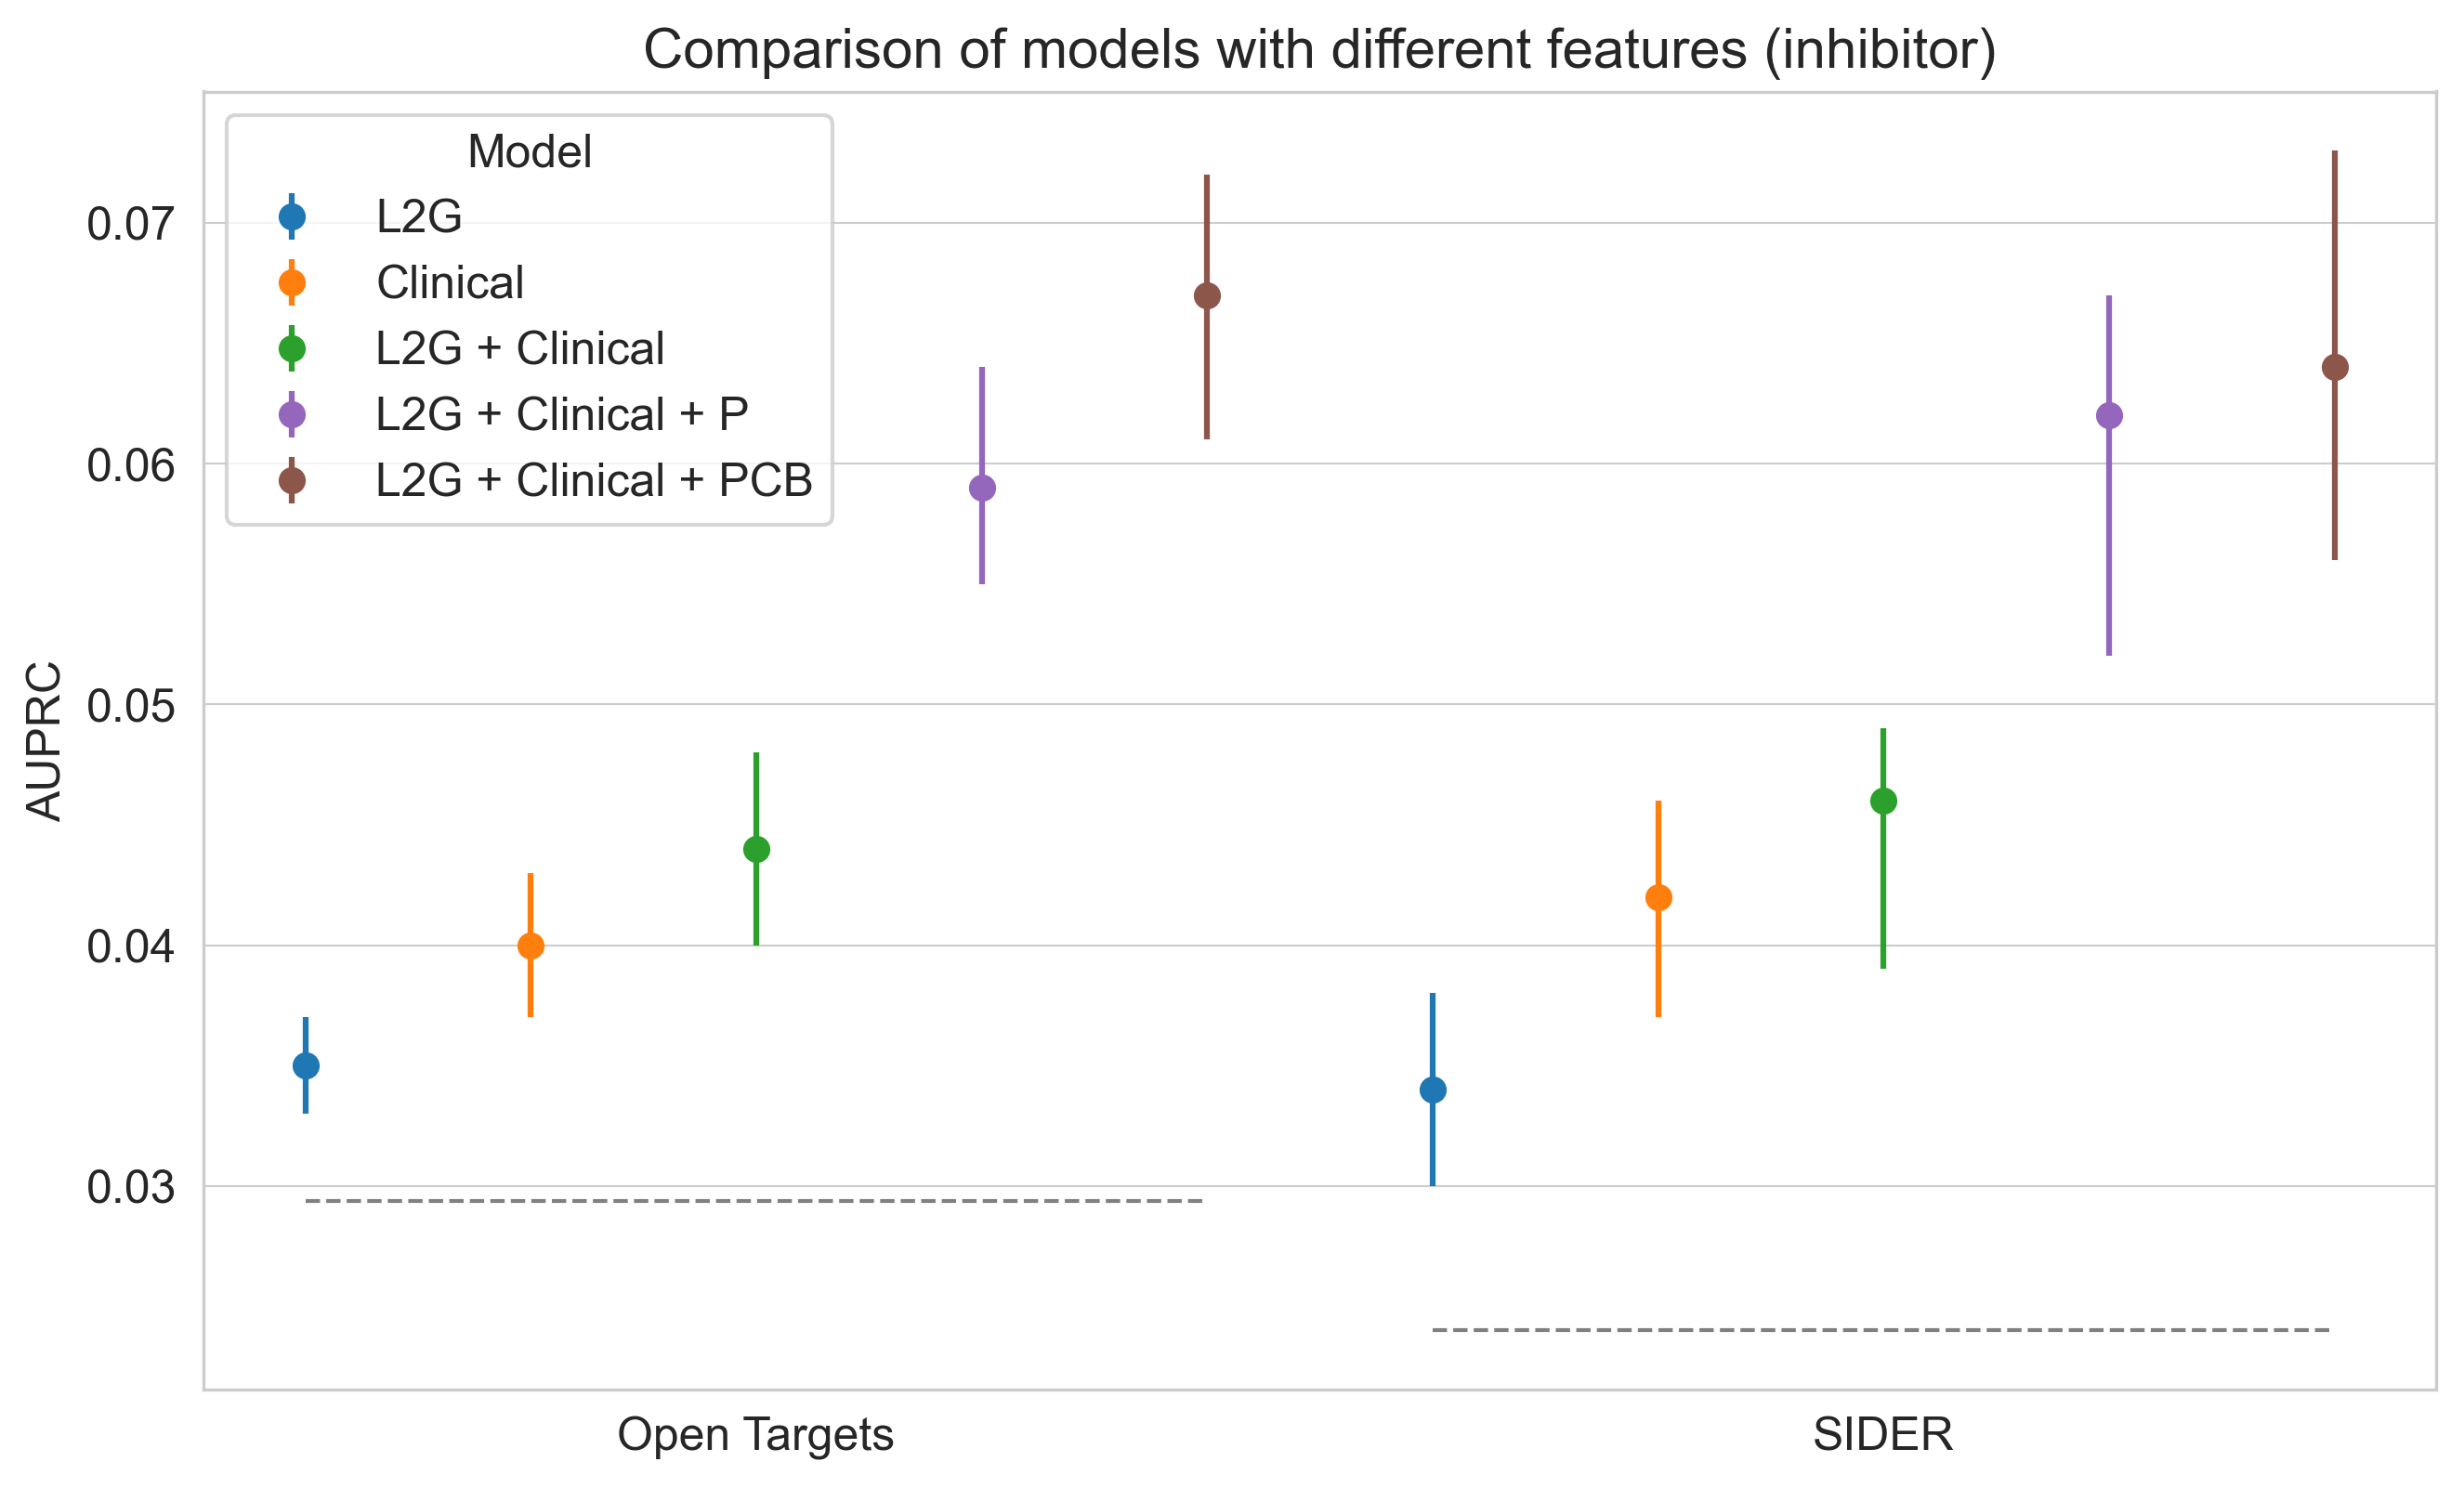

In [62]:
def parse_values(data):
    parsed_data = {}
    for key, value in data.items():
        mean, ci = value.split(' ', 1)
        ci_lower, ci_upper = ci.strip('()').split(', ')
        mean = float(mean)
        ci_lower = float(ci_lower)
        ci_upper = float(ci_upper)
        parsed_data[key] = (mean, (mean - ci_lower, ci_upper - mean))
    return parsed_data

parsed_hold = parse_values(hold_auprc_summary_inh)
parsed_out = parse_values(out_auprc_summary_inh)

# Setup for plotting
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=300)

# Define x-axis positions for the two groups
group_positions = [1, 2]  # For auprc_hold and auprc_out
width = 0.1  # Width of each bar/error bar

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']

def plot_group(group_data, position, color):
    labels = list(group_data.keys())
    num_labels = len(labels)
    total_width = width * 2 * (num_labels - 1)
    start_x = position - total_width / 2

    xpos = []
    for i, label in enumerate(labels):
        # Use the standard Matplotlib colors, cycling through if there are more models than colors
        color = default_colors[i % len(default_colors)]
        x = start_x + i * width * 2  # Adjust the spacing here
        xpos.append(x)
        mean, ci = group_data[label]
        ax.errorbar(x, mean, yerr=[[ci[0]], [ci[1]]], fmt='o', color=color, label=label if position == 1 else "_nolegend_")
    return min(xpos), max(xpos)

# Plot each group and get x positions for lines
xmin_hold, xmax_hold = plot_group(parsed_hold, group_positions[0], default_colors)
xmin_out, xmax_out = plot_group(parsed_out, group_positions[1], default_colors)

# Plot horizontal lines
ax.hlines(hold_df_inh['inhibitor'].mean(), xmin_hold, xmax_hold, colors='grey', linestyles='dashed', linewidth=1)
ax.hlines(out_df_inh['inhibitor'].mean(), xmin_out, xmax_out, colors='grey', linestyles='dashed', linewidth=1)

# Customizing the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(['Open Targets', 'SIDER'])
ax.set_ylabel('AUPRC')

# Generate legend without duplicates
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title='Model')

plt.title('Comparison of models with different features (inhibitor)')
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.grid(False, which='both', axis='x') # Disable vertical grid lines

plt.tight_layout()
plt.show()

In [63]:
results_df = []

percentiles = [(0.75,0.85),(0.85,0.95),(0.95,0.98),(0.98,0.99),(0.99,1.00)]

for file_name in ['L2G','Clinical','L2G + Clinical','L2G + Clinical + P','L2G + Clinical + PCB']:

    print(file_name)
    
    hold = pd.read_pickle(f'./Models/Directional/hold_{file_name}.pkl').groupby(['g-p'])[['hold_act','hold_inh']].mean().reset_index()
    hold = hold.merge(input[['g-p','indication','phase','activator','inhibitor','oe','CV','EM','NS']])
    out = pd.read_pickle(f'./Models/Directional/out_{file_name}.pkl').groupby(['g-p'])[['out_act','out_inh']].mean().reset_index()
    out = out.merge(output[['g-p','indication','phase','activator','inhibitor','oe','CV','EM','GU']])

    if file_name != 'LR':
        imp = pd.read_pickle(f'./Models/Directional/importance_{file_name}.pkl').groupby(['outer_fold','feature'])[['imp_gain','imp_split']].mean().reset_index()
        imp = imp.groupby(['feature']).agg({'imp_gain': mean_ci_df, 'imp_split': mean_ci_df})
        imp = {'imp_gain':imp['imp_gain'].to_dict(), 'imp_split':imp['imp_split'].to_dict()}
    else:
        metrics = pd.read_pickle(f'./Models/Directional/metrics_{file_name}.pkl')
        coef = metrics['coef'][0]
        coef = {'coef':coef}

    #

    print('hold')

    hold_results = {
        "features": file_name,
        "hold_prop_act": hold['activator'].mean(),
        "hold_prop_inh": hold['inhibitor'].mean(),
        "hold_or_act": or_top_bottom(hold,percentiles,'hold_act','activator'),
        "hold_or_inh": or_top_bottom(hold,percentiles,'hold_inh','inhibitor'),
        "hold_or_phase_act": or_phase(hold,'hold_act','activator'),
        "hold_or_phase_inh": or_phase(hold,'hold_inh','inhibitor')
    }

    #

    print('out')
    
    out_results = {
        "out_prop_act": out['activator'].mean(),
        "out_prop_inh": out['inhibitor'].mean(),
        "out_or_act": or_top_bottom(out,percentiles,'out_act','activator'),
        "out_or_inh": or_top_bottom(out,percentiles,'out_inh','inhibitor')
    }

    if file_name != 'LR':
        results_df.append({**hold_results, **out_results, **imp})
    else:
        results_df.append({**hold_results, **out_results, **coef})

pd.DataFrame(results_df).to_excel('./Models/Directional/results.xlsx')

L2G
hold
Optimization terminated successfully.
         Current function value: 0.048368
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048872
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049247
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051426
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132234
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.

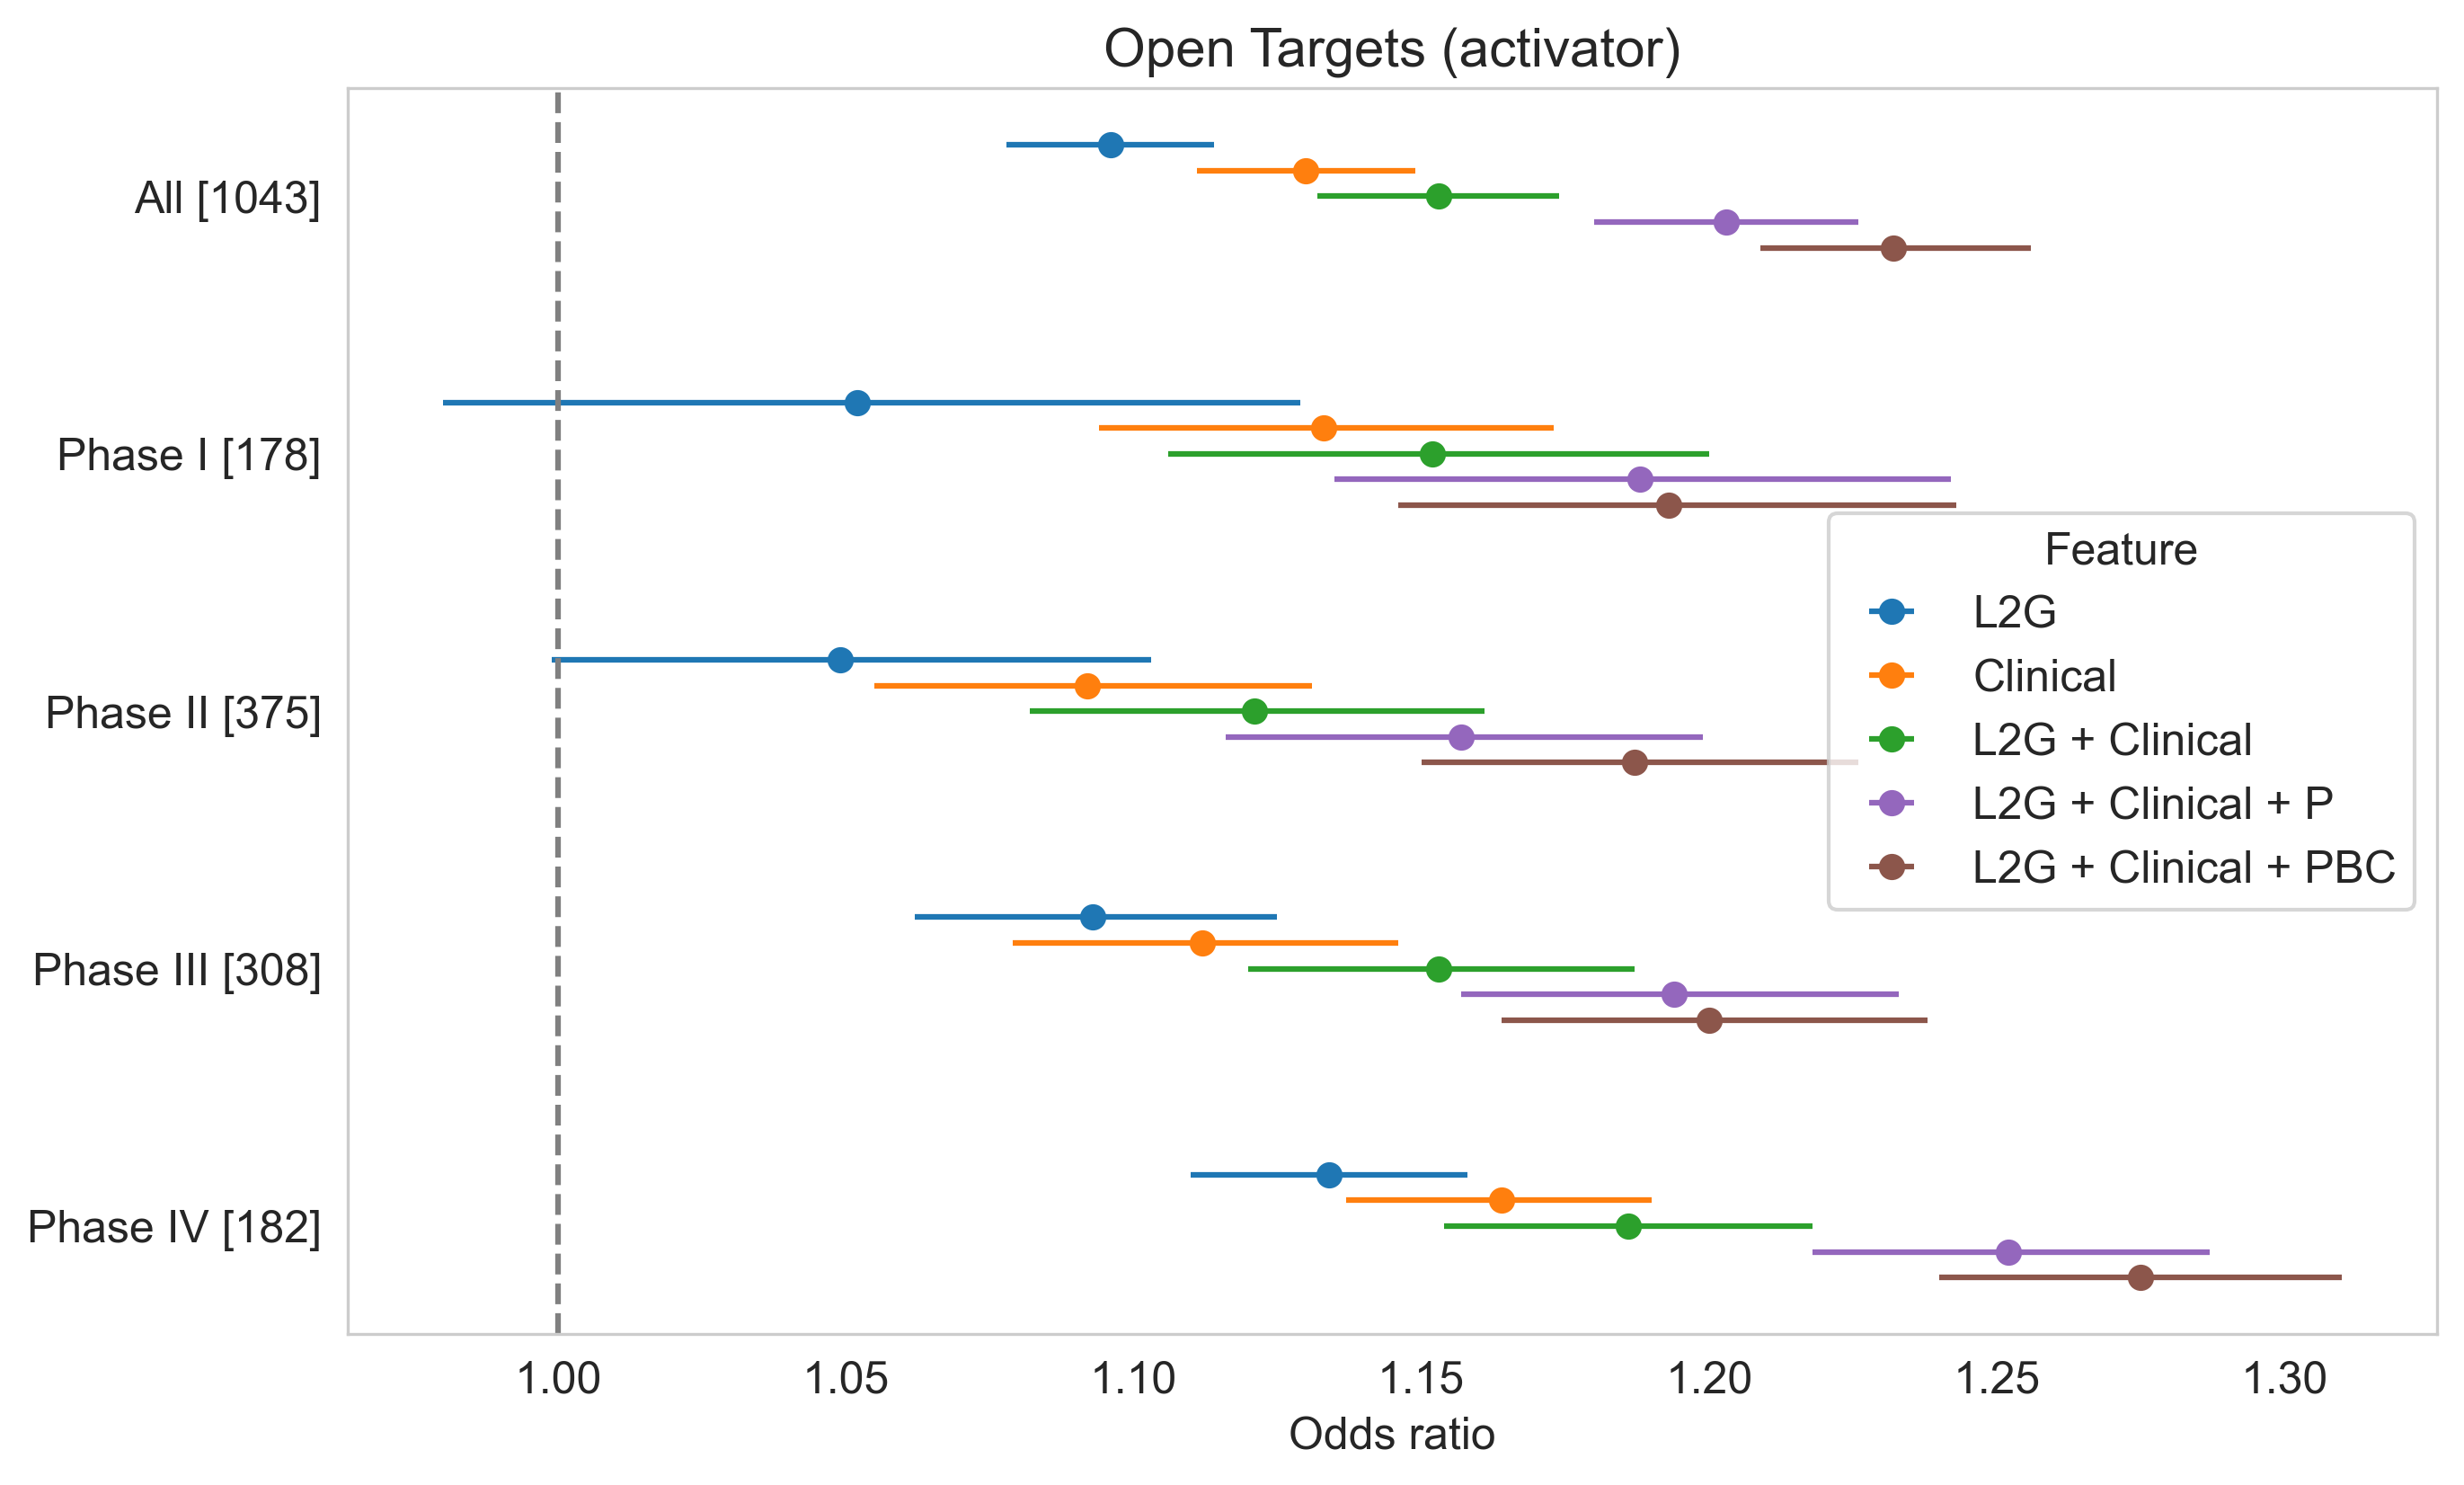

In [64]:
df = pd.read_excel('./Models/Directional/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 1','Phase I')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 2','Phase II')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 3','Phase III')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 4','Phase IV')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 1','Phase I')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 2','Phase II')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 3','Phase III')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 4','Phase IV')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_phase_act'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets (activator)')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

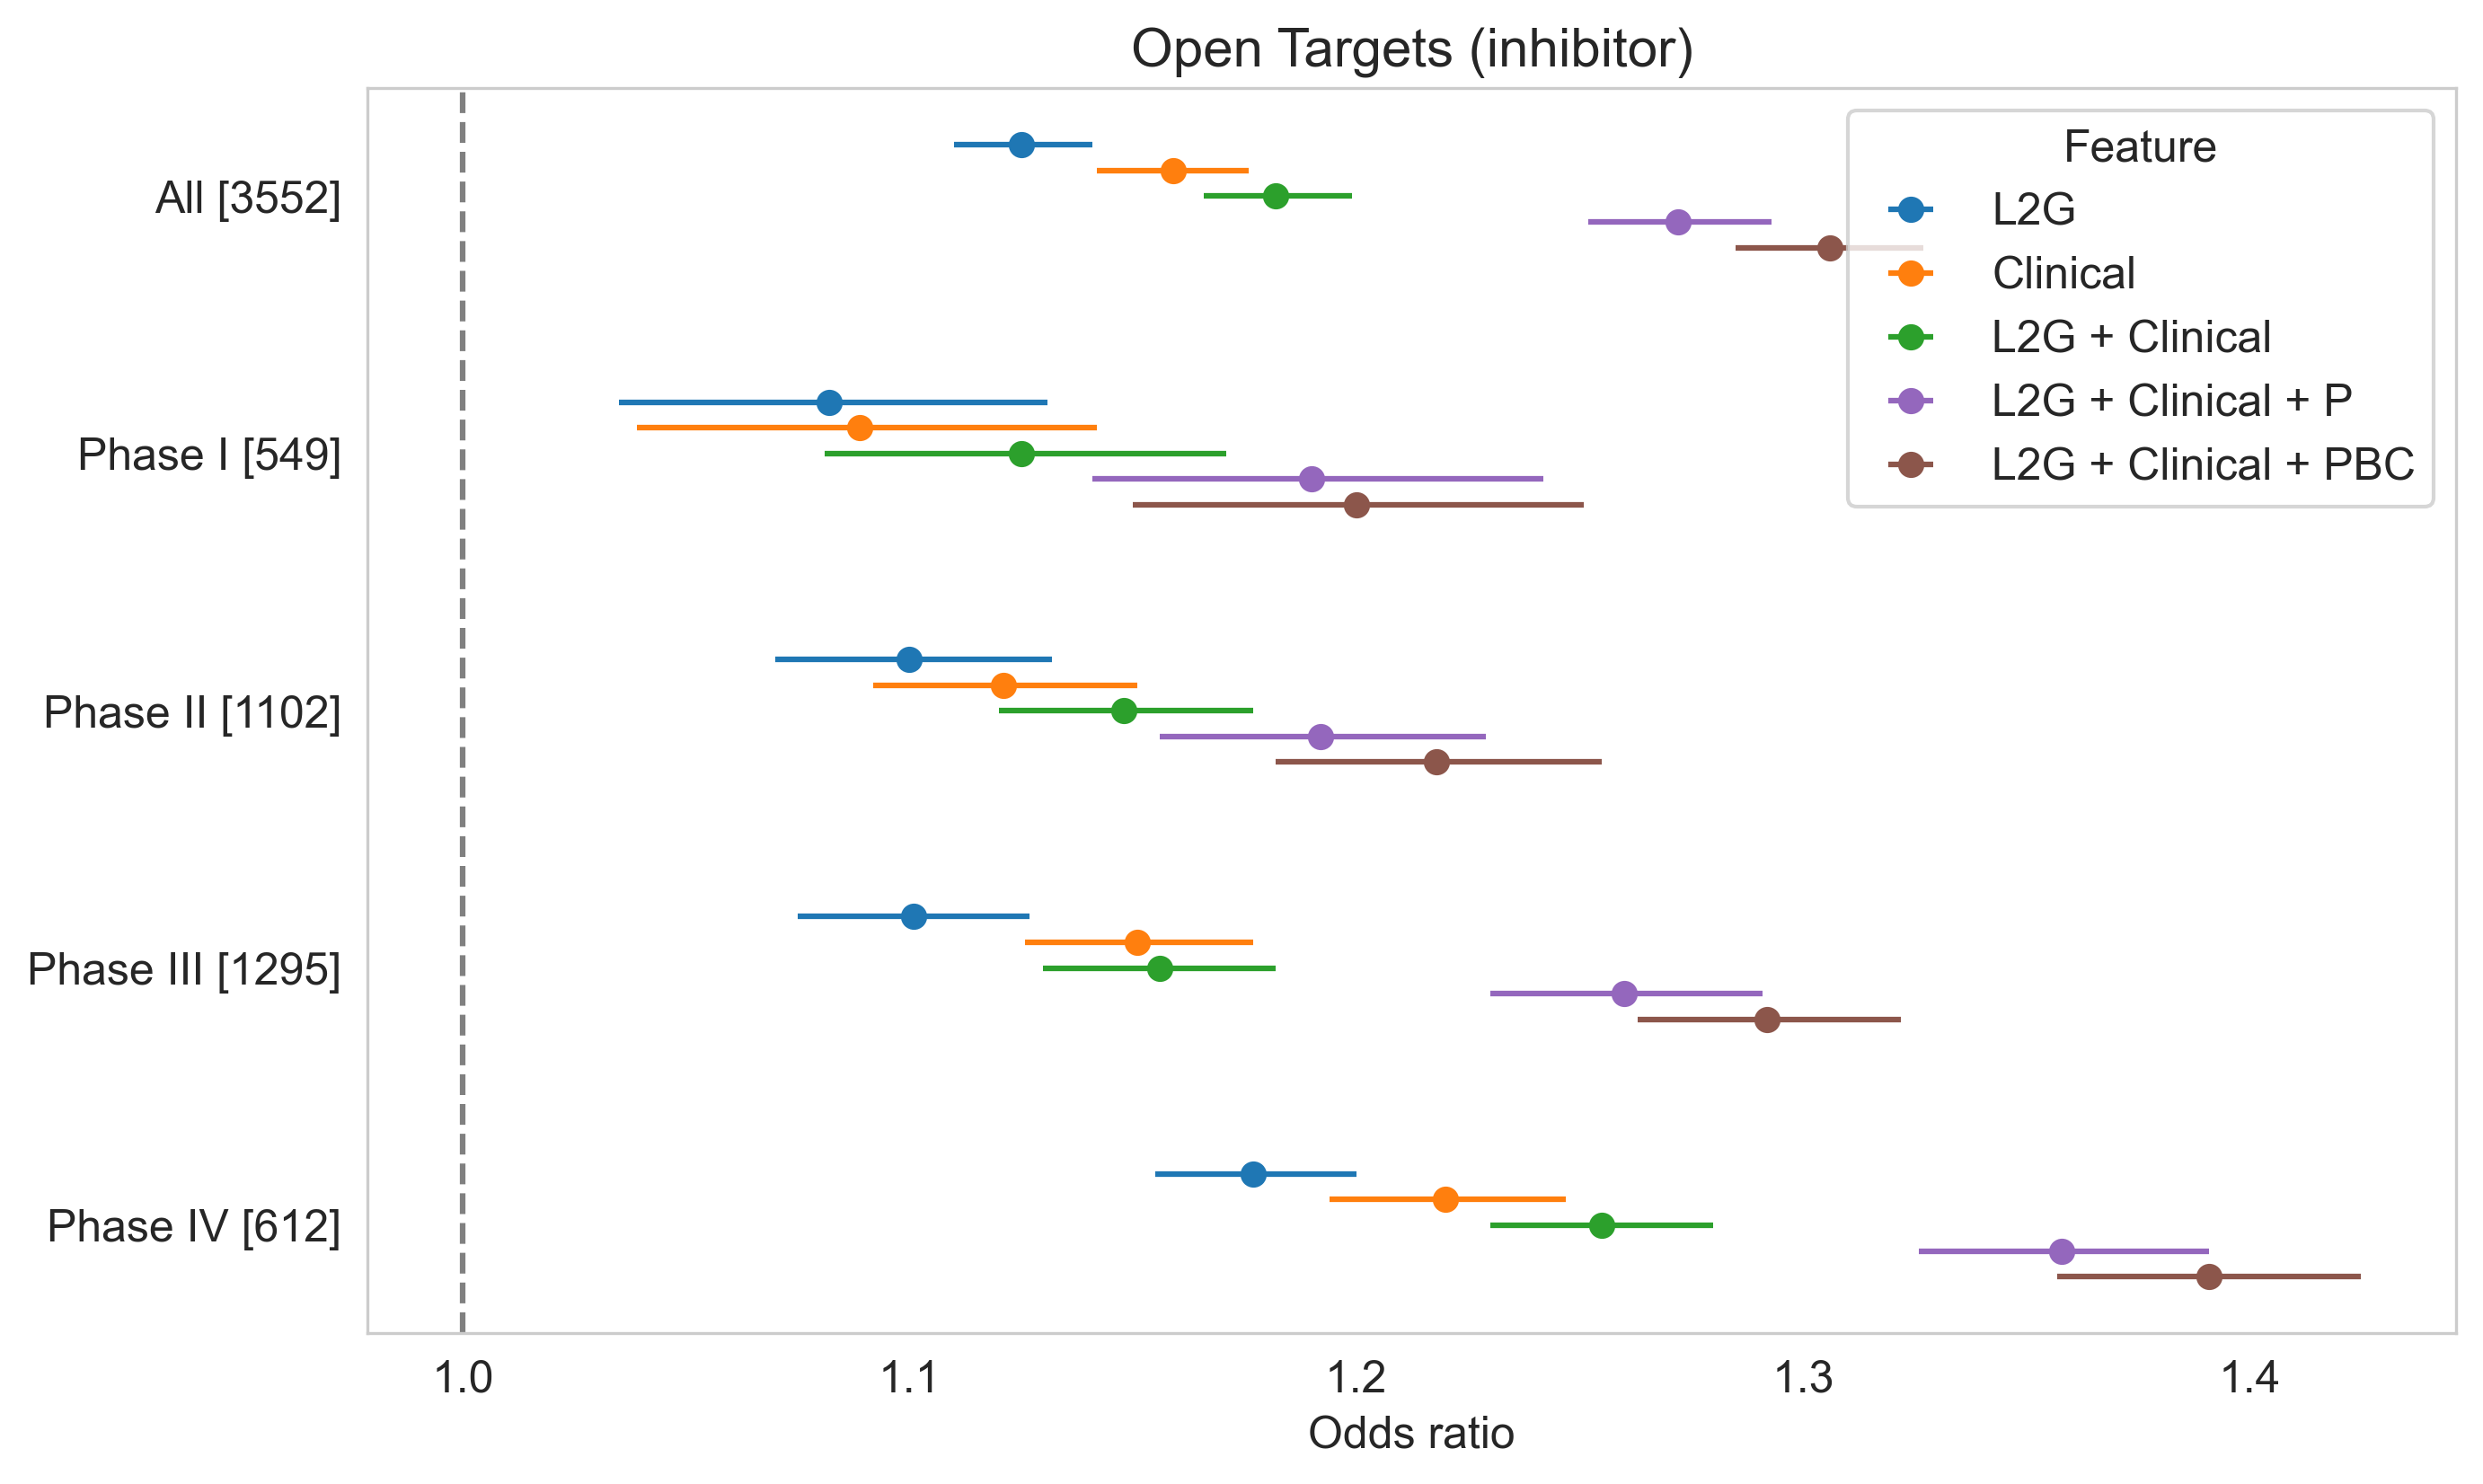

In [65]:
df = pd.read_excel('./Models/Directional/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 1','Phase I')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 2','Phase II')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 3','Phase III')
df['hold_or_phase_act'] = df['hold_or_phase_act'].str.replace('Phase 4','Phase IV')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 1','Phase I')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 2','Phase II')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 3','Phase III')
df['hold_or_phase_inh'] = df['hold_or_phase_inh'].str.replace('Phase 4','Phase IV')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_phase_inh'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets (inhibitor)')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

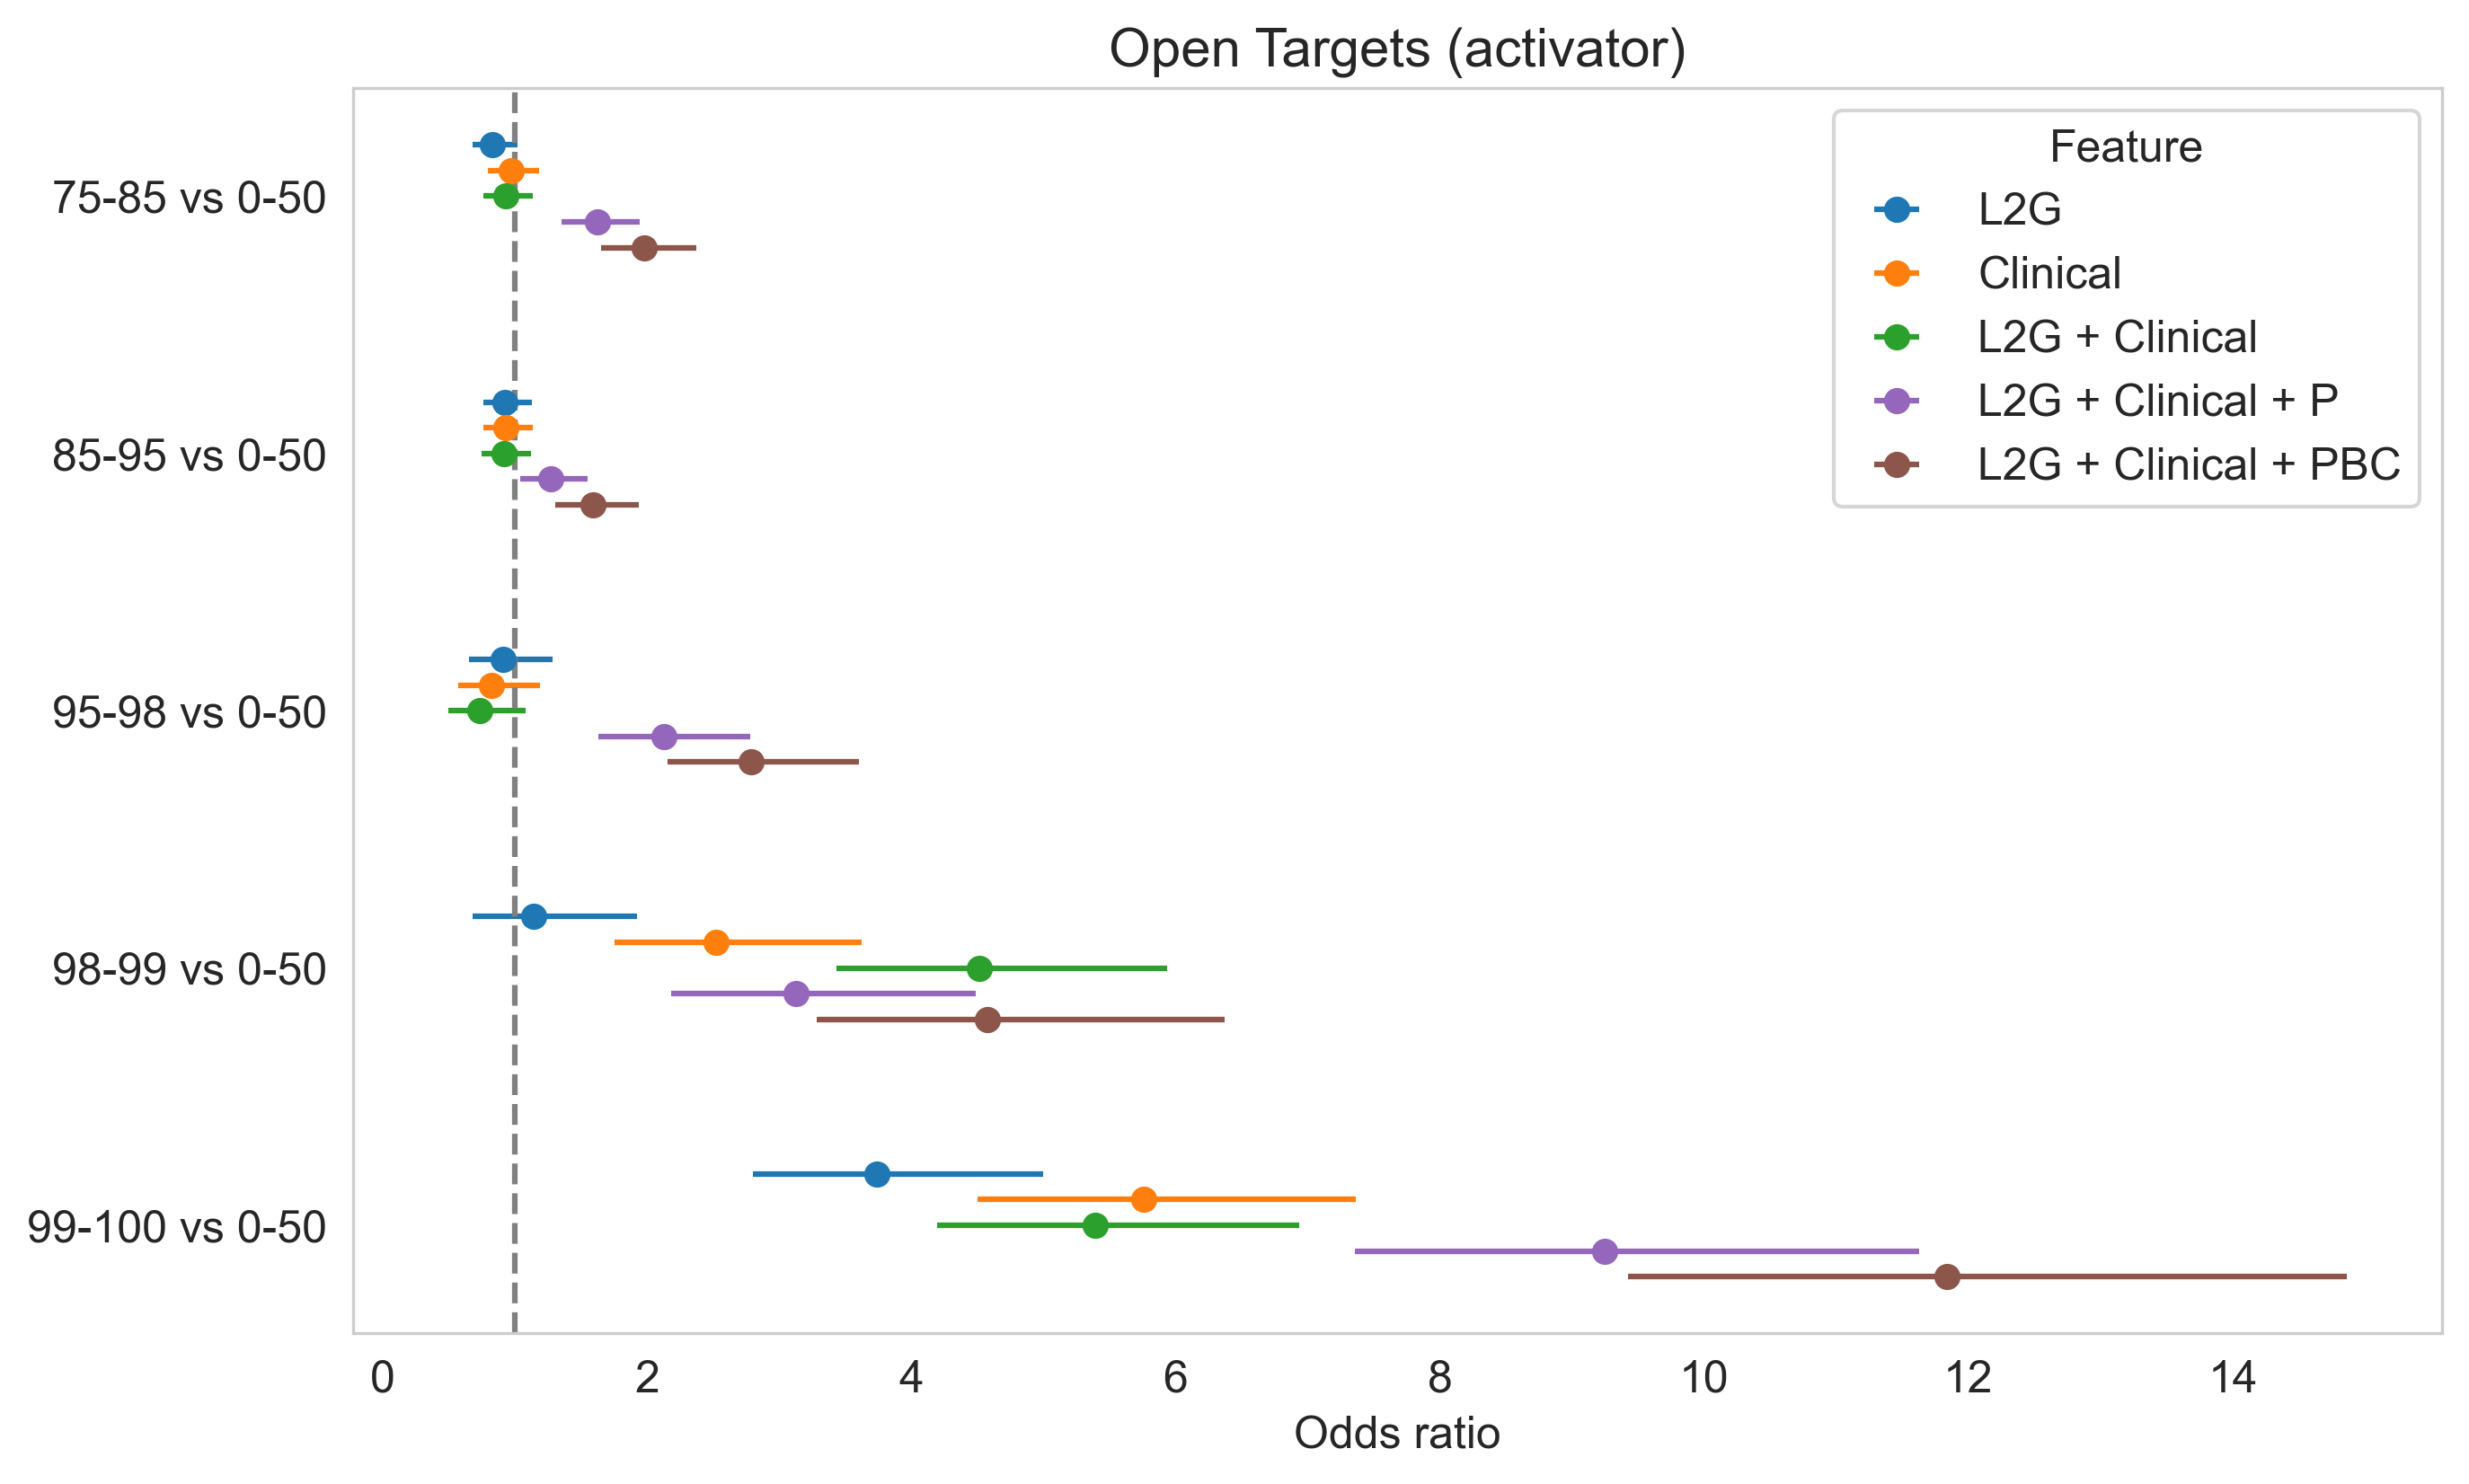

In [66]:
df = pd.read_excel('./Models/Directional/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_act'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets (activator)')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

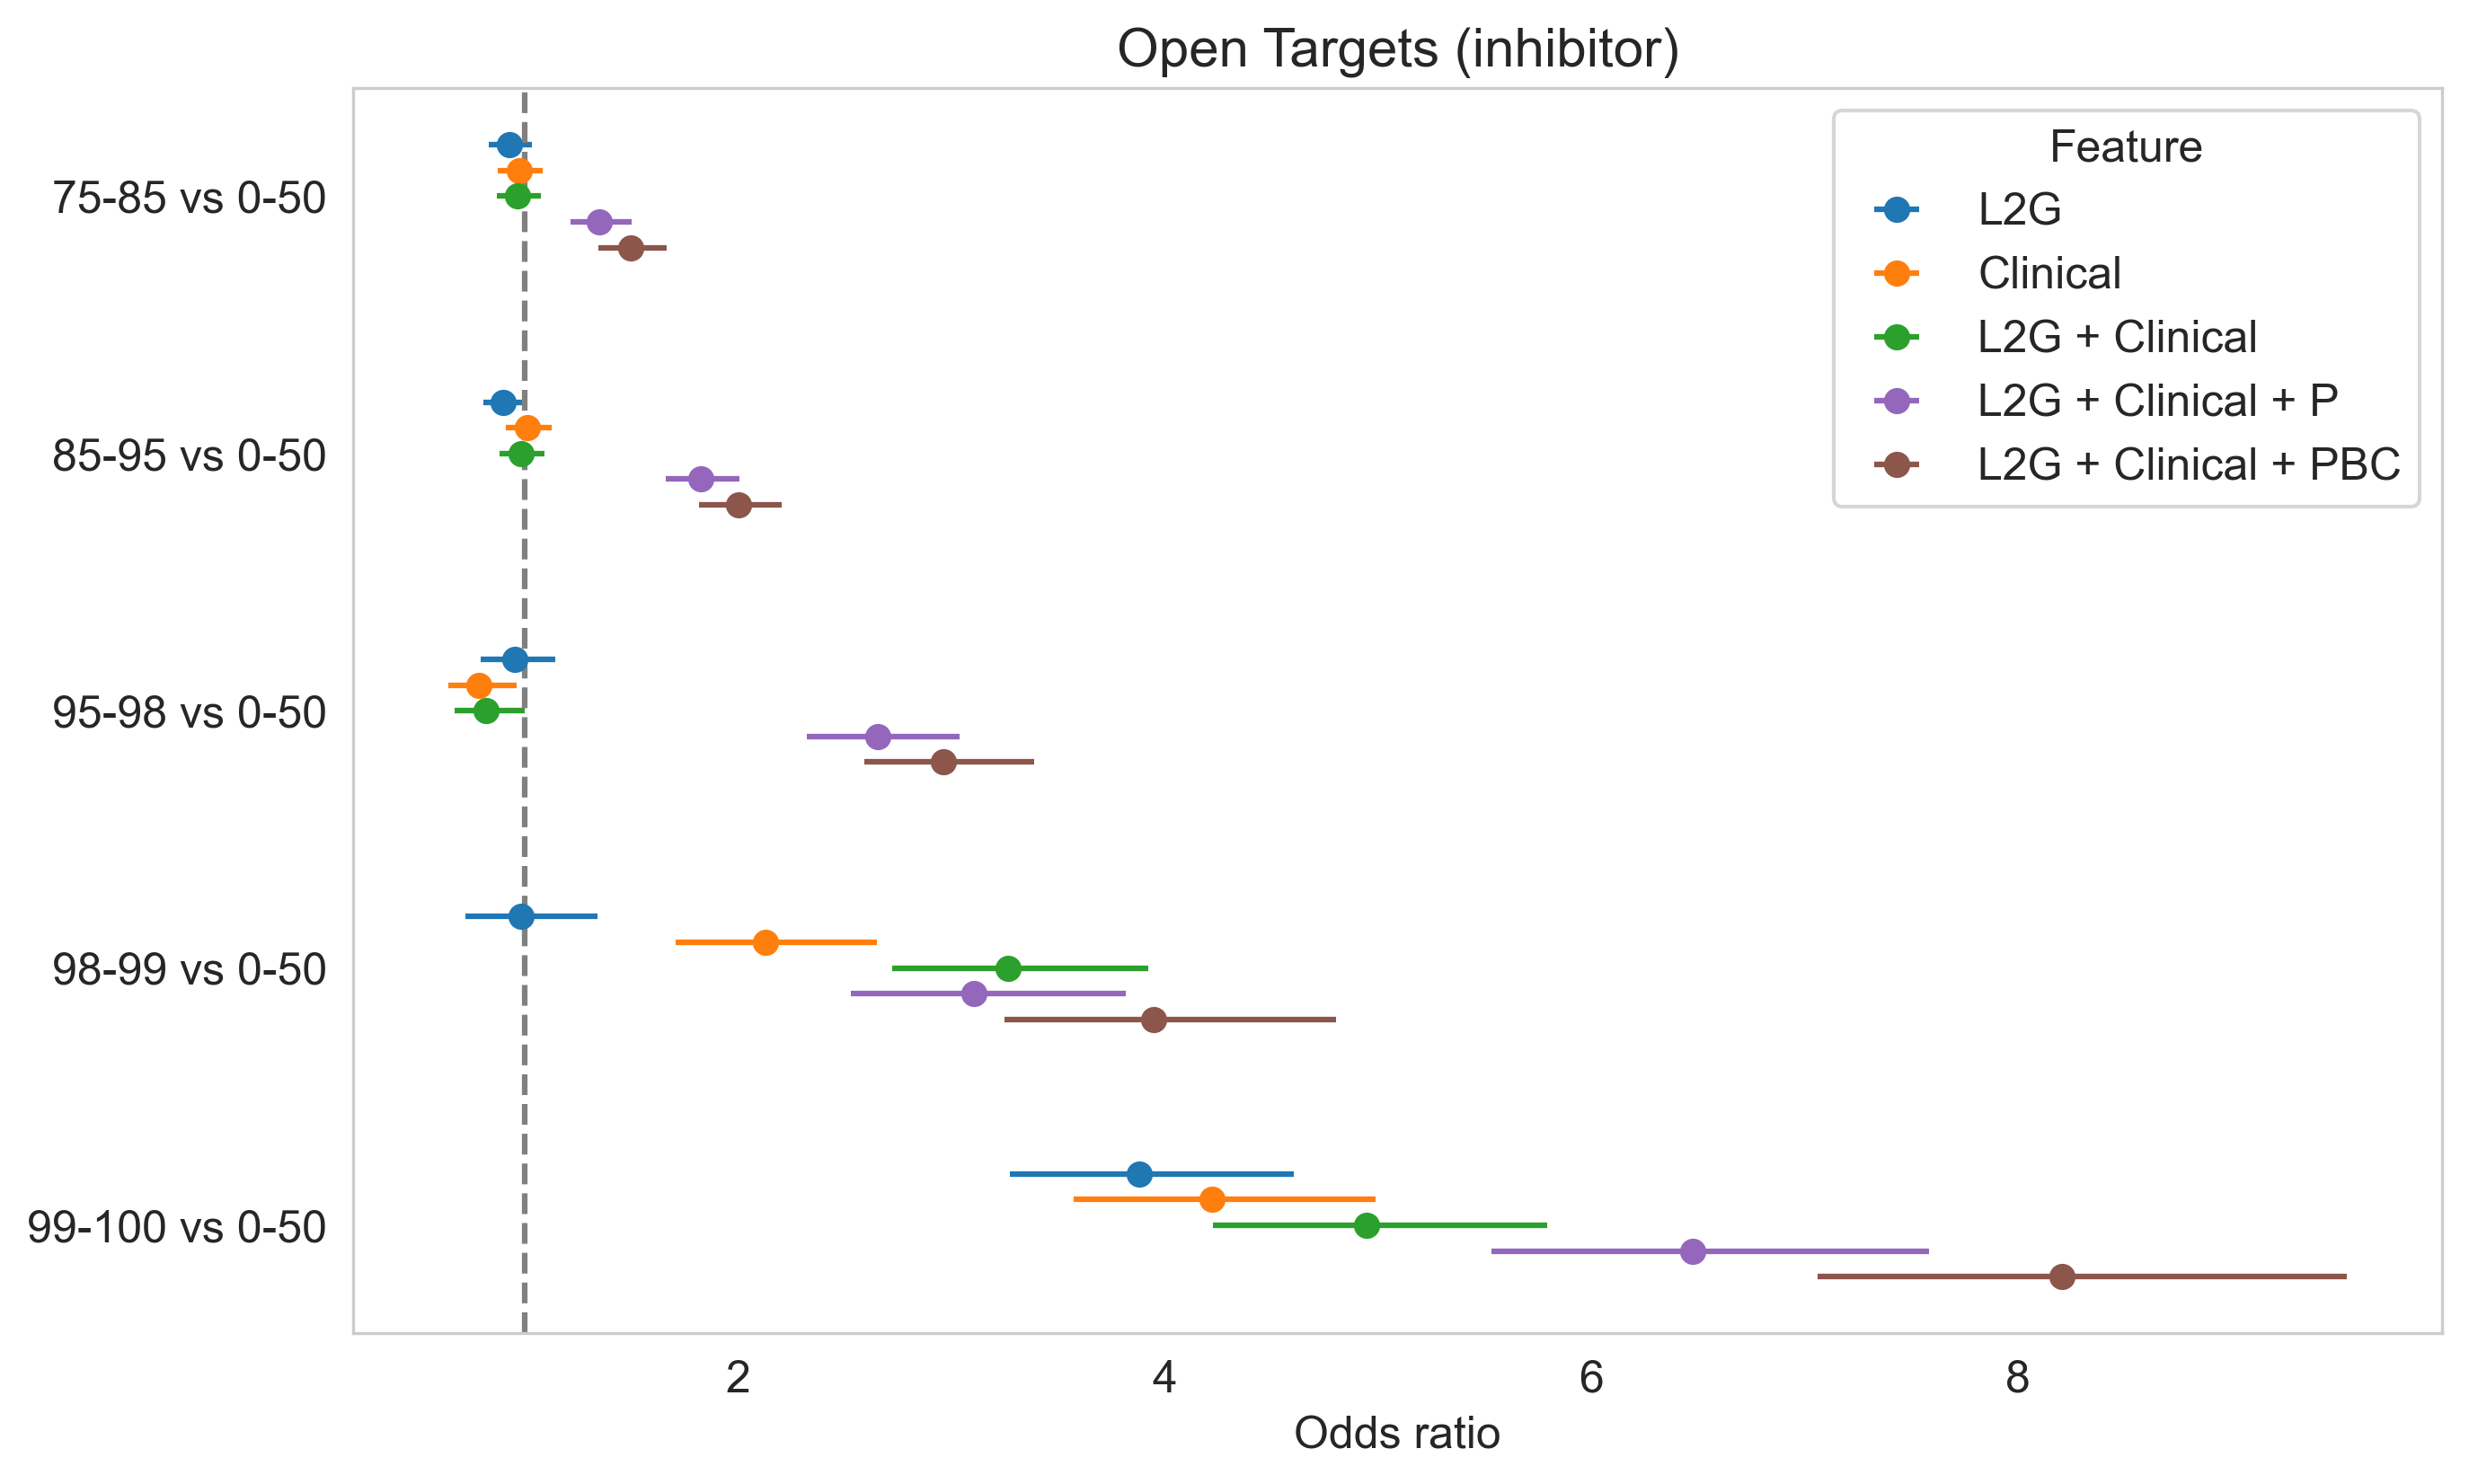

In [67]:
df = pd.read_excel('./Models/Directional/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['hold_or_inh'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('Open Targets (inhibitor)')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

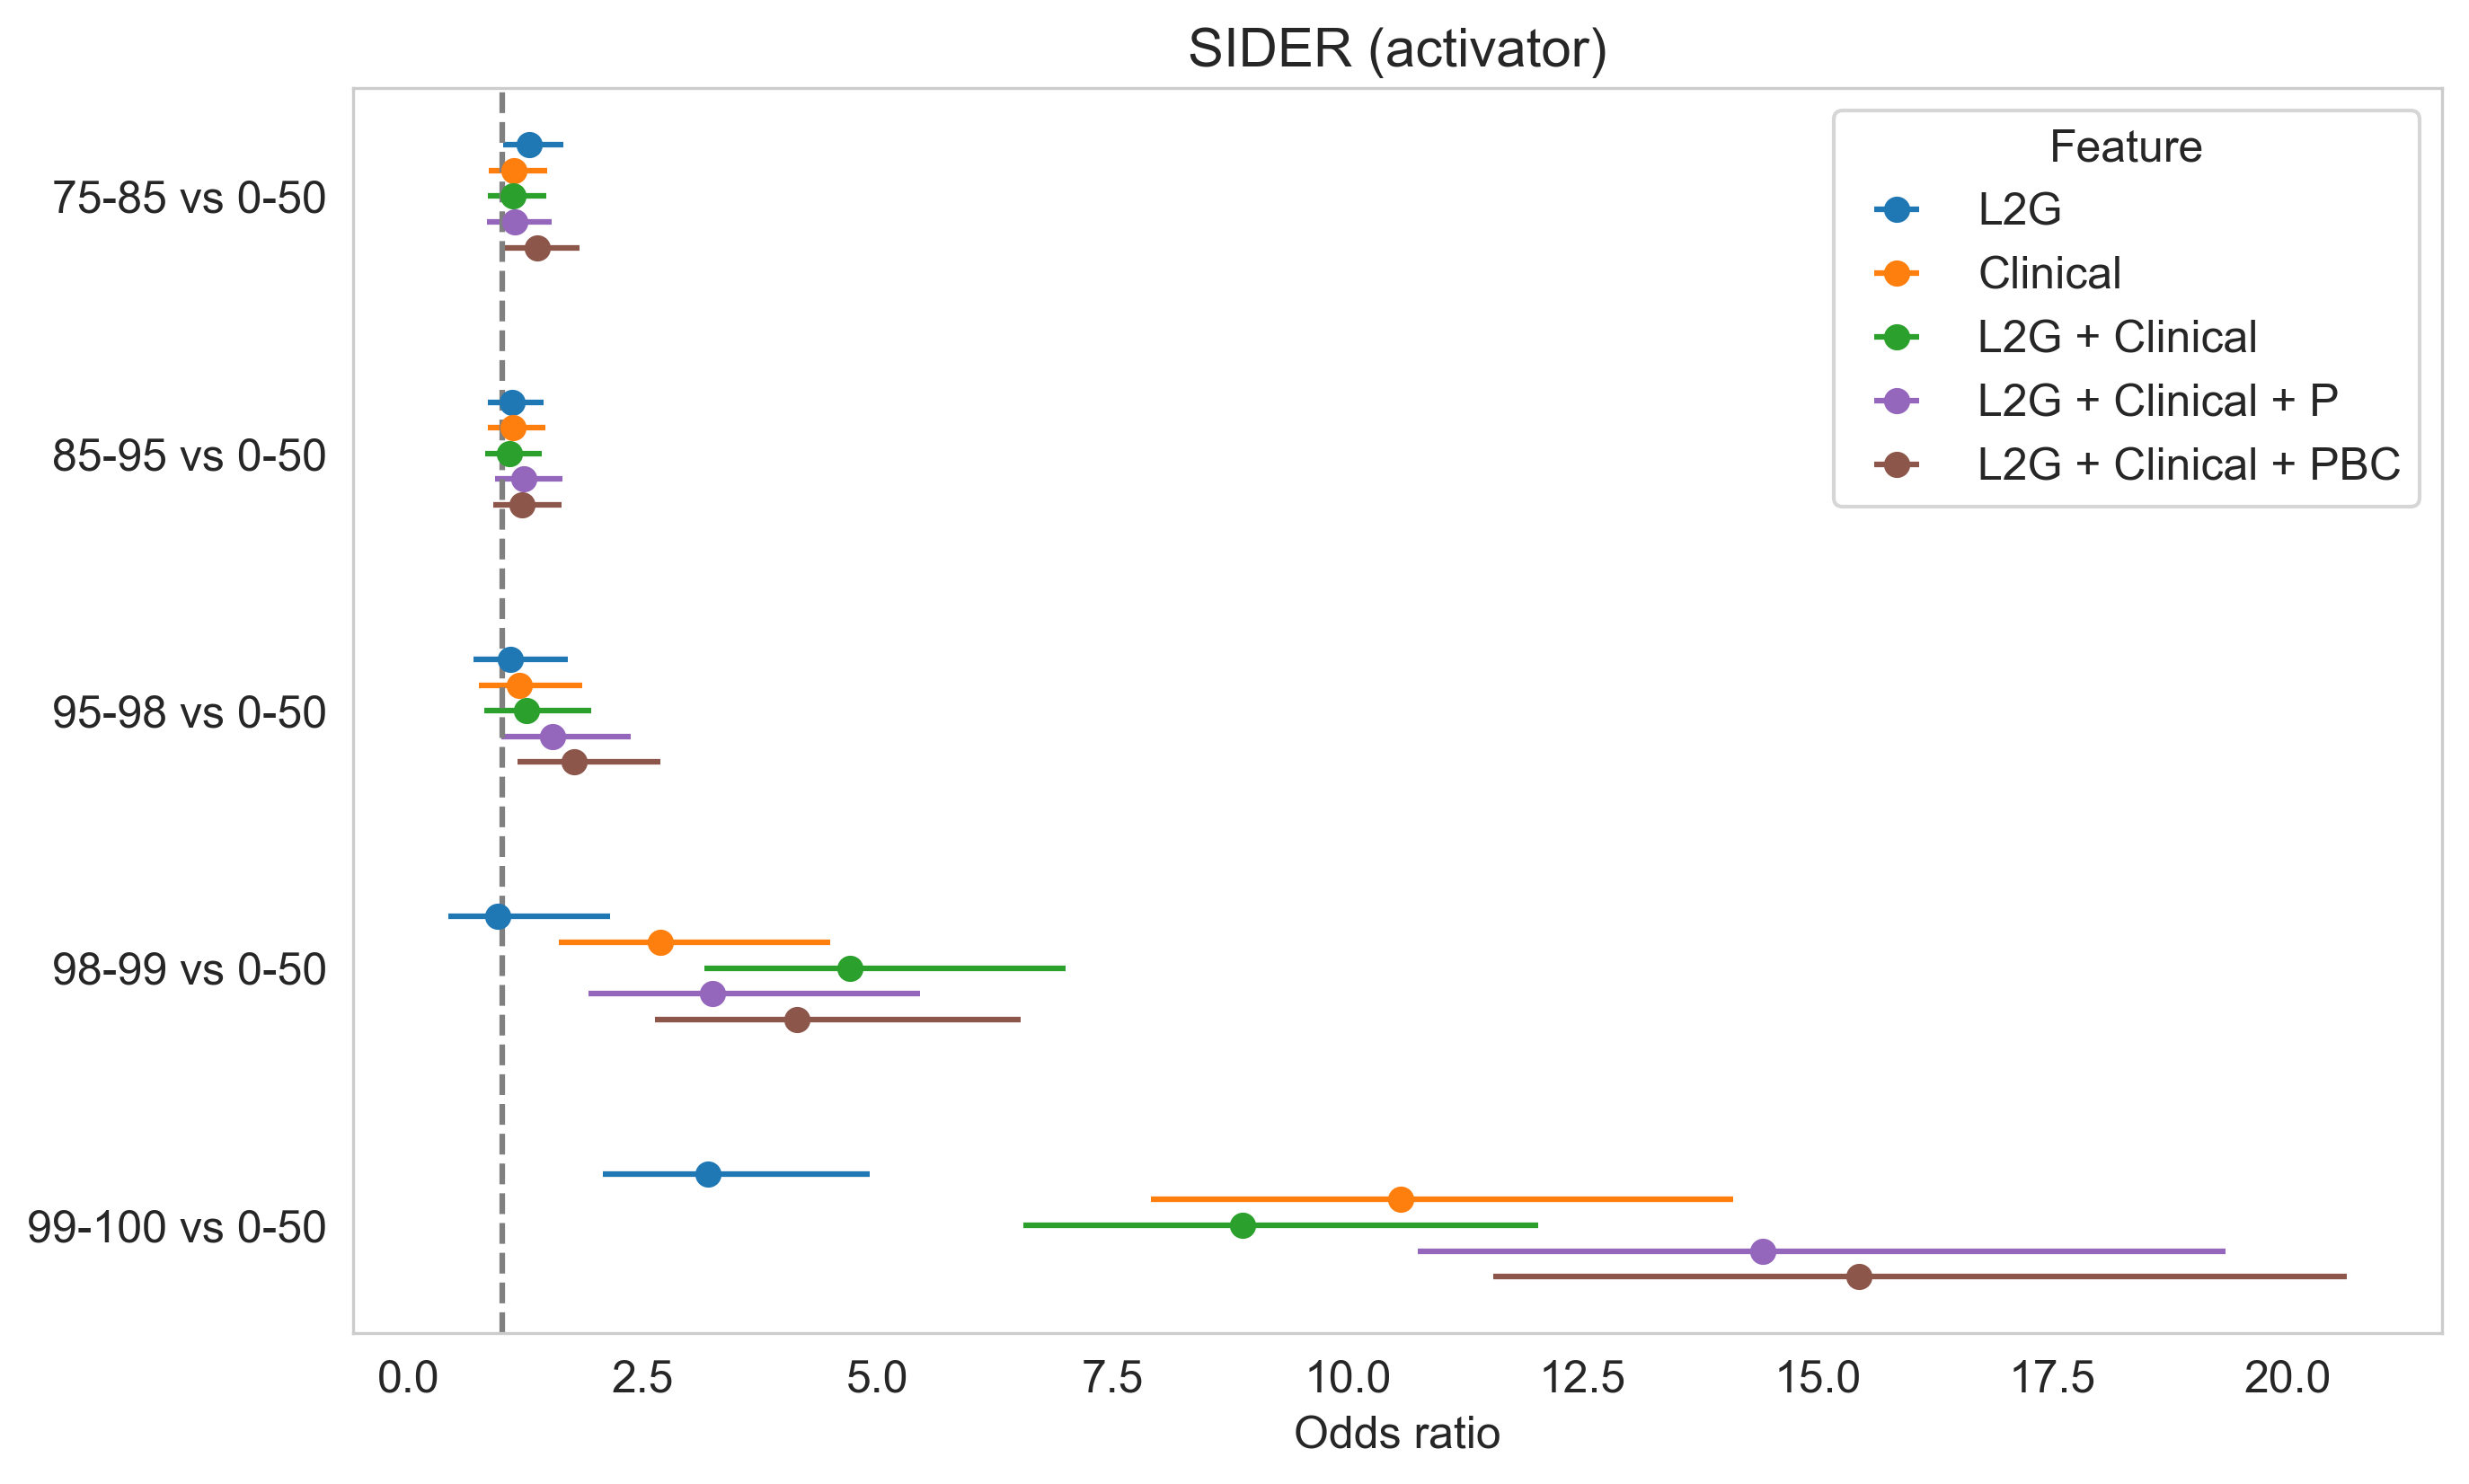

In [68]:
df = pd.read_excel('./Models/Directional/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['out_or_act'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('SIDER (activator)')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()

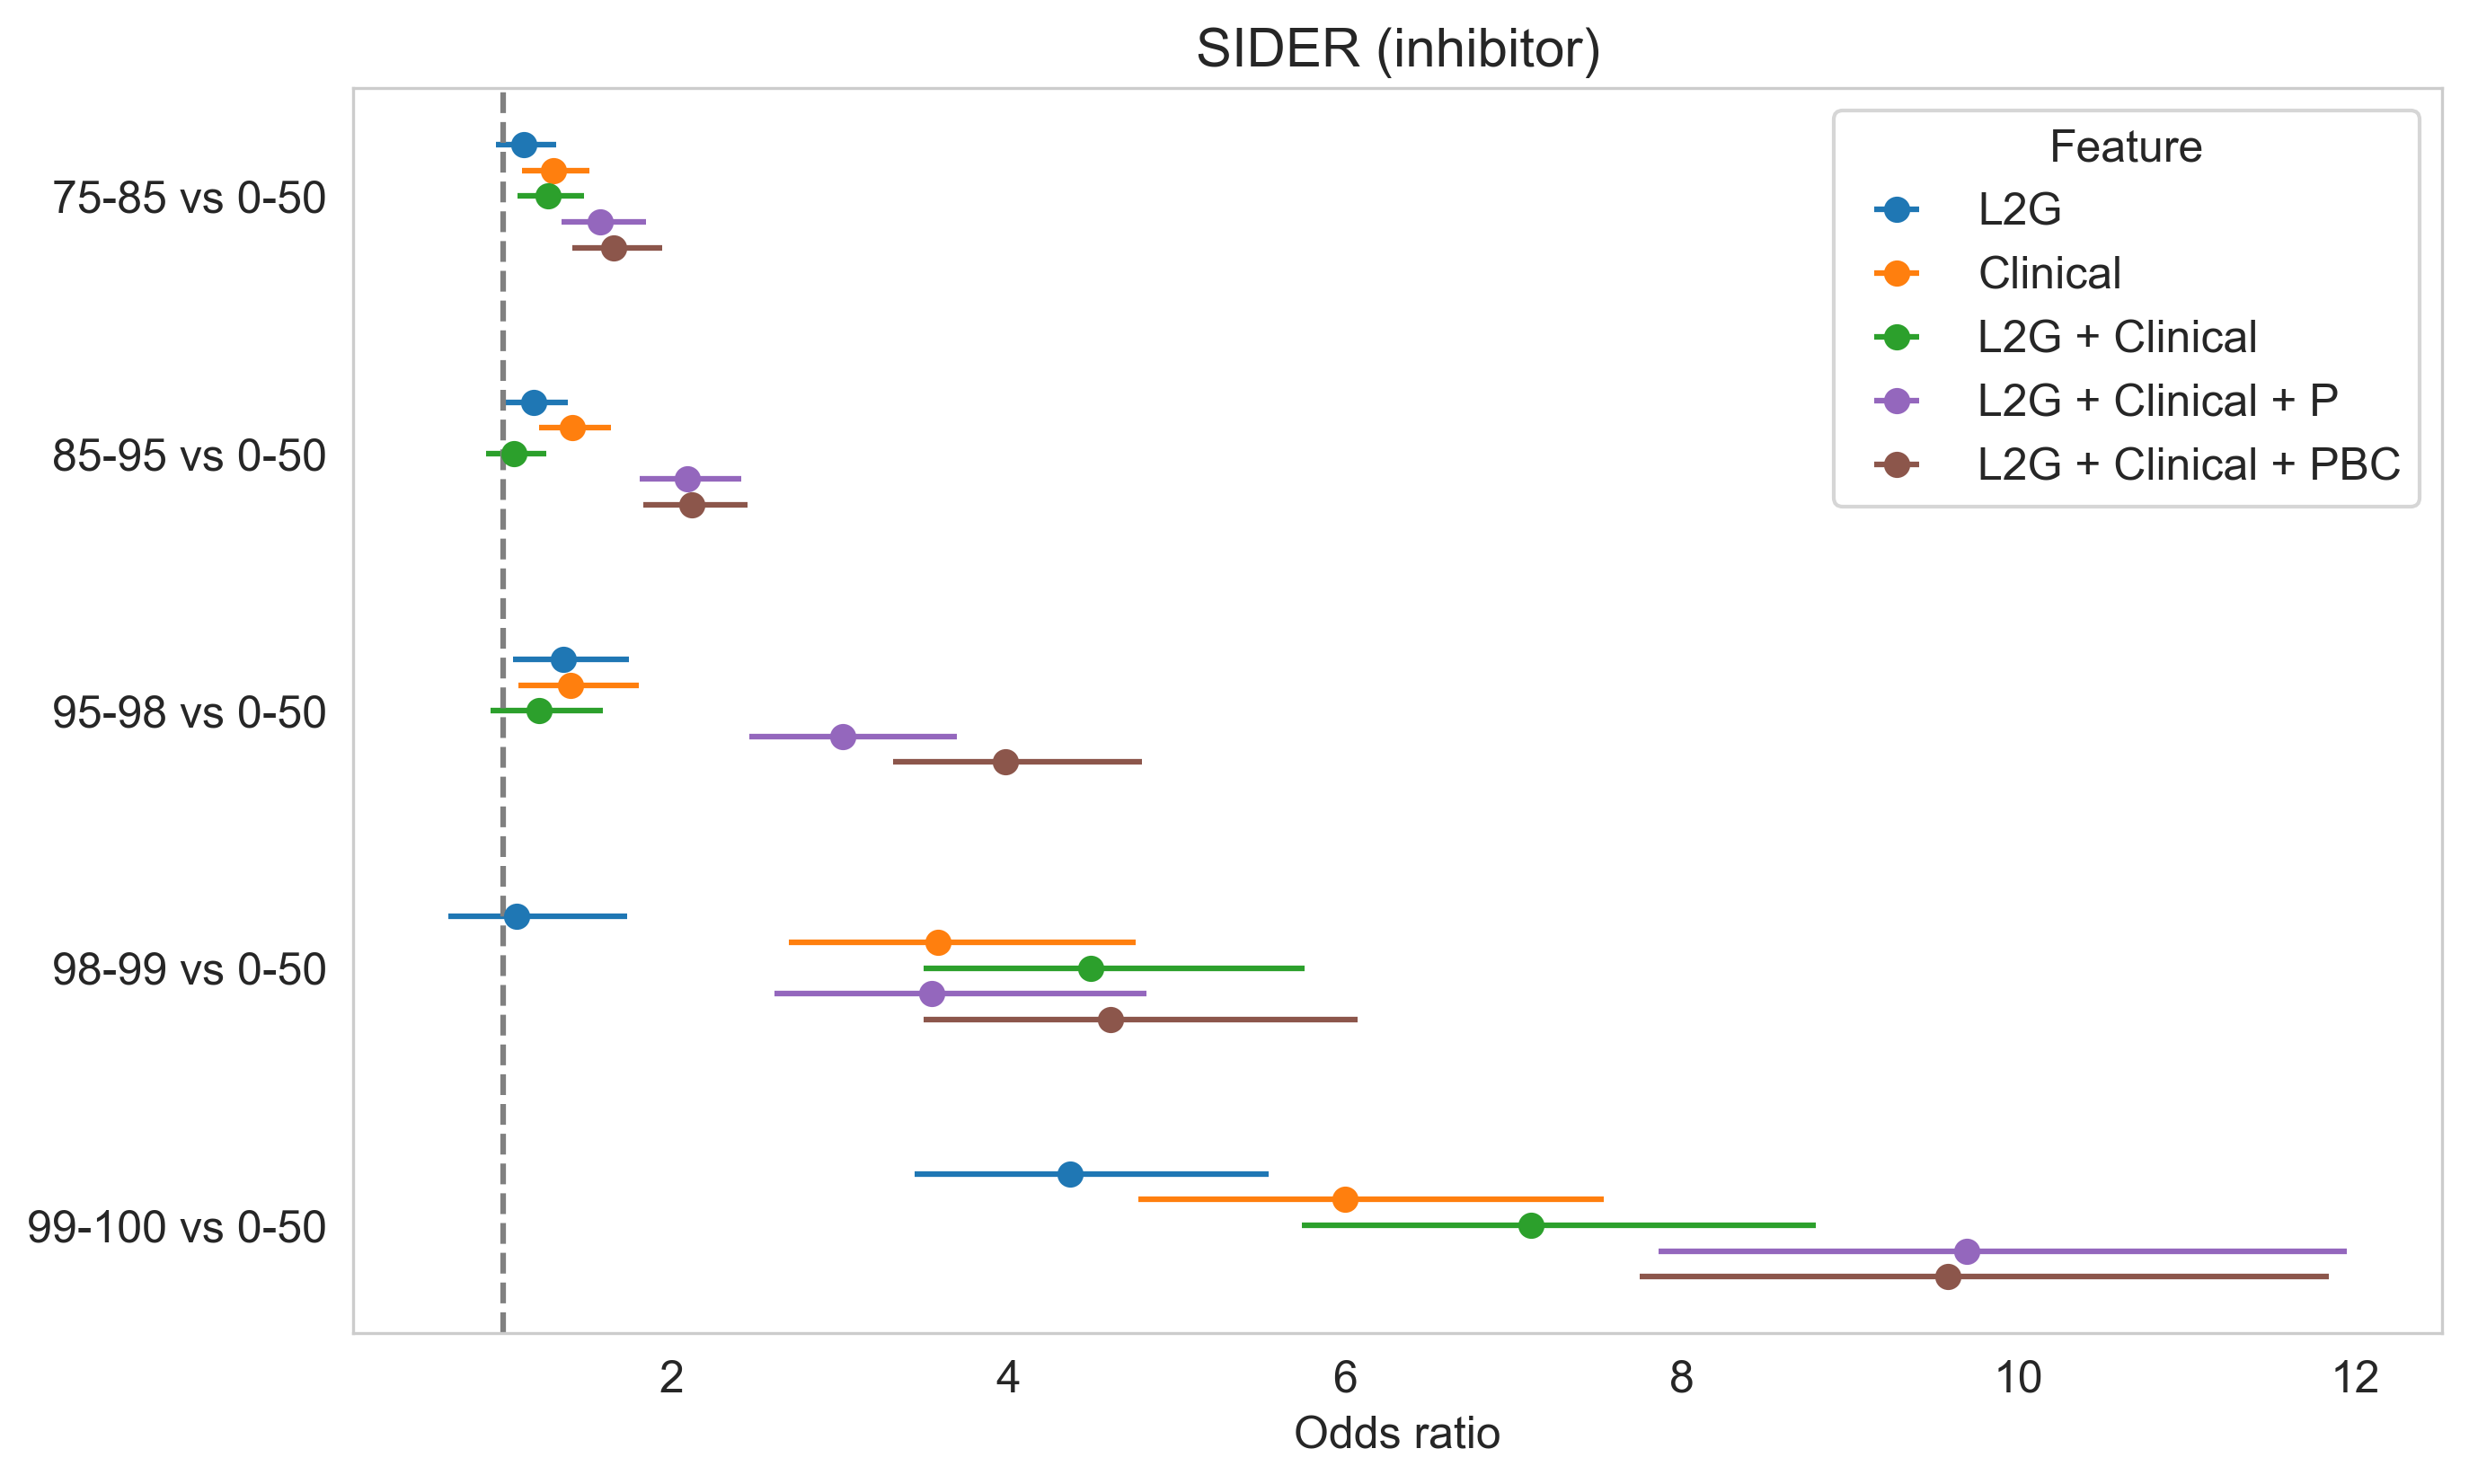

In [69]:
df = pd.read_excel('./Models/Directional/results.xlsx')
df['features'] = df['features'].str.replace('PCB','PBC')

plot_data = []
for _, row in df.iterrows():
    or_dict = eval(row['out_or_inh'])
    for bin, or_ci in or_dict.items():
        or_value, ci_lower, ci_upper = parse_or_ci(or_ci)
        plot_data.append({'Feature': row['features'], 'Bin': bin, 'OR': or_value, 'CI Lower': ci_lower, 'CI Upper': ci_upper})

plot_df = pd.DataFrame(plot_data)
plot_df['y'] = plot_df.groupby('Feature').cumcount()

plt.figure(figsize=(10, 6), dpi=300)
plt.grid(False)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = [color for color in default_colors if color != '#d62728']
features = plot_df['Feature'].unique()
feature_mapping = {feature: i for i, feature in enumerate(features)}
dodge_amount = 0.1  # Set the amount to dodge by

plot_df['y_adjusted'] = plot_df['y'] + plot_df['Feature'].map(feature_mapping) * dodge_amount

for i, feature in enumerate(features):
    subset = plot_df[plot_df['Feature'] == feature]
    color = default_colors[i % len(default_colors)]
    plt.errorbar(subset['OR'], subset['y_adjusted'], xerr=[subset['OR'] - subset['CI Lower'], subset['CI Upper'] - subset['OR']], 
                 fmt='o', label=feature, color=color)


plt.yticks(plot_df.groupby('Bin')['y_adjusted'].mean(), plot_df['Bin'].unique())
plt.xlabel('Odds ratio')
plt.title('SIDER (inhibitor)')
plt.legend(title='Feature')
plt.gca().invert_yaxis()
plt.axvline(x=1, color='grey', linestyle='--')
plt.show()